<a href="https://colab.research.google.com/github/churchmanlab/FIDDLE/blob/master/fiddle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SET UP

In [1]:
!pwd

/n/groups/churchman/dmm57/COLAB


In [0]:
# user specific variables
  # head directory
_head_dir = "/n/groups/churchman/dmm57/COLAB/"
  # compute cluster specificities
_slurm = {
  "email": "dylan_marshall@hms.harvard.edu",
  "virtual_env": "~/colab_venv/"   
}

In [3]:
#@title <-- imports / settings

# native libs
import os, re, subprocess, sys
# external libs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal as sig
from scipy import special
import scipy.stats as stats
# style
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_style("ticks")

print("imports / settings are loaded")

imports / settings are loaded


In [4]:
#@title <-- backend variables { run: "auto", display-mode: "form" }

# arabic <---> roman conversions
_a2r = {
  "chrI": 1, 1: "chrI",
  "chrII": 2, 2: "chrII",
  "chrIII": 3, 3: "chrIII",
  "chrIV": 4, 4: "chrIV",
  "chrV": 5, 5: "chrV",
  "chrVI": 6, 6: "chrVI",
  "chrVII": 7, 7: "chrVII",
  "chrVIII": 8, 8: "chrVIII",
  "chrIX": 9, 9: "chrIX",
  "chrX": 10, 10: "chrX",
  "chrXI": 11, 11: "chrXI",
  "chrXII": 12, 12: "chrXII",
  "chrXIII": 13, 13: "chrXIII",
  "chrXIV": 14, 14: "chrXIV",
  "chrXV": 15, 15: "chrXV",
  "chrXVI": 16, 16: "chrXVI"
}

# ENSEMBL Fungi genome annotations &
# Winston (HMS Genetics) lab's TSS assay-based annotations
_annotations = {
  "sc": {
    "gff": "Saccharomyces_cerevisiae.R64-1-1.40.gff3",
    "tss": "Scer_polIItranscripts-adjustedTSS.bed"
  },
  "kl": {
    "gff": "GCF_000002515.2_ASM251v1_genomic.gff",
    "tss": {
      1: "Klac1.ctss",
      2: "Klac2.ctss"
    }
  }
}

# bedgraph files
_bedgraphs = {
  "ms": {
    "sc": {
      "wt": {
        1: "WT-30C-2_mnase-midpoint-counts.bedgraph",
        2: "WT-30C-1_mnase-midpoint-counts.bedgraph",
        3: "WT-30C-3_mnase-midpoint-counts.bedgraph",
        4: "GSM2561057_Dyads_H3_CC_rep_1.bw.bedGraph"
      },
      "ko": {
        "spt6-1004": "spt6-1004-37C-2_mnase-midpoint-counts.bedgraph",
        "spt6-YW": "spt6-YW-37C-1_mnase-midpoint-counts.bedgraph"
      }
    },
    "kl": {
      1: "GSM552917_Klac_CM_Dec0908_nucCount_100_edited.wig",
      2: "GSM552917_Klac_CM_Dec0908_nucCount_100_edited.wig"
    }
  },
  "ns": {
    "sc": {
      "wt": {
        "pos": "WT-30C-1_netseq-5end-counts-plus.bedgraph",
        "neg": "WT-30C-1_netseq-5end-counts-minus.bedgraph"
      },
      "ko": {
        "chd1": {
          "pos": "chd1-4.pos.bed",
          "neg": "chd1-4.neg.bed"
        },
        "ino80": {
          "pos": "ino80-2.pos.bed",
          "neg": "ino80-2.neg.bed"
        },
        "isw1": {
          "pos": "isw1-2.pos.bed",
          "neg": "isw1-2.neg.bed"
        },
        "isw2": {
          "pos": "isw2-4.pos.bed",
          "neg": "isw2-4.neg.bed"
        },
        "rsc": { # rsc30
          "pos": "rsc30-2.pos.bed",
          "neg": "rsc30-2.neg.bed"
        },
        "spt6-1004": {
          "pos": "spt6-1004-37C-1_netseq-5end-counts-plus.bedgraph",
          "neg": "spt6-1004-37C-1_netseq-5end-counts-minus.bedgraph"
        },
        "spt6-YW": {
          "pos": "spt6-YW-37C-2_netseq-5end-counts-plus.bedgraph",
          "neg": "spt6-YW-37C-2_netseq-5end-counts-minus.bedgraph"
        }
      }
    },
    "kl": "GSM2339539_YJ160_1.bedgraph"
  }
}

# chromosome homogenization (gff / gff3 / bedgraph)
_chrom_convert = {
  # S. cerevisiae
  "I": "chrI",
  "II": "chrII",
  "III": "chrIII",
  "IV": "chrIV",
  "V": "chrV",
  "VI": "chrVI",
  "VII": "chrVII",
  "VIII": "chrVIII",
  "IX": "chrIX",
  "X": "chrX",
  "XI": "chrXI",
  "XII": "chrXII",
  "XIII": "chrXIII",
  "XIV": "chrXIV",
  "XV": "chrXV",
  "XVI": "chrXVI",
  # K. lactis
  "klac_Chr_1": "chrI",
  "klac_Chr_2": "chrII",
  "klac_Chr_3": "chrIII",
  "klac_Chr_4": "chrIV",
  "klac_Chr_5": "chrV",
  "klac_Chr_6": "chrVI",
  "NC_006037.1": "chrI",
  "NC_006038.1": "chrII",
  "NC_006039.1": "chrIII",
  "NC_006040.1": "chrIV",
  "NC_006041.1": "chrV",
  "NC_006042.1": "chrVI",
  # remove mitochondria and other
  "Mito": "remove",
  "MT": "remove",
  "MTR": "remove",
  "NC_006077.1": "remove"
}

# species, chromosome lengths
_chrom_lengths = {
  "sc": {
    "chrI": 230218,
    "chrII": 813184,
    "chrIII": 316620,
    "chrIV": 1531933,
    "chrV": 576874,
    "chrVI": 270161,
    "chrVII": 1090940,
    "chrVIII": 562643,
    "chrIX": 439888,
    "chrX": 745751,
    "chrXI": 666816,
    "chrXII": 1078177,
    "chrXIII": 924431,
    "chrXIV": 784333,
    "chrXV": 1091291,
    "chrXVI": 948066
  },
  "kl": {
    "chrI": 1062590,
    "chrII": 1320834,
    "chrIII": 1753957,
    "chrIV": 1715506,
    "chrV": 2234072,
    "chrVI": 2602197
  }
}

# directories
_dirs = {
  "raw": _head_dir + "DATA/RAW/",
  "collated": _head_dir + "DATA/COLLATED/",
  "figs_stats": _head_dir + "MODELS/FIGURES_STATS/",
  "logs": _head_dir + "logs/",
  "model_inputs": _head_dir + "MODELS/INPUTS/",
  "model_outputs": _head_dir + "MODELS/OUTPUTS/",
  "trained_models": _head_dir + "MODELS/TRAINED/",
  "scripts": _head_dir + "MODELS/SCRIPTS/"
}

# DNA sequence FASTA files
_fastas = {
  "sc": {
    "chrI": "SC_chr01.fsa",
    "chrII": "SC_chr02.fsa",
    "chrIII": "SC_chr03.fsa",
    "chrIV": "SC_chr04.fsa",
    "chrV": "SC_chr05.fsa",
    "chrVI": "SC_chr06.fsa",
    "chrVII": "SC_chr07.fsa",
    "chrVIII": "SC_chr08.fsa",
    "chrIX": "SC_chr09.fsa",
    "chrX": "SC_chr10.fsa",
    "chrXI": "SC_chr11.fsa",
    "chrXII": "SC_chr12.fsa",
    "chrXIII": "SC_chr13.fsa",
    "chrXIV": "SC_chr14.fsa",
    "chrXV": "SC_chr15.fsa",
    "chrXVI": "SC_chr16.fsa"
  },
  "kl": {
    "chrI": "KL_chr01.fsa",
    "chrII": "KL_chr02.fsa",
    "chrIII": "KL_chr03.fsa",
    "chrIV": "KL_chr04.fsa",
    "chrV": "KL_chr05.fsa",
    "chrVI": "KL_chr06.fsa"
  }
}

# thresholds and region boundary considerations
_heuristics = {
  "AUG_width": 2048,
  "AUG_us_offset": 64,
  "ol_reg_width": 512,
  "TSS_width": 1024,
  "TSS_seq_signal_percentile": 95,
  "epsilon": 1e-7,
  "training_regions": 16
}

# S. cerevisiae cell states
_sc_N_states = [
  "N_wt",
  "N_ko_chd1",
  "N_ko_ino80",
  "N_ko_isw1",
  "N_ko_isw2",
  "N_ko_rsc",
  "N_ko_spt6-1004",
  "N_ko_spt6-YW"
]

# strand conversions
_strandedness = {
  "+": "pos", "pos": "+",
  "-": "neg", "neg": "-"
}

print("backend variables are loaded")

backend variables are loaded


In [5]:
#@title <-- custom functions

def _np_5_to_3_kl(gene, data, width=1024):
  """orient extracted data in 5' --> 3' direction"""
  # get genomic and sequencing data at gene location
  seqid, strand = gene["seqid"], gene["strand"]
  start, end = gene["TSS_start"], gene["TSS_end"]
  locus = _np_get_locus_kl_sp(seqid, start, end, strand, data)
  # ancillary information at gene location
  ancillary_df = pd.DataFrame({
    "strand": np.repeat(gene["strand"], width),
    "ID": np.repeat(gene["ID"], width),
    "seqid": np.repeat(gene["seqid"], width)      
  })
  # return 5' --> 3' orientation genomic and sequencing data
  if gene["strand"] is "+":
    df = pd.concat(
      objs=(ancillary_df, locus.rename(columns={
        "NS_pos": "NS_sense",
        "NS_neg": "NS_antisense"
      })), axis=1)
  else: # gene["strand"] is "-"
    # reverse negative strand data
    for col in [
      "DS_A", "DS_T", "DS_G", "DS_C",
      "MS_1", "MS_2",
      "NS_pos", "NS_neg"
    ]: locus[col] = locus[col].values[::-1]
    # flip negative strand data
    df = pd.concat(
      objs=(ancillary_df, locus.rename(columns={
        "NS_pos": "NS_antisense",
        "NS_neg": "NS_sense",
        "DS_A": "DS_T",
        "DS_T": "DS_A",
        "DS_G": "DS_C",
        "DS_C": "DS_G"
      })), axis=1)
  return df[[
    "ID", "strand", "seqid", "position", 
    "DS_A", "DS_C", "DS_G", "DS_T",
    "NS_sense", "NS_antisense",
    "MS_1", "MS_2"]]


def _np_5_to_3_sc(gene, approach, data, width=1024):
  """orient extracted data in 5' --> 3' direction"""
  # get genomic and sequencing data at gene location
  seqid, strand = gene["seqid"], gene["strand"]
  start, end = gene[approach + "_start"], gene[approach + "_end"]
  # random boundaries for AUG - phasing
  if approach == "AUG":
    start, end = _np_random_start_end(start, end, strand, width)
  locus = _np_get_locus_sc(approach, seqid, start, end, strand, data)
  # ancillary information at gene location
  ancillary_df = pd.DataFrame({
    "strand": np.repeat(gene["strand"], width),
    "ID": np.repeat(gene["ID"], width),
    "seqid": np.repeat(gene["seqid"], width)      
  })
  # return 5' --> 3' orientation genomic and sequencing data
  if approach == "TSS":
    if gene["strand"] is "+":
      df = pd.concat(
        objs=(ancillary_df, locus.rename(columns={
          "NS_wt_pos": "NS_wt_sense",
          "NS_wt_neg": "NS_wt_antisense",
          "NS_ko_chd1_pos": "NS_ko_chd1_sense",
          "NS_ko_chd1_neg": "NS_ko_chd1_antisense",
          "NS_ko_ino80_pos": "NS_ko_ino80_sense",
          "NS_ko_ino80_neg": "NS_ko_ino80_antisense",
          "NS_ko_isw1_pos": "NS_ko_isw1_sense",
          "NS_ko_isw1_neg": "NS_ko_isw1_antisense",
          "NS_ko_isw2_pos": "NS_ko_isw2_sense",
          "NS_ko_isw2_neg": "NS_ko_isw2_antisense",
          "NS_ko_rsc_pos": "NS_ko_rsc_sense",
          "NS_ko_rsc_neg": "NS_ko_rsc_antisense",
          "NS_ko_spt6-1004_pos": "NS_ko_spt6-1004_sense",
          "NS_ko_spt6-1004_neg": "NS_ko_spt6-1004_antisense",
          "NS_ko_spt6-YW_pos": "NS_ko_spt6-YW_sense",
          "NS_ko_spt6-YW_neg": "NS_ko_spt6-YW_antisense"
        })), axis=1)
    else: # gene["strand"] is "-"
      # reverse negative strand data
      for col in [
        "DS_A", "DS_T", "DS_G", "DS_C",
        "NS_wt_pos", "NS_wt_neg",
        "NS_ko_chd1_pos", "NS_ko_chd1_neg",
        "NS_ko_ino80_pos", "NS_ko_ino80_neg",
        "NS_ko_isw1_pos", "NS_ko_isw1_neg",
        "NS_ko_isw2_pos", "NS_ko_isw2_neg",
        "NS_ko_rsc_pos", "NS_ko_rsc_neg",
        "NS_ko_spt6-1004_pos", "NS_ko_spt6-1004_neg",
        "NS_ko_spt6-YW_pos", "NS_ko_spt6-YW_neg",
        "MS_wt_1", "MS_wt_2", "MS_wt_3", "MS_wt_4",
        "MS_ko_spt6-1004", "MS_ko_spt6-YW"
      ]: locus[col] = locus[col].values[::-1]
      # flip negative strand data
      df = pd.concat(
        objs=(ancillary_df, locus.rename(columns={
          "DS_A": "DS_T",
          "DS_T": "DS_A",
          "DS_G": "DS_C",
          "DS_C": "DS_G",
          "NS_wt_pos": "NS_wt_antisense",
          "NS_wt_neg": "NS_wt_sense",
          "NS_ko_chd1_pos": "NS_ko_chd1_antisense",
          "NS_ko_chd1_neg": "NS_ko_chd1_sense",
          "NS_ko_ino80_pos": "NS_ko_ino80_antisense",
          "NS_ko_ino80_neg": "NS_ko_ino80_sense",
          "NS_ko_isw1_pos": "NS_ko_isw1_antisense",
          "NS_ko_isw1_neg": "NS_ko_isw1_sense",
          "NS_ko_isw2_pos": "NS_ko_isw2_antisense",
          "NS_ko_isw2_neg": "NS_ko_isw2_sense",
          "NS_ko_rsc_pos": "NS_ko_rsc_antisense",
          "NS_ko_rsc_neg": "NS_ko_rsc_sense",
          "NS_ko_spt6-1004_pos": "NS_ko_spt6-1004_sense",
          "NS_ko_spt6-1004_neg": "NS_ko_spt6-1004_antisense",
          "NS_ko_spt6-YW_pos": "NS_ko_spt6-YW_sense",
          "NS_ko_spt6-YW_neg": "NS_ko_spt6-YW_antisense"
        })), axis=1)
    return df[[
      "ID", "strand", "seqid", "position", 
      "DS_A", "DS_C", "DS_G", "DS_T",
      "NS_wt_sense", "NS_wt_antisense",
      "NS_ko_chd1_sense", "NS_ko_chd1_antisense",
      "NS_ko_ino80_sense", "NS_ko_ino80_antisense",
      "NS_ko_isw1_sense", "NS_ko_isw1_antisense",
      "NS_ko_isw2_sense", "NS_ko_isw2_antisense",
      "NS_ko_rsc_sense", "NS_ko_rsc_antisense",
      "NS_ko_spt6-1004_sense", "NS_ko_spt6-1004_antisense",
      "NS_ko_spt6-YW_sense", "NS_ko_spt6-YW_antisense",
      "MS_wt_1", "MS_wt_2", "MS_wt_3", "MS_wt_4",
      "MS_ko_spt6-1004", "MS_ko_spt6-YW"
    ]]
  else: # approach == "AUG"
    if gene["strand"] is "+":
      df = pd.concat(
        objs=(ancillary_df, locus.rename(columns={
          "NS_wt_pos": "NS_wt_sense",
          "NS_wt_neg": "NS_wt_antisense"
        })), axis=1)
    else: # gene["strand"] is "-"
      # reverse negative strand data
      for col in [
        "DS_A", "DS_T", "DS_G", "DS_C",
        "NS_wt_pos", "NS_wt_neg",
        "MS_wt_1", "MS_wt_2", "MS_wt_3", "MS_wt_4"
      ]: locus[col] = locus[col].values[::-1]
      # flip negative strand data
      df = pd.concat(
        objs=(ancillary_df, locus.rename(columns={
          "DS_A": "DS_T",
          "DS_T": "DS_A",
          "DS_G": "DS_C",
          "DS_C": "DS_G",
          "NS_wt_pos": "NS_wt_antisense",
          "NS_wt_neg": "NS_wt_sense"
        })), axis=1)
    return df[[
      "ID", "strand", "seqid", "position", 
      "DS_A", "DS_C", "DS_G", "DS_T",
      "NS_wt_sense", "NS_wt_antisense",
      "MS_wt_1", "MS_wt_2", "MS_wt_3", "MS_wt_4"]]


def _np_avg_var_df(df, reqs=[""]):
  """average and variance of species / cell-state MNase-seq predictions
  df := collated predictions dataframe
  reqs := list of necessary strings"""
  return {
    "avg": np.average(_np_get_seq_data([
      col for col in df.columns.values
        if all([y in col for y in reqs + ["mean"]])
    ], df), 1),
    "var": np.var(_np_get_seq_data([
      col for col in df.columns.values
        if all([y in col for y in reqs + ["variance"]])
    ], df), 1)
  }


def _np_bedgraph_to_df(seq, species, rep=None, strand=None, state=None):
  """single vector representation of bedgraph pandas DataFrame"""
  if seq is "MS":
    DFs = _np_get_ms_bg(species, rep, state).groupby("seqid")
    if species != "sc": column = "_".join(["MS", str(rep)])
    elif state == None: column = "_".join(["MS", "wt", str(rep)])
    else: column = "_".join(["MS", "ko", state])
  else: # seq is "NS"
    DFs = _np_get_ns_bg(species, strand, state).groupby("seqid")
    if species != "sc": column = "_".join(["NS", strand])
    elif state == None: column = "_".join(["NS", "wt", strand])
    else: column = "_".join(["NS", "ko", state, strand])
  return pd.concat((
    pd.DataFrame({
      column: np.concatenate(
        [np.repeat(c, diff)
          for (c, diff) in zip(
            DFs.get_group(seqid)["count"].astype("int").values,
            DFs.get_group(seqid)["b"].values - DFs.get_group(seqid)["a"].values
        )])}).reset_index().drop("index", axis=1) for seqid in DFs.groups
    ), ignore_index=True).reset_index().drop("index", axis=1)


def _np_ds_meta_repr(data, columns=["DS_A", "DS_C", "DS_G", "DS_T"]):
  """construct A/T nucleotide meta representation"""
  meta = np.average(_np_get_seq_data(columns, data).squeeze(), 0)
  return 100 * np.sum([meta[0, :], meta[3, :]], 0)


def _np_flatten(p, q, eps=(1 / (2 ** 18))):
  """convert (p, q) to computationally stable probability vectors"""
  p = p.flatten(); q = q.flatten()
  p /= np.sum(p) + eps; q /= np.sum(q) + eps
  return p, q


def _np_get_ds_fa(species):
  """one hot encode fasta --> DataFrame"""
  return pd.concat((
    _np_one_hot_encode_fa(
      _dirs["raw"] + _fastas[species][seqid]
    ) for seqid in _fastas[species]
  ), ignore_index=True).reset_index()


def _np_get_gene_ID(attr_str):
  """get gene ID from attribute string"""
  gene_ID = re.compile(r'ID=gene(?P<id>.+?);')
  result = gene_ID.search(attr_str).group("id")
  return result if result[0] is not ":" else result[1:]


def _np_get_gene_biotype(attr_str):
  """get gene_biotype / biotype (product) for annotated genes"""
  gene_biotype = re.compile(r"biotype=(?P<biotype>.+?);")
  return gene_biotype.search(attr_str).group("biotype")


def _np_get_gene_Name(attr_str):
  """get gene Name from attribute string"""
  try: return re.compile(";Name=(?P<Name>.+?);").search(attr_str).group("Name")
  except: return ""


def _np_get_kl_data(columns, data):
  """get column-specific sequencing data"""
  return np.rot90(
    data[columns].values.reshape((-1, 1024, len(columns))), axes=(1, 2))


def _np_get_locus_kl(seqid, start, end, strand, data, cols=[
  "position", "seqid",
  "DS_A", "DS_C", "DS_G", "DS_T",
  "NS_pos", "NS_neg",
  "MS_1", "MS_2"]):
  """extract DNA sequence, NET-seq and MNase-seq data at given locus"""
  return data[
    (data["seqid"] == seqid) &
    (data["position"] >= start) &
    (data["position"] < end)
  ][cols].reset_index(drop=True) if strand is "+" else data[
      (data["seqid"] == seqid) &
      (data["position"] > start) &
      (data["position"] <= end)
    ][cols].reset_index(drop=True)


def _np_get_locus_sc(approach, seqid, start, end, strand, data,
  cols={
    "AUG": [
      "position", "seqid",
      "DS_A", "DS_C", "DS_G", "DS_T",
      "NS_wt_pos", "NS_wt_neg",
      "MS_wt_1", "MS_wt_2", "MS_wt_3", "MS_wt_4"
    ],
    "TSS": [
      "position", "seqid",
      "DS_A", "DS_C", "DS_G", "DS_T",
      "NS_wt_pos", "NS_wt_neg",
      "NS_ko_chd1_pos", "NS_ko_chd1_neg",
      "NS_ko_ino80_pos", "NS_ko_ino80_neg",
      "NS_ko_isw1_pos", "NS_ko_isw1_neg",
      "NS_ko_isw2_pos", "NS_ko_isw2_neg",
      "NS_ko_rsc_pos", "NS_ko_rsc_neg",
      "NS_ko_spt6-1004_pos", "NS_ko_spt6-1004_neg",
      "NS_ko_spt6-YW_pos", "NS_ko_spt6-YW_neg",
      "MS_wt_1", "MS_wt_2", "MS_wt_3", "MS_wt_4",
      "MS_ko_spt6-1004", "MS_ko_spt6-YW"
    ]
  }):
  """extract DNA sequence, NET-seq and MNase-seq data at given locus"""
  return data[
    (data["seqid"] == seqid) &
    (data["position"] >= start) &
    (data["position"] < end)
  ][cols[approach]].reset_index(drop=True) if strand is "+" else data[
      (data["seqid"] == seqid) &
      (data["position"] > start) &
      (data["position"] <= end)
    ][cols[approach]].reset_index(drop=True)


def _np_get_ms_bg(species, rep=None, state=None):
  """(species, (rep)licate, state)-specific MNase-seq bedgraph to DataFrame"""
  if rep != None:
    df = pd.read_csv(
      _dirs["raw"] + _bedgraphs["ms"][species]["wt"][rep],
      sep="\t",
      header=None,
      names=["seqid", "a", "b", "count"],
      comment="t"
    )
  if state != None:
    df = pd.read_csv(
      _dirs["raw"] + _bedgraphs["ms"][species]["ko"][state],
      sep="\t",
      header=None,
      names=["seqid", "a", "b", "count"],
      comment="t"
    )
  df = df[df.seqid != "chrM"].reset_index().drop("index", axis=1)
  df["seqid"] = df["seqid"].map(_a2r)
  return df.sort_values(by=["seqid", "a", "b"])


def _np_get_ns_bg(species, strand, state=None):
  """(species, strand)-specific NET-seq bedgraph to DataFrame"""
  if species != "sc":
    df = pd.read_csv(
      _dirs["raw"] + _bedgraphs["ns"][species][strand],
      sep="\t",
      header=None,
      names=["seqid", "a", "b", "count"],
      comment="t"
    )
  elif state == None: # species == "sc", wildtype condition
    df = pd.read_csv(
      _dirs["raw"] + _bedgraphs["ns"][species]["wt"][strand],
      sep="\t",
      header=None,
      names=["seqid", "a", "b", "count"],
      comment="t"
    )
  else: # species == "sc", knockout condition
    df = pd.read_csv(
      _dirs["raw"] + _bedgraphs["ns"][species]["ko"][state][strand],
      sep="\t",
      header=None,
      names=["seqid", "a", "b", "count"],
      comment="t"
    )
  df = df[df.seqid != "chrM"].reset_index().drop("index", axis=1)
  df["seqid"] = df["seqid"].map(_a2r)
  df_seqids = df.sort_values(by=["seqid", "a", "b"]).groupby("seqid")
  return pd.concat(
    objs=(pd.concat(
      objs=(df_seqids.get_group(seqid),
        pd.DataFrame({
          "seqid": seqid,
          "a": df_seqids.get_group(seqid).iloc[-1]["b"],
          "b": _chrom_lengths[species][_a2r[seqid]], 
          "count": 0.0
        }, index=np.arange(1))
      ), ignore_index=True).reset_index().drop("index", axis=1)
        for seqid in df_seqids.groups),
    ignore_index=True).reset_index().drop("index", axis=1)


def _np_get_seq_data(columns, data):
  """get column-specific sequencing data according to approach"""
  return np.rot90(
    data[columns].values.reshape((-1, 1024, len(columns))), axes=(1, 2))


def _np_get_sc_data(columns, seqid, data):
  """get column-specific sequencing data according to seqid"""
  return np.rot90(
    data[data["seqid"] == seqid][
      columns
    ].values.reshape((-1, 1024, len(columns))), axes=(1, 2))


def _np_jsd(p, q, eps=1e-7):
  """< jensen-shannon divergence > - information radius"""
  p = p / (np.sum(p) + eps)
  q = q / (np.sum(q) + eps)
  M = (p + q) / 2
  return np.sum(special.kl_div(p, M) / 2 + special.kl_div(q, M) / 2)


def _np_mean_ci(v, z=1.96):
  """(mean - conf. interval, mean, mean + conf. interval) of vector (v)"""
  mean, std = np.average(v, 0), np.std(v, 0)
  return {
    "lwr": mean - z * std / np.sqrt(v.shape[0]),
    "cen": mean,
    "upr": mean + z * std / np.sqrt(v.shape[0])
  }


def _np_ms_bedgraph_to_df_kl(rep):
  """K. lactis MNase-seq bedgraph to collated pandas dataframe"""
  return pd.read_csv(
    _dirs["raw"] + _bedgraphs["ms"]["kl"],
    names=["MS_" + str(rep)]
  ).astype("int")


def _np_ms_meta_extrema(v, width=4):
  """calculate relative extrema of vector
  v := vector
  width := "peak" width lwr-bound"""
  return sig.find_peaks(x=v, width=width)[0]


def _np_ms_meta_repr(vectors, eps=_heuristics["epsilon"]):
  """return smoothed, normalized, z-score transformed avg MNase-seq profile
    vectors := matrix ( # regions, 1024 )"""
  # sum gaussian smoothed
  smooth = np.sum([
    _np_smooth_gaussian(i / (np.sum(i) + eps))
      for i in vectors
  ], 0)
  # z-score normalize 
  z_norm = (smooth - np.average(smooth)) / np.std(smooth)
  # normalize by magnitude
  z_norm_s_norm = z_norm / (np.sum(np.abs(z_norm)) + eps)
  # translate to positive domain
  return z_norm_s_norm + np.abs(np.min(z_norm_s_norm))


def _np_ms_transform(vector, eps=_heuristics["epsilon"]):
  """return smoothed, normalized, z-score transformed avg MNase-seq vector
    vector := ( 1024 )"""
  # no signal
  if np.sum(vector) == 0: return np.zeros(1024)
  # sum gaussian smoothed, normalized vectors
  smooth = _np_smooth_gaussian(vector / (np.sum(vector) + eps))
  # z-score normalize 
  z_norm = (smooth - np.average(smooth)) / np.std(smooth)
  # translate to positive domain
  z_norm_pos = z_norm + np.abs(np.min(z_norm))
  # normalize by magnitude
  return z_norm_pos / (np.sum(np.abs(z_norm_pos)) + eps)


def _np_ns_bedgraph_to_df_kl(_):
  """K. lactis NET-seq bedgraph to collated pandas dataframe"""
  # read in NET-seq data to dataframe
  kl_ns = pd.read_csv(
    _dirs["raw"] + _bedgraphs["ns"]["kl"],
    header=None, sep="\t", names=["seqid", "start", "end", "count"]
  )
  # homogenize chromosome nomenclature
  kl_ns["seqid"] = kl_ns["seqid"].map(_chrom_convert).map(_a2r)
  # homogenize data types
  kl_ns = kl_ns.astype("int")
  # instantiate NET-seq arrays
  kl_ns_arr = {
    seqid: {
      "pos": np.zeros(_chrom_lengths["kl"][_a2r[seqid]]),
      "neg": np.zeros(_chrom_lengths["kl"][_a2r[seqid]])
    } for seqid in range(1, len(_chrom_lengths["kl"]) + 1)
  }
  # assign read values to NET-seq arrays
  for row in kl_ns.iterrows():
    seqid = row[1]["seqid"]
    start = row[1]["start"]
    end = row[1]["end"]
    count = row[1]["count"]
    # NOTE: bedgraph from GEO has strands flipped...
      # strand specific
    if count > 0: kl_ns_arr[seqid]["neg"][start:end] += count
    else: kl_ns_arr[seqid]["pos"][start:end] += abs(count)
  # collate NET-seq arrays to dataframe format
  return pd.DataFrame({
    "NS_pos": np.concatenate([
      kl_ns_arr[seqid]["pos"]
        for seqid in kl_ns_arr
    ]).astype("int"),
    "NS_neg": np.concatenate([
      kl_ns_arr[seqid]["neg"]
        for seqid in kl_ns_arr
    ]).astype("int")
  })


def _np_ns_transform(vector, w=4, eps=_heuristics["epsilon"]):
  """return smoothed NET-seq vector (same format as FIDDLE's conv. input)
    w := 4 base pairs, FIDDLE conv. filter size
    vector := ( 1024 )"""
  if np.sum(vector) == 0: return np.zeros(1024) # no signal
  return _np_smooth_gaussian(vector, w=w)


def _np_one_hot_encode_fa(fa):
  """fasta --> string --> numpy array, 4 x sequence length"""
  with open(fa, "r") as f:
    # assumes single header line exists
    _ = f.readline()
    str_DNA = "".join(f.read().split("\n")).lower()
    mapping = {
      "a": [1, 0, 0, 0],
      "c": [0, 1, 0, 0],
      "g": [0, 0, 1, 0],
      "t": [0, 0, 0, 1],
      "n": [0.25] * 4
    }
    return pd.DataFrame(
      np.array([mapping[nt] for nt in str_DNA]),
      columns=["DS_A", "DS_C", "DS_G", "DS_T"])


def _np_random_start_end(start, end, strand, width):
  if strand == "+":
    start = np.random.randint(start, start + width)
    return start, start + width
  else: # strand == "-"
    end = np.random.randint(end - width, end)
    return end - width, end


def _np_smooth_gaussian(x, mode="same", w=128):
  """smooth signal with gaussian window"""
  vector = np.r_[x[(w - 1):0:-1], x, x[-2:-(w - 1):-1]]
  conv = sig.windows.gaussian(w, w / 6)
  return np.convolve(conv / conv.sum(), vector, mode=mode)[(w - 2):-(w - 2)]


def _np_shuffle(M, shuff):
  """shuffle data if indicated"""
  if shuff: return M[:, :, np.random.permutation(np.arange(M.shape[2])), :]
  else: return M


def _np_split(cols, seqids, split, data, w=1024):
  """split "cols"-specified data given seqids and split"""
  if split == "train":
    return np.expand_dims(np.rot90(
      data[cols][
        (data["approach"] == "AUG") |
        (data["seqid"] == seqids[0]) |
        (data["seqid"] == seqids[1]) |
        (data["seqid"] == seqids[2]) |
        (data["seqid"] == seqids[3]) |
        (data["seqid"] == seqids[4]) |
        (data["seqid"] == seqids[5]) |
        (data["seqid"] == seqids[6]) |
        (data["seqid"] == seqids[7]) |
        (data["seqid"] == seqids[8]) |
        (data["seqid"] == seqids[9]) |
        (data["seqid"] == seqids[10]) |
        (data["seqid"] == seqids[11]) |
        (data["seqid"] == seqids[12]) |
        (data["seqid"] == seqids[13])
      ].values.reshape((-1, w, len(cols))), axes=(1, 2)), axis=3)
  else: # split == "valid" | split == "test"
    return np.expand_dims(np.rot90(
      data[cols][
        (data["approach"] == "TSS") &
        (data["seqid"] == seqids)
      ].values.reshape((-1, w, len(cols))), axes=(1, 2)), axis=3)


print("custom functions are loaded")

custom functions are loaded


In [0]:
#@title <-- GPU-dependent imports / settings

import keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import \
  AveragePooling2D, BatchNormalization, Concatenate, Conv1D, Conv2D, Dense, \
  Dropout, Flatten, Input, MaxPooling2D, Reshape
import tensorflow.keras.losses
from tensorflow.keras.losses import kullback_leibler_divergence as kld

print("GPU-dependent imports / settings are loaded")

Using TensorFlow backend.


GPU-dependent imports / settings are loaded


In [0]:
#@title <-- GPU-dependent custom functions

def _tf_fiddle(mode, f=16, w=1024, k=3):
  """Neural Network (DNA sequence - D and / or NET-seq - N) --> MNase-seq - M
    mode := D and / or N := [D, N, DN] input modalities
    f := number of filters
    w := region width
    k := convolutional kernel width"""

  def _tf_combo(f, k, inp, inp_name, pad="same", act="selu", drop=0.5):
    """combination layer := dilated convolution, flatten, dense, dropout
      f := number of filters
      k := convolutional kernel shape
      inp := input layer
      inp_name := input layer name
      pad := padding for convolutional layer
      act := activation for convolutional layer
      drop := dropout for fully connected layer"""
    # dimension-agnostic convolutional parameters
    conv_params = {
      "filters": f,
      "kernel_size": k,
      "padding": pad,
      "activation": act,
      "name": inp_name + "_conv"
    }
    # kernel is two-dimensional
    if type(k) is tuple: conv = Conv2D(dilation_rate=(1, 2), **conv_params)(inp)
    # type(k) is int --- kernel is one-dimensional
    else: conv = Conv1D(dilation_rate=2, **conv_params)(inp)
    bnorm = BatchNormalization(name=inp_name + "_bnorm")(conv)
    flat = Flatten(name=inp_name + "_flat")(bnorm)
    dense = Dense(units=f, name=inp_name + "_dense")(flat)
    return Dropout(rate=drop, name=inp_name + "_drop")(dense)

  # clear existing graph
  tf.keras.backend.clear_session()

  # define DNA sequence component (D)
  if "D" in mode:
    D_inp = Input(shape=(4, w, 1,), name="D_inp")
    D_combo = _tf_combo(f, (4, k), D_inp, "D_inp")
  # define NET-seq component (N)
  if "N" in mode:
    N_inp = Input(shape=(2, w, 1,), name="N_inp")
    N_combo = _tf_combo(f, (2, k), N_inp, "N_inp")
  # mode-specific concatenation
  if mode == "DN": M1_concat = Concatenate(name="M1_concat")([D_combo, N_combo])
  elif mode == "D": M1_concat = D_combo
  else: M1_concat = N_combo # mode == "N"
  # mode-agnostic model components
  M2_reshape = Reshape((f * (len(mode) + 0), 1), name="M2_reshape")(M1_concat)
  M2_combo = _tf_combo(f, k, M2_reshape, "M2_reshape")
  M2_concat = Concatenate(name="M2_concat")([
    M1_concat, M2_combo
  ])
  M3_reshape = Reshape((f * (len(mode) + 1), 1), name="M3_reshape")(M2_concat)
  M3_combo = _tf_combo(f, k, M3_reshape, "M3_reshape")
  M3_concat = Concatenate(name="M3_concat")([
    M1_concat, M2_combo, M3_combo
  ])
  M4_reshape = Reshape((f * (len(mode) + 2), 1), name="M4_reshape")(M3_concat)
  M4_combo = _tf_combo(f, k, M4_reshape, "M4_reshape")
  M4_concat = Concatenate(name="M4_concat")([
    M1_concat, M2_combo, M3_combo, M4_combo
  ])
  M5_flat = Flatten(name="M5_flat")(M4_concat)
  M5_dense = Dense(w, activation="softmax", name="M5_dense")(M5_flat)
  # mode-specific model definition
  if mode == "DN":
    return tf.keras.models.Model(inputs=[D_inp, N_inp], outputs=M5_dense)
  elif mode == "D":
    return tf.keras.models.Model(inputs=[D_inp], outputs=M5_dense)
  else: # mode == "N"
    return tf.keras.models.Model(inputs=[N_inp], outputs=M5_dense)


def _tf_jsd(p, q):
  """< jensen-shannon divergence > - information radius"""
  M = (p + q) / 2
  return kld(p, M) / 2 + kld(q, M) / 2


print("GPU-dependent custom functions are loaded")

GPU-dependent custom functions are loaded


# COLLATE

## S. _cerevisiae_

### load / munge meta & TSS annotations

1. grab protein-coding genes from GTF [here](http://fungi.ensembl.org/Saccharomyces_cerevisiae/Info/Index).
2. combine with annotated transcription start sites (TSSs) [here](https://github.com/winston-lab/genomefiles-cerevisiae/tree/master/annotations).

In [0]:
%%time
# load genome annotation file
meta_sc = pd.read_csv(
  os.path.join(_dirs["raw"], _annotations["sc"]["gff"]),
  sep="\t",
  comment="#",
  header=None,
  names=[
    "seqid",
    "source",
    "type",
    "start",
    "end",
    "score",
    "strand",                     
    "phase",
    "attributes"
  ],
  engine="python"
)
# grab genes
meta_sc = meta_sc[meta_sc.type == "gene"]
# homogenize chromosome nomenclature
meta_sc["seqid"] = meta_sc["seqid"].map(_chrom_convert)
# remove unwanted chromosomes
meta_sc = meta_sc[
  meta_sc.seqid != "remove"
].reset_index(drop=True)
# gene ID from attributes
meta_sc["ID"] = meta_sc["attributes"].apply(_np_get_gene_ID)
# gene biotype from attributes
meta_sc["biotype"] = meta_sc["attributes"].apply(_np_get_gene_biotype)
# only protein coding genes
meta_sc = meta_sc[meta_sc.biotype == "protein_coding"]
# gene Name from attributes
meta_sc["Name"] = meta_sc["attributes"].apply(_np_get_gene_Name)
# zero-index all positions (python format)
meta_sc["start"] = meta_sc["start"].apply(lambda x: x - 1)
meta_sc["end"] = meta_sc["end"].apply(lambda x: x - 1)
# read in Transcription Start Sites
TSSs_sc = pd.read_csv(
  os.path.join(_dirs["raw"], _annotations["sc"]["tss"]),
  header=None,
  sep="\t",
  names=[
    "seqid",
    "start",
    "end",
    "name",
    "count",
    "strand"
  ]
)
# remove unwanted chromosomes
TSSs_sc = TSSs_sc[TSSs_sc["seqid"] != "chrM"]
# homogenize chromosome nomenclature
_ph = TSSs_sc["seqid"].map(_a2r)
TSSs_sc["seqid"] = _ph; del _ph
TSSs_sc.sort_values(["seqid", "start", "end"], inplace=True)
# assign TSS column to meta DataFrame
tss_locs_sc = []
for row in meta_sc.iterrows():
  # from meta_sc
  ID, Name = row[1]["ID"], row[1]["Name"]
  strand = row[1]["strand"]
  start, end = row[1]["start"], row[1]["end"]
  # from TSS annotations
  _id = TSSs_sc[TSSs_sc["name"] == ID]
  _name = TSSs_sc[TSSs_sc["name"] == Name]
  # gene in meta_sc but not in TSSs_sc
  if len(_id) + len(_name) == 0:
    tss_locs_sc.append(start) if strand is "+" \
      else tss_locs_sc.append(end)
  # gene in meta_sc and TSSs_sc
  else:
    tss_source = _id if len(_id) == 1 else _name
    tss_locs_sc.append(tss_source["start"].values[0]) if strand is "+" \
      else tss_locs_sc.append(tss_source["end"].values[0])
# append TSS to meta_sc DataFrame
meta_sc["TSS"] = np.array(tss_locs_sc)

In [0]:
# sanity check
meta_sc.head()

### define regions of consideration

**_training regions semi-phased wrt AUG_**

**_validation / testing regions phased wrt TSS_**

1. training regions sampled from 1,024 * 2 bp (2,048 bp) regions centered on proxy TSS (64 bp upstream AUG)
2. validation & testing regions are 1,024 bp-widthed windows centered on annotated TSS
3. define out of bounds regions (any boundaries below zero or above chromosome length)
4. define overlapping regions (any validation & testing regions with overlapping boundaries)
5. clean-up dataframe (remove unnecessary columns / rows with out of bounds or overlapping regions)

In [0]:
%%time
# training loci boundaries phased wrt AUG
_meta_sc_strands = meta_sc.groupby("strand")
meta_sc = pd.concat((
  _meta_sc_strands.get_group("+").assign(
    AUG_start = lambda x: \
      x.start - _heuristics["AUG_us_offset"] - _heuristics["AUG_width"] // 2
        ).assign(AUG_end = lambda x: \
      x.start - _heuristics["AUG_us_offset"] + _heuristics["AUG_width"] // 2),
  _meta_sc_strands.get_group("-").assign(
    AUG_start = lambda x: \
      x.end + _heuristics["AUG_us_offset"] - _heuristics["AUG_width"] // 2
        ).assign(AUG_end = lambda x: \
      x.end + _heuristics["AUG_us_offset"] + _heuristics["AUG_width"] // 2)),
  ignore_index=True).reset_index().drop("index", axis=1)
# validation / testing loci phased wrt TSS
meta_sc = meta_sc.assign(
  TSS_start = lambda x: x.TSS - _heuristics["TSS_width"] // 2).assign(
  TSS_end = lambda x: x.TSS + _heuristics["TSS_width"] // 2)
# define out of bounds (oob) loci wrt chromosome boundaries
_seqids_sc = meta_sc.groupby("seqid")
oobs_sc = []
for seqid in _chrom_lengths["sc"]:
  # oob := any (start, end), negative or greater than seqid length
  oobs_sc.append(_seqids_sc.get_group(seqid).assign(
    oob = \
      (_seqids_sc.get_group(seqid).TSS_start < 0) |
      (_seqids_sc.get_group(seqid).TSS_end < 0) |
      (_seqids_sc.get_group(seqid).AUG_start < 0) |
      (_seqids_sc.get_group(seqid).AUG_end < 0) |
      (_seqids_sc.get_group(seqid).TSS_start > _chrom_lengths["sc"][seqid]) |
      (_seqids_sc.get_group(seqid).TSS_end > _chrom_lengths["sc"][seqid]) |
      (_seqids_sc.get_group(seqid).AUG_start > _chrom_lengths["sc"][seqid]) |
      (_seqids_sc.get_group(seqid).AUG_end > _chrom_lengths["sc"][seqid])
  ))
# concatenate to single DataFrame
meta_sc = pd.concat(oobs_sc, ignore_index=True)
# define overlapping (ol) loci wrt TSS_start / TSS_end
  # overlapping base pairs (integer)
_ol_int_sc = {
  seqid: np.zeros(_chrom_lengths["sc"][seqid])
    for seqid in _chrom_lengths["sc"]
}
  # overlapping loci (boolean)
_ol_bool_sc = np.zeros(len(meta_sc)).astype("bool")
# number of loci at each base pair of each seqid
for x in range(len(meta_sc)):
  _ol_int_sc[meta_sc["seqid"].iat[x]][
    meta_sc["TSS_start"].iat[x]:meta_sc["TSS_end"].iat[x]
  ] += 1
# loci is overlapping w/ another loci
for x in range(len(meta_sc)):
  if any(_ol_int_sc[meta_sc["seqid"].iat[x]][
    meta_sc["TSS_start"].iat[x]:meta_sc["TSS_end"].iat[x]
  ] > 1): _ol_bool_sc[x] = True
# assign
meta_sc["ol"] = _ol_bool_sc
# clean DataFrame - remove unnecessary columns, oob and ol genes
meta_sc = meta_sc[
  (meta_sc.oob == False) & 
  (meta_sc.ol == False)
]
meta_sc.drop(
  labels=[
    "attributes", "biotype", "phase", "score", "source", "type", "ol", "oob",
    "Name"
  ], axis=1, inplace=True
)
# homogenize chromosome nomenclature to integer format
meta_sc["seqid"] = meta_sc["seqid"].map(_a2r)
# reset index
meta_sc = meta_sc.reset_index().drop("index", axis=1)

In [0]:
# sanity check
meta_sc.head()

In [0]:
# save
meta_sc_path = _dirs["collated"] + "meta_sc.csv"
if os.path.isfile(meta_sc_path):
  if input(f"overwrite {meta_sc_path}? ... yes, no\n") == "yes":
    print("overwriting old meta_sc with new meta_sc")
    meta_sc.to_csv(meta_sc_path)
else:
  print("saving meta_sc")
  meta_sc.to_csv(meta_sc_path)

### define genomic & sequencing data

1. read in raw genomic data from fastas into dataframes
2. read in sequencing data from bedgraphs into dataframes
3. combine

In [0]:
# load data if previously checkpointed
meta_sc = pd.read_csv(os.path.join(_dirs["collated"], "meta_sc.csv"))
nuisance = "Unnamed: 0"
if nuisance in meta_sc.columns.values:
  meta_sc.drop(nuisance, axis=1, inplace=True)
meta_sc.head()

,seqid,start,end,strand,ID,TSS,AUG_start,AUG_end,TSS_start,TSS_end
0,1,10090,10398,+,YAL066W,10090,9002,11050,9578,10602
1,1,21565,21849,+,YAL064W,21565,20477,22525,21053,22077
2,1,31566,32939,+,YAL062W,31528,30478,32526,31016,32040
3,1,33447,34700,+,YAL061W,33358,32359,34407,32846,33870
4,1,35154,36302,+,YAL060W,35106,34066,36114,34594,35618


In [0]:
%%time
# collate to single DataFrame
raw_genomic_sc = pd.concat((
  pd.DataFrame({
    "seqid": np.concatenate([
      np.repeat(_a2r[seqid], _chrom_lengths["sc"][seqid])
        for seqid in _chrom_lengths["sc"]]),
    "position": np.concatenate([
      np.arange(_chrom_lengths["sc"][seqid])
        for seqid in _chrom_lengths["sc"]])
  }), _np_get_ds_fa("sc")),
  axis=1).reset_index().drop("index", axis=1).drop("level_0", axis=1)
# combine genomic data with sequencing data
gen_seq_sc = pd.concat((
  raw_genomic_sc,
  _np_bedgraph_to_df("NS", "sc", strand="pos"),
  _np_bedgraph_to_df("NS", "sc", strand="neg"),
  _np_bedgraph_to_df("NS", "sc", strand="pos", state="chd1"),
  _np_bedgraph_to_df("NS", "sc", strand="neg", state="chd1"),
  _np_bedgraph_to_df("NS", "sc", strand="pos", state="ino80"),
  _np_bedgraph_to_df("NS", "sc", strand="neg", state="ino80"),
  _np_bedgraph_to_df("NS", "sc", strand="pos", state="isw1"),
  _np_bedgraph_to_df("NS", "sc", strand="neg", state="isw1"),
  _np_bedgraph_to_df("NS", "sc", strand="pos", state="isw2"),
  _np_bedgraph_to_df("NS", "sc", strand="neg", state="isw2"),
  _np_bedgraph_to_df("NS", "sc", strand="pos", state="rsc"),
  _np_bedgraph_to_df("NS", "sc", strand="neg", state="rsc"),
  _np_bedgraph_to_df("NS", "sc", strand="pos", state="spt6-1004"),
  _np_bedgraph_to_df("NS", "sc", strand="neg", state="spt6-1004"),
  _np_bedgraph_to_df("NS", "sc", strand="pos", state="spt6-YW"),
  _np_bedgraph_to_df("NS", "sc", strand="neg", state="spt6-YW"),
  _np_bedgraph_to_df("MS", "sc", rep=1),
  _np_bedgraph_to_df("MS", "sc", rep=2),
  _np_bedgraph_to_df("MS", "sc", rep=3),
  _np_bedgraph_to_df("MS", "sc", rep=4),
  _np_bedgraph_to_df("MS", "sc", state="spt6-1004"),
  _np_bedgraph_to_df("MS", "sc", state="spt6-YW")
  ), axis=1).reset_index().drop("index", axis=1)

CPU times: user 5min 49s, sys: 2min 18s, total: 8min 8s
Wall time: 8min 23s


In [0]:
# sanity check
gen_seq_sc.head()

,seqid,position,DS_A,DS_C,DS_G,DS_T,NS_wt_pos,NS_wt_neg,NS_ko_chd1_pos,NS_ko_chd1_neg,...,NS_ko_spt6-1004_pos,NS_ko_spt6-1004_neg,NS_ko_spt6-YW_pos,NS_ko_spt6-YW_neg,MS_wt_1,MS_wt_2,MS_wt_3,MS_wt_4,MS_ko_spt6-1004,MS_ko_spt6-YW
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# save
gen_seq_sc_path = _dirs["collated"] + "gen_seq_sc.csv"
if os.path.isfile(gen_seq_sc_path):
  if input(f"overwrite {gen_seq_sc_path}? ... yes, no\n") == "yes":
    print("overwriting old gen_seq_sc with new gen_seq_sc")
    gen_seq_sc.to_csv(gen_seq_sc_path)
else:
  print("saving gen_seq_sc")
  gen_seq_sc.to_csv(gen_seq_sc_path)

overwrite /n/groups/churchman/dmm57/COLAB/DATA/COLLATED/gen_seq_sc.csv? ... yes, no
yes
overwriting old gen_seq_sc with new gen_seq_sc


## K. _lactis_

### load / munge meta & TSS annotations

1. grab protein-coding genes from GTF [here](https://fungi.ensembl.org/Kluyveromyces_lactis_gca_000002515/Info/Index)
2. combine with annotated transcription start sites (TSSs) [here](http://www.yeastss.org/download/)
3. define non-overlapping promoter regions wr.t. each gene's AUGf
4. define TSS - locating region boundaries wr.t. each gene's AUG
5. assign each gene's TSS from raw TSS-seq signal using approach similar to published methods

In [0]:
%%time
# load genome annotation file
meta_kl = pd.read_csv(
  os.path.join(_dirs["raw"], _annotations["kl"]["gff"]),
  sep="\t",
  comment="#",
  header=None,
  names=[
    "seqid",
    "source",
    "type",
    "start",
    "end",
    "score",
    "strand",                     
    "phase",
    "attributes"
  ],
  engine="python"
)
# grab genes
meta_kl = meta_kl[meta_kl.type == "gene"]
# homogenize chromosome nomenclature
meta_kl["seqid"] = meta_kl["seqid"].map(_chrom_convert)
# remove unwanted chromosomes
meta_kl = meta_kl[
  meta_kl.seqid != "remove"
].reset_index(drop=True)
# gene ID from attributes
meta_kl["ID"] = meta_kl["attributes"].apply(_np_get_gene_ID)
# gene biotype from attributes
meta_kl["biotype"] = meta_kl["attributes"].apply(_np_get_gene_biotype)
# only protein coding genes
meta_kl = meta_kl[meta_kl.biotype == "protein_coding"]
# gene Name from attributes
meta_kl["Name"] = meta_kl["attributes"].apply(_np_get_gene_Name)
# zero-index all positions (python format)
meta_kl["start"] = meta_kl["start"].apply(lambda x: x - 1)
meta_kl["end"] = meta_kl["end"].apply(lambda x: x - 1)
# loci boundaries defined wrt AUG
_meta_kl_strands = meta_kl.groupby("strand")
meta_kl = pd.concat((
  _meta_kl_strands.get_group("+").assign(
    ol_reg_start = lambda x: x.start - _heuristics["ol_reg_width"]).assign(
    ol_reg_end = lambda x: x.start + _heuristics["ol_reg_width"]).assign(
    find_tss_start = lambda x: x.start - _heuristics["ol_reg_width"] // 2).assign(
    find_tss_end = lambda x: x.start + _heuristics["ol_reg_width"] // 2),
  _meta_kl_strands.get_group("-").assign(
    ol_reg_start = lambda x: x.end - _heuristics["ol_reg_width"]).assign(
    ol_reg_end = lambda x: x.end + _heuristics["ol_reg_width"]).assign(
    find_tss_start = lambda x: x.end - _heuristics["ol_reg_width"] // 2).assign(
    find_tss_end = lambda x: x.end + _heuristics["ol_reg_width"] // 2),
  ), ignore_index=True).reset_index().drop("index", axis=1)
# define out of bounds (oob) loci wrt chromosome boundaries
_seqids_kl = meta_kl.groupby("seqid")
oobs_kl = []
for seqid in _chrom_lengths["kl"]:
  # oob := any (start, end), negative or greater than seqid length
  oobs_kl.append(_seqids_kl.get_group(seqid).assign(
    oob = \
      (_seqids_kl.get_group(seqid).ol_reg_start < 0) |
      (_seqids_kl.get_group(seqid).ol_reg_end < 0) |
      (_seqids_kl.get_group(seqid).ol_reg_start > _chrom_lengths["kl"][seqid]) |
      (_seqids_kl.get_group(seqid).ol_reg_end > _chrom_lengths["kl"][seqid])
  ))
# concatenate to single DataFrame
meta_kl = pd.concat(oobs_kl, ignore_index=True)
# define overlapping (ol) loci wrt AUG_start / AUG_end
  # overlapping base pairs (integer)
_ol_int_kl = {
  seqid: np.zeros(_chrom_lengths["kl"][seqid])
    for seqid in _chrom_lengths["kl"]
}
  # overlapping loci (boolean)
_ol_bool_kl = np.zeros(len(meta_kl)).astype("bool")
# number of loci at each base pair of each seqid
for x in range(len(meta_kl)):
  _ol_int_kl[meta_kl["seqid"].iat[x]][
    meta_kl["ol_reg_start"].iat[x]:meta_kl["ol_reg_end"].iat[x]
  ] += 1
# loci is overlapping w/ another loci
for x in range(len(meta_kl)):
  if any(_ol_int_kl[meta_kl["seqid"].iat[x]][
    meta_kl["ol_reg_start"].iat[x]:meta_kl["ol_reg_end"].iat[x]
  ] > 1): _ol_bool_kl[x] = True
# assign
meta_kl["ol"] = _ol_bool_kl
# clean DataFrame - remove unnecessary columns, oob and ol genes
meta_kl = meta_kl[
  (meta_kl.oob == False) & 
  (meta_kl.ol == False)
]
meta_kl.drop(
  labels=[
    "attributes", "biotype", "phase", "score", "source", "type", "ol", "oob",
    "Name"
  ], axis=1, inplace=True
)
# homogenize chromosome nomenclature to integer format
meta_kl["seqid"] = meta_kl["seqid"].map(_a2r)
# reset index
meta_kl.reset_index(drop=True, inplace=True)

In [0]:
%%time
# read in raw TSS-seq data to dataframe
TSSs_kl = {
  1: pd.read_csv(
    os.path.join(_dirs["raw"], _annotations["kl"]["tss"][1]),
    sep="\t", header=None, names=["seqid", "position", "strand", "count"]
  ),
  2: pd.read_csv(
    os.path.join(_dirs["raw"], _annotations["kl"]["tss"][2]),
    sep="\t", header=None, names=["seqid", "position", "strand", "count"]
  )
}
# homogenize chromosome nomenclature, remove unwanted chromosomes
for rep in [1, 2]:
  TSSs_kl[rep]["seqid"] = TSSs_kl[rep]["seqid"].map(_chrom_convert)
  TSSs_kl[rep] = TSSs_kl[rep][
    TSSs_kl[rep].seqid != "remove"
  ].reset_index(drop=True)
# convert TSS-seq dataframe to TSS-seq array
  # instantiate arrays
_TSSs_kl_arr = {
  rep: {
    seqid: {
      "pos": np.zeros(_chrom_lengths["kl"][seqid]),
      "neg": np.zeros(_chrom_lengths["kl"][seqid])
    } for seqid in _chrom_lengths["kl"]
  } for rep in [1, 2]
}
  # assign counts to arrays
for rep in [1, 2]:
  for row in TSSs_kl[rep].iterrows():
    _TSSs_kl_arr[rep][
      row[1]["seqid"]][
        _strandedness[row[1]["strand"]]][
          int(row[1]["position"])
    ] += int(row[1]["count"])
  # combined
TSSs_kl_arr = {
  seqid: {
    "pos": \
      _TSSs_kl_arr[1][seqid]["pos"] + _TSSs_kl_arr[2][seqid]["pos"],
    "neg": \
      _TSSs_kl_arr[1][seqid]["neg"] + _TSSs_kl_arr[2][seqid]["neg"]
  } for seqid in _chrom_lengths["kl"]
}
  # threshold arrays
for seqid in _chrom_lengths["kl"]:
  for strand in ["pos", "neg"]:
    TSSs_kl_arr[seqid][strand][
      TSSs_kl_arr[seqid][strand] <
        np.percentile(
          a=TSSs_kl_arr[seqid][strand],
          q=_heuristics["TSS_seq_signal_percentile"]
        )] = 0
# obtain TSS for each gene
TSS_annot = []
for row in meta_kl.iterrows():  
  # get data
  seqid, strand = _a2r[row[1]["seqid"]], row[1]["strand"]
  start, end = int(row[1]["start"]), int(row[1]["end"])
  find_tss_start = int(row[1]["find_tss_start"])
  find_tss_end = int(row[1]["find_tss_end"])
  # find TSS-seq maxima
  TSS = np.argmax(
    TSSs_kl_arr[seqid][_strandedness[strand]][
      find_tss_start:find_tss_end
    ])
  if (strand == "+") and (TSS == 0): TSS = start
  elif (strand == "-") and (TSS == 0): TSS = end
  else: TSS += find_tss_start
  # append
  TSS_annot.append(TSS)
# append TSS annotation to meta dataframe
meta_kl["TSS"] = np.array(TSS_annot)

In [0]:
# sanity check
meta_kl.head()

### define regions of consideration

**_1,024 bp-widthed windows centered on annotated TSS_**

In [0]:
%%time
# drop unnecessary columns
meta_kl.drop(
  ["ol_reg_start", "ol_reg_end", "find_tss_start", "find_tss_end"],
  axis=1, inplace=True
)
# homogenize chromosome nomenclature
meta_kl["seqid"] = meta_kl["seqid"].map(_a2r)
# define testing region indices
meta_kl = meta_kl.assign(
  TSS_start = lambda x: x.TSS - _heuristics["TSS_width"] // 2).assign(
  TSS_end = lambda x: x.TSS + _heuristics["TSS_width"] // 2)
# define out of bounds (oob) loci wrt chromosome boundaries
_seqids_kl = meta_kl.groupby("seqid")
oobs_kl = []
for seqid in _chrom_lengths["kl"]:
  # oob := any (start, end), negative or greater than seqid length
  oobs_kl.append(_seqids_kl.get_group(seqid).assign(
    oob = \
      (_seqids_kl.get_group(seqid).TSS_start < 0) |
      (_seqids_kl.get_group(seqid).TSS_end < 0) |
      (_seqids_kl.get_group(seqid).TSS_start > _chrom_lengths["kl"][seqid]) |
      (_seqids_kl.get_group(seqid).TSS_end > _chrom_lengths["kl"][seqid])
  ))
# concatenate to single DataFrame
meta_kl = pd.concat(oobs_kl, ignore_index=True)
# define overlapping (ol) loci wrt TSS_start / TSS_end
  # overlapping base pairs (integer)
_ol_int_kl = {
  seqid: np.zeros(_chrom_lengths["kl"][seqid])
    for seqid in _chrom_lengths["kl"]
}
  # overlapping loci (boolean)
_ol_bool_kl = np.zeros(len(meta_kl)).astype("bool")
# number of loci at each base pair of each seqid
for x in range(len(meta_kl)):
  _ol_int_kl[meta_kl["seqid"].iat[x]][
    meta_kl["TSS_start"].iat[x]:meta_kl["TSS_end"].iat[x]
  ] += 1
# loci is overlapping w/ another loci
for x in range(len(meta_kl)):
  if any(_ol_int_kl[meta_kl["seqid"].iat[x]][
    meta_kl["TSS_start"].iat[x]:meta_kl["TSS_end"].iat[x]
  ] > 1): _ol_bool_kl[x] = True
# assign
meta_kl["ol"] = _ol_bool_kl
# clean DataFrame - remove unnecessary columns, oob and ol genes
meta_kl = meta_kl[
  (meta_kl.oob == False) & 
  (meta_kl.ol == False)
]
meta_kl.drop(labels=["oob", "ol"], axis=1, inplace=True)
# homogenize chromosome nomenclature to integer format
meta_kl["seqid"] = meta_kl["seqid"].map(_a2r)
# reset index
meta_kl = meta_kl.reset_index().drop("index", axis=1)

In [0]:
# save
meta_kl_path = _dirs["collated"] + "meta_kl.csv"
if os.path.isfile(meta_kl_path):
  if input(f"overwrite {meta_kl_path}? ... yes, no\n") == "yes":
    print("overwriting old meta_kl with new meta_kl")
    meta_kl.to_csv(meta_kl_path)
else:
  print("saving meta_kl")
  meta_kl.to_csv(meta_kl_path)

### define genomic & sequencing data

1. read in meta information of loci of interest 
2. read in raw genomic data from fastas into dataframes
3. combine raw genomic dataframe with sequencing data from bedgraphs

In [0]:
%%time
# collate to single DataFrame
raw_genomic_kl = pd.concat((
  pd.DataFrame({
    "seqid": np.concatenate([
      np.repeat(_a2r[seqid], _chrom_lengths["kl"][seqid])
        for seqid in _chrom_lengths["kl"]]),
    "position": np.concatenate([
      np.arange(_chrom_lengths["kl"][seqid])
        for seqid in _chrom_lengths["kl"]])
  }), _np_get_ds_fa("kl")),
  axis=1
).reset_index().drop("index", axis=1).drop("level_0", axis=1).astype("int")
# combine genomic data with sequencing data
gen_seq_kl = pd.concat((
  raw_genomic_kl,
  _np_ns_bedgraph_to_df_kl(None),
  _np_ms_bedgraph_to_df_kl(1),
  _np_ms_bedgraph_to_df_kl(2)
), axis=1).reset_index().drop("index", axis=1).astype("int")

In [0]:
# save
gen_seq_kl_path = _dirs["collated"] + "gen_seq_kl.csv"
if os.path.isfile(gen_seq_kl_path):
  if input(f"overwrite {gen_seq_kl_path}? ... yes, no\n") == "yes":
    print("overwriting old gen_seq_kl with new gen_seq_kl")
    gen_seq_kl.to_csv(gen_seq_kl_path)
else:
  print("saving gen_seq_kl")
  gen_seq_kl.to_csv(gen_seq_kl_path)

## prepare data for FIDDLE

### K. _lactis_

1. collate to pandas dataframe, save
2. collate to dictionary format,  amenable to model testing

```
(species)_test_df = pd.DataFrame({
    ID, strand, seqid, position,
    DS_A, DS_C, DS_G, DS_T,
    NS_sense, NS_antisense,
    MS_1, MS_2
})

(species)_test_dict = {
    (species)_test_ds: ...,
    (species)_test_ns: ...
}
```

In [0]:
%%time
# load data
data_kl = {
  "meta_kl": pd.read_csv(os.path.join(_dirs["collated"], "meta_kl.csv")),
  "gen_seq_kl": pd.read_csv(os.path.join(_dirs["collated"], "gen_seq_kl.csv"))
}
# remove unnecessary columns
nuisance = "Unnamed: 0"
for df in list(data_kl.keys()):
  if nuisance in data_kl[df].columns.values:
    data_kl[df].drop(nuisance, axis=1, inplace=True)
# collate to dataframe
test_dfs = {
  "kl": pd.concat([
    _np_5_to_3_kl_sp(gene[1], data_kl["gen_seq_kl"])
      for gene in data_kl["meta_kl"].iterrows()
  ])
}
# drop extra seqid columns
for species in ["kl"]:
  if test_dfs[species]["seqid"].values.shape[1] == 2:
    test_dfs[species]["SEQID"] = test_dfs[species]["seqid"].values[:, 0]
    test_dfs[species].drop("seqid", axis=1, inplace=True)
    test_dfs[species]["seqid"] = test_dfs[species]["SEQID"].values
    test_dfs[species] = test_dfs[species][[
      "ID", "strand", "seqid", "position",
      "DS_A", "DS_C", "DS_G", "DS_T",
      "NS_sense", "NS_antisense",
      "MS_1"]]

In [0]:
# save test dataframes
test_dfs["kl"].to_csv(_dirs["collated"] + "kl_test_df.csv")

In [0]:
# extract test arrays to dictionary
test_dicts = {
  species: {
    species + "_test_ds": np.expand_dims(
      a=_np_get_kl_sp_data(
        columns=["DS_A", "DS_C", "DS_G", "DS_T"],
        data=test_dfs[species]),
      axis=3),
    species + "_test_ns": np.expand_dims(
      a=_np_get_kl_sp_data(
        columns=["NS_antisense", "NS_sense"],
        data=test_dfs[species]),
      axis=3),
    species + "_test_ms": np.expand_dims(
      a=_np_get_kl_sp_data(
        columns=["MS_1"],
        data=test_dfs[species]),
      axis=3)
  } for species in ["kl"]
}

In [0]:
# save test dictionaries
np.save(_dirs["model_inputs"] + "kl_test_dict", test_dicts["kl"])

### S. _cerevisiae_

1. collate to pandas dataframe
2. define 16 randomly sampled AUG-phased regions for training, one TSS-phased region for validation and testing
  - **note: training only done on wildtype**
2. collate to dictionary format,  amenable to model testing

```
sc_train_df = pd.DataFrame({
    ID, strand, seqid, position,
    DS_A, DS_C, DS_G, DS_T,
    NS_wt_pos, NS_wt_neg,
    MS_wt_1
})
sc_train_dict = {
    seqid (#): {
      sc_train_ds: ...,
      sc_train_ns: ...,
      sc_train_ms: ...
    } for seqid in S. cerevisiae
}
sc_valid_test_df = pd.DataFrame({
    ID, strand, seqid, position,
    DS_A, DS_C, DS_G, DS_T,
    NS_wt_pos, NS_wt_neg,
    NS_ko_chd1_pos, NS_ko_chd1_neg,
    NS_ko_ino80_pos, NS_ko_ino80_neg,
    NS_ko_isw1_pos, NS_ko_isw1_neg,
    NS_ko_isw2_pos, NS_ko_isw2_neg,
    NS_ko_rsc_pos, NS_ko_rsc_neg,
    NS_ko_spt6-1004_pos, NS_ko_spt6-1004_neg,
    NS_ko_spt6-YW_pos, NS_ko_spt6-YW_neg,
    MS_wt_1, MS_wt_2, MS_wt_3, MS_wt_4,
    MS_ko_spt6-1004, MS_ko_spt6-YW
})
sc_valid_test_dict = {
    seqid (#): {
      sc_valid_test_ds: ...,
      sc_valid_test_ns_wt: ...,
      sc_valid_test_ns_ko_chd1: ...,
      sc_valid_test_ns_ko_ino80: ...,
      sc_valid_test_ns_ko_isw1: ...,
      sc_valid_test_ns_ko_isw2: ...,
      sc_valid_test_ns_ko_rsc: ...,
      sc_valid_test_ns_ko_spt6-1004: ...,
      sc_valid_test_ns_ko_spt6-YW: ...,
      sc_valid_test_ms: ...
    } for seqid in S. cerevisiae
}
```

#### load meta and genomic / sequencing dataframes

In [0]:
%%time
# load
data_sc = {
  "meta_sc": pd.read_csv(os.path.join(_dirs["collated"], "meta_sc.csv")),
  "gen_seq_sc": pd.read_csv(os.path.join(_dirs["collated"], "gen_seq_sc.csv"))
}
# remove unnecessary columns
nuisance = "Unnamed: 0"
for df in list(data_sc.keys()):
  if nuisance in data_sc[df].columns.values:
    data_sc[df].drop(nuisance, axis=1, inplace=True)

CPU times: user 41.1 s, sys: 2.81 s, total: 43.9 s
Wall time: 44.3 s


In [0]:
# sanity check
data_sc["meta_sc"].head()

,seqid,start,end,strand,ID,TSS,AUG_start,AUG_end,TSS_start,TSS_end
0,1,10090,10398,+,YAL066W,10090,9002,11050,9578,10602
1,1,21565,21849,+,YAL064W,21565,20477,22525,21053,22077
2,1,31566,32939,+,YAL062W,31528,30478,32526,31016,32040
3,1,33447,34700,+,YAL061W,33358,32359,34407,32846,33870
4,1,35154,36302,+,YAL060W,35106,34066,36114,34594,35618


In [0]:
# sanity check
data_sc["gen_seq_sc"].head()

,seqid,position,DS_A,DS_C,DS_G,DS_T,NS_wt_pos,NS_wt_neg,NS_ko_chd1_pos,NS_ko_chd1_neg,...,NS_ko_spt6-1004_pos,NS_ko_spt6-1004_neg,NS_ko_spt6-YW_pos,NS_ko_spt6-YW_neg,MS_wt_1,MS_wt_2,MS_wt_3,MS_wt_4,MS_ko_spt6-1004,MS_ko_spt6-YW
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### train dataframe via CoLab

In [0]:
%%time
# collate to dataframe
sc_train_df = pd.concat([
  pd.concat([
    _np_5_to_3_sc(gene[1], "AUG", data_sc["gen_seq_sc"])
      for gene in data_sc["meta_sc"].iterrows()
    ], ignore_index=True)
      for _ in range(_heuristics["training_regions"])
  ], ignore_index=True)
# drop extra seqid columns
sc_train_df["SEQID"] = sc_train_df["seqid"].values[:, 0]
sc_train_df.drop("seqid", axis=1, inplace=True)
sc_train_df["seqid"] = sc_train_df["SEQID"].values
sc_train_df = sc_train_df[[
  "ID", "strand", "seqid", "position",
  "DS_A", "DS_C", "DS_G", "DS_T",
  "NS_wt_sense", "NS_wt_antisense",
  "MS_wt_1", "MS_wt_2", "MS_wt_3"
]]
# save
sc_train_df.to_csv(_dirs["collated"] + "sc_train_df.csv")
# extract train set arrays to dictionary
sc_train_dict = {
  seqid: {
    "sc_train_ds": np.expand_dims(
      a=_np_get_sc_data(
        columns=["DS_A", "DS_C", "DS_G", "DS_T"],
        seqid=seqid, data=sc_train_df),
      axis=3),
    "sc_train_ns": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_wt_antisense", "NS_wt_sense"],
        seqid=seqid, data=sc_train_df),
      axis=3),
    "sc_train_ms": np.expand_dims(
      a=_np_get_sc_data(
        columns=["MS_wt_1"],
        seqid=seqid, data=sc_train_df),
      axis=3),
  } for seqid in np.unique(sc_train_df["seqid"].values)
}
# save
np.save(_dirs["model_inputs"] + "sc_train_dict", sc_train_dict)

#### train dataframe via script

In [0]:
# define sbatch submissions wrt partitions
submissions = [
  f'module load gcc/6.2.0 python/3.6.0 cuda/9.0; source \
  ~/colab_venv/bin/activate; sbatch -p short -n 1 --mem 32G -t 0-02:00 \
  --mail-type="NONE" --mail-user="dylan_marshall@hms.harvard.edu" \
  -o /n/groups/churchman/dmm57/COLAB/logs/sc_train_split_{run}_out.txt \
  -e /n/groups/churchman/dmm57/COLAB/logs/sc_train_split_{run}_error.txt \
  -J {run} --wrap="python3.6 \
  /n/groups/churchman/dmm57/COLAB/MODELS/SCRIPTS/sc_train_split.py \
  {run}"' for run in range(1, 17)
]

In [0]:
# partition data
for submission in submissions: subprocess.run(submission, shell=True)

#### valid / test dataframe

In [0]:
%%time
# collate to dataframe
sc_valid_test_df = pd.concat([
  _np_5_to_3_sc(gene[1], "TSS", data_sc["gen_seq_sc"])
      for gene in data_sc["meta_sc"].iterrows()
  ], ignore_index=True)
# drop extra seqid columns
sc_valid_test_df["SEQID"] = sc_valid_test_df["seqid"].values[:, 0]
sc_valid_test_df.drop("seqid", axis=1, inplace=True)
sc_valid_test_df["seqid"] = sc_valid_test_df["SEQID"].values
sc_valid_test_df = sc_valid_test_df[[
  "ID", "strand", "seqid", "position",
  "DS_A", "DS_C", "DS_G", "DS_T",
  "NS_wt_sense", "NS_wt_antisense",
  "NS_ko_chd1_sense", "NS_ko_chd1_antisense",
  "NS_ko_ino80_sense", "NS_ko_ino80_antisense",
  "NS_ko_isw1_sense", "NS_ko_isw1_antisense",
  "NS_ko_isw2_sense", "NS_ko_isw2_antisense",
  "NS_ko_rsc_sense", "NS_ko_rsc_antisense",
  "NS_ko_spt6-1004_sense", "NS_ko_spt6-1004_antisense",
  "NS_ko_spt6-YW_sense", "NS_ko_spt6-YW_antisense",
  "MS_wt_1", "MS_wt_2", "MS_wt_3", "MS_wt_4",
  "MS_ko_spt6-1004", "MS_ko_spt6-YW"
]]
# save
sc_valid_test_df.to_csv(_dirs["collated"] + "sc_valid_test_df.csv")
# extract valid / test set arrays to dictionary
sc_valid_test_dict = {
  seqid: {
    "sc_valid_test_ds": np.expand_dims(
      a=_np_get_sc_data(
        columns=["DS_A", "DS_C", "DS_G", "DS_T"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ns_wt": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_wt_antisense", "NS_wt_sense"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ns_ko_chd1": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_ko_chd1_antisense", "NS_ko_chd1_sense"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ns_ko_ino80": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_ko_ino80_antisense", "NS_ko_ino80_sense"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ns_ko_isw1": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_ko_isw1_antisense", "NS_ko_isw1_sense"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ns_ko_isw2": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_ko_isw2_antisense", "NS_ko_isw2_sense"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ns_ko_rsc": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_ko_rsc_antisense", "NS_ko_rsc_sense"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ns_ko_spt6-1004": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_ko_spt6-1004_antisense", "NS_ko_spt6-1004_sense"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ns_ko_spt6-YW": np.expand_dims(
      a=_np_get_sc_data(
        columns=["NS_ko_spt6-YW_antisense", "NS_ko_spt6-YW_sense"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
    "sc_valid_test_ms": np.expand_dims(
      a=_np_get_sc_data(
        columns=["MS_wt_1"],
        seqid=seqid, data=sc_valid_test_df),
      axis=3),
  } for seqid in np.unique(sc_valid_test_df["seqid"].values)
}
# save
np.save(_dirs["model_inputs"] + "sc_valid_test_dict", sc_valid_test_dict)

CPU times: user 3min 54s, sys: 40 s, total: 4min 34s
Wall time: 4min 35s


# MODEL

## high throughput model generation

- mode (mode, parameters) defined as:
  > < DS _ { native / shuffled / none } _ NS _ { native / shuffled / none } _ validSeqid _ { # } _ testSeqid { # } _ run _ { # } >

- 8 DNA sequence / NET-seq modes, 15 validation chromosomes, 16 test chromosomes, 16 computational replicates
  > < input modalities >
    - DS_native_NS_native
    - DS_native_NS_none
    - DS_native_NS_shuffled
    - DS_none_NS_native
    - DS_none_NS_shuffled
    - DS_shuffled_NS_native
    - DS_shuffled_NS_none
    - DS_shuffled_NS_shuffled
    - note: DS_none_NS_none is **_not_** included for obvious reasons

  > < amounts to: 30,720 models >

In [0]:
#@title define mode parameters
mode_params = [
  mode_param for mode_param in [
    "_".join([
      "DS", ds_form, "NS", ns_form, "validSeqid", str(vs), "testSeqid", str(ts),
      "run", str(run)
    ]) for ds_form in ["native", "shuffled", "none"]
      for ns_form in ["native", "shuffled", "none"]
        for vs in np.arange(1, 17)
          for ts in np.setdiff1d(np.arange(1, 17), vs)
            for run in range(1, 17)
  ] if "DS_none_NS_none" not in mode_param
]

In [0]:
unfinished = list(np.setdiff1d(
  mode_params,
  [x.split("_pred")[0] for x in os.listdir(_dirs["model_outputs"])]
))

In [135]:
len(unfinished), unfinished[:10]

(18820,
 ['DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_1',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_10',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_11',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_12',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_13',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_14',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_15',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_16',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_2',
  'DS_native_NS_shuffled_validSeqid_10_testSeqid_11_run_3'])

In [0]:
unfinished = [
  x for x in mode_params if all([
    (y not in x) for y in [
      "DS_native_NS_native", "DS_native_NS_none",
      "DS_none_NS_native", "DS_shuffled_NS_shuffled"
    ]
  ])
]

In [0]:
#@title define models from scratch
submissions = [
  f'module load gcc/6.2.0 python/3.6.0 cuda/9.0; source ' + 
  _slurm["virtual_env"] + 'bin/activate; sbatch -p gpu -n 1 --mem 8G -t \
  0-00:16 --gres=gpu:1 --mail-type=\"NONE\" --mail-user=' + _slurm["email"] +
  ' -o ' + _dirs["logs"] + mode_param + '_output_out.txt -e ' + 
  _dirs["logs"] + mode_param + '_output_error.txt -J ' + mode_param + 
  ' --wrap="python3.6 ' + _dirs["scripts"] + 'fiddle.py ' + mode_param + '"'
    for mode_param in unfinished[:6400]
]

In [0]:
# run model on all partitioned data
for submission in submissions: subprocess.run(submission, shell=True)

## reload models

In [0]:
#@title define named models
named_models = {
  x: [h5 for h5 in os.listdir(_dirs["trained_models"]) if y in h5]
    for x, y in {
      "integrated": "DS_native_NS_native",
      "DNA": "DS_native_NS_none",
      "NET": "DS_none_NS_native",
      "ctrl_ctrl": "DS_shuffled_NS_shuffled"
    }.items()
}
# unfinished = [
#   x + ".h5" for x in np.setdiff1d(
#     np.array([x.split(".")[0] for x in named_models["NET"]]),
#     np.array([
#       x.split(".")[0] for x in os.listdir(_dirs["model_outputs_redo"])
#         if "DS_none_NS_native" in x
#     ])
#   )
# ]

In [0]:
#@title define reloaded model submissions
named_model = "DNA" #@param ["integrated", "DNA", "NET", "ctrl_ctrl"]
submissions = [
  f'module load gcc/6.2.0 python/3.6.0 cuda/9.0; source ' + 
  _slurm["virtual_env"] + 'bin/activate; sbatch -p gpu -n 1 --mem 4G -t \
  0-00:08 --gres=gpu:1 --mail-type=\"NONE\" --mail-user=' + _slurm["email"] +
  ' -o ' + _dirs["logs"] + model + '_reload_output_out.txt -e ' + 
  _dirs["logs"] + model + '_reload_output_error.txt -J ' + model + 
  ' --wrap="python3.6 ' + _dirs["scripts"] + 'reload_fiddle.py ' + model + '"'
    for model in named_models[named_model]
]

In [0]:
# run model on all partitioned data
for submission in submissions: subprocess.run(submission, shell=True)

# ANALYZE

## condense outputs

In [0]:
#@markdown input modality
mode_param = "DS_shuffled_NS_shuffled" #@param ["DS_native_NS_native", "DS_native_NS_none", "DS_native_NS_shuffled", "DS_none_NS_native", "DS_none_NS_shuffled", "DS_shuffled_NS_native", "DS_shuffled_NS_none", "DS_shuffled_NS_shuffled"]

In [0]:
#@title check input modality file existence
print(
  mode_param,
  "output dataframes:\n",
  [x for x in 
    os.listdir(_dirs["collated"])
      if (mode_param in x) and ("output_df.csv" in x)
  ]
)

In [0]:
#@title combine high throughput predictions
# initialize output dataframes
test_dfs = {
  "kl": pd.read_csv(
    _dirs["collated"] + "kl_test_df.csv"
  )[["ID", "strand", "seqid", "position"]],
  "sc": pd.read_csv(
    _dirs["collated"] + "sc_valid_test_df.csv"
  )[["ID", "strand", "seqid", "position"]]
}
  # define paths
test_df_paths = [
  _dirs["collated"] + "_".join([species, mode_param, "output_df.csv"])
    for species in ["kl", "sc"]
]
  # save
for df in test_df_paths:
  if os.path.isfile(df):
    if input(f"overwrite {df}? ... yes, no\n") == "yes":
      print(f"overwriting old {df}")
      test_dfs[df.split("/")[-1].split("_")[0]].to_csv(df)
  else: test_dfs[df.split("/")[-1].split("_")[0]].to_csv(df)

In [0]:
#@title define sbatch high throughput submissions
submissions = [
  'module load gcc/6.2.0 python/3.6.0 cuda/9.0; source ' + \
  _slurm["virtual_env"] + 'bin/activate; sbatch -p short -n 1 --mem 16G' + \
  ' -t 0-00:30 --mail-type=\"NONE\" --mail-user=' + _slurm["email"] + ' -o ' + \
  _dirs["logs"] + "_".join([mode_param, run_m]) + '.error.txt -e ' + \
  _dirs["logs"] + "_".join([mode_param, run_m]) + '.error.txt -J ' + mode_param + \
  ' --dependency=singleton --wrap="python3.6 ' + _dirs["scripts"] + \
  'collate_outputs.py ' + _dirs["collated"] + ' ' + _dirs["model_outputs"] + \
  ' ' + mode_param + ' ' + run_m + '"'
    for run_m in [
      "_".join(["run", str(r), "pred"])
        for r in range(1, 17)
    ]
]

In [0]:
# submit to command line
for submission in submissions: subprocess.run(submission, shell=True)

## prepare data for figures and related

In [0]:
#@title load measured and predicted data
#@markdown < all models > or < named models (further considered) >
data_context = "named" #@param ["all", "named"]
  # mapping
_data_context = {
  "all": [
    "DS_native_NS_native",
    "DS_native_NS_none",
    "DS_native_NS_shuffled",
    "DS_none_NS_native",
    "DS_none_NS_shuffled",
    "DS_shuffled_NS_native",
    "DS_shuffled_NS_none",
    "DS_shuffled_NS_shuffled"
  ],
  "named": [
    "DS_native_NS_native",
    "DS_native_NS_none",
    "DS_none_NS_native",
    "DS_shuffled_NS_shuffled"
  ]
}
  # load measured data
meas_dfs = {
  "kl": pd.read_csv(os.path.join(_dirs["collated"], "kl_test_df.csv")),
  "sc": pd.read_csv(os.path.join(_dirs["collated"], "sc_valid_test_df.csv"))
}
  # load collated predictions
pred_dfs = {
  "_".join([species, mode_param, "output_df"]): pd.read_csv(
    _dirs["collated"] + "_".join([species, mode_param, "output_df.csv"])
  ) for species in ["kl", "sc"]
    for mode_param in _data_context[data_context]
}
  # tidy up dataframes
for df in meas_dfs.keys():
  meas_dfs[df] = meas_dfs[df][[
    col for col in meas_dfs[df].columns.values
      if "Unnamed" not in col
  ]]
for df in pred_dfs.keys():
  pred_dfs[df] = pred_dfs[df][[
    col for col in pred_dfs[df].columns.values
      if "Unnamed" not in col
  ]]

In [0]:
#@title load meta / gen_seq dataframes
  # load meta data
meta_dfs = {
  species: pd.read_csv(
    os.path.join(_dirs["collated"], "meta_" + species + ".csv")
  ) for species in ["kl", "sc"]
}
  # load genomic sequencing data
gen_seq_dfs = {
  species: pd.read_csv(
    os.path.join(_dirs["collated"], "gen_seq_" + species + ".csv")
  ) for species in ["kl", "sc"]
}
  # tidy up dataframes
for df in meta_dfs.keys():
  meta_dfs[df] = meta_dfs[df][[
    col for col in meta_dfs[df].columns.values
      if "Unnamed" not in col
  ]]
for df in gen_seq_dfs.keys():
  gen_seq_dfs[df] = gen_seq_dfs[df][[
    col for col in gen_seq_dfs[df].columns.values
      if "Unnamed" not in col
  ]]

In [0]:
_sc_N_states = [
 'N_wt',
 'N_ko_chd1',
 'N_ko_isw1',
#  'N_ko_isw2',
#  'N_ko_rsc',
#  'N_ko_spt6-1004',
#  'N_ko_spt6-YW'
]

In [0]:
def _np_ms_meta_repr(vectors, context="pred", eps=_heuristics["epsilon"]):
  """return smoothed, normalized, z-score transformed avg MNase-seq profile
    vectors := matrix ( # regions, 1024 )"""
  # sum gaussian smoothed
  smooth = np.sum([
    _np_smooth_gaussian(i / (np.sum(i) + eps))
      for i in vectors
  ], 0)
  # z-score normalize 
  z_norm = (smooth - np.average(smooth)) / np.std(smooth)
  # normalize by magnitude
  z_norm_s_norm = z_norm / (np.sum(np.abs(z_norm)) + eps)
  # translate to positive domain
  return z_norm_s_norm + np.abs(np.min(z_norm_s_norm))
#   if context == "meas": return smooth
#   else: # context == "pred"
#     # z-score normalize 
#     z_norm = (smooth - np.average(smooth)) / np.std(smooth)
#     # normalize by magnitude
#     z_norm_s_norm = z_norm / (np.sum(np.abs(z_norm)) + eps)
#     # translate to positive domain
#     return z_norm_s_norm + np.abs(np.min(z_norm_s_norm))

In [0]:
#@title local (dict) and meta (df) MNase-seq
  # local - ( # regions, 1024 )
agg_ms_data = {
  "kl": {
    "meas": {
      "MS_1": _np_get_seq_data(["MS_1"], meas_dfs["kl"]).squeeze()
    },
    "pred": {
      "_".join(x.split("_")[1:5]): _np_avg_var_df(pred_dfs[x])
        for x in pred_dfs.keys() if "kl_" in x
    }
  },
  "sc": {
    "meas": {
      "MS_wt_1": _np_get_seq_data(["MS_wt_1"], meas_dfs["sc"]).squeeze(),
      "MS_wt_2": np.sum(np.concatenate([
        _np_get_seq_data(["MS_wt_2"], meas_dfs["sc"]),
        _np_get_seq_data(["MS_wt_3"], meas_dfs["sc"])
      ], 1), 1),
      "MS_wt_4": _np_get_seq_data(["MS_wt_4"], meas_dfs["sc"]).squeeze()
    },
    "pred": {
      state: {
        "_".join(x.split("_")[1:5]): _np_avg_var_df(pred_dfs[x], [state])
          for x in pred_dfs.keys() if "sc_" in x
      } for state in _sc_N_states
    }
  }
}
  # global / meta - ( 1024 )
agg_ms_meta = pd.concat([
  pd.DataFrame({
    "kl_MS_1": _np_ms_meta_repr(agg_ms_data["kl"]["meas"]["MS_1"], "meas"),
    "sc_MS_wt_1": _np_ms_meta_repr(agg_ms_data["sc"]["meas"]["MS_wt_1"], "meas"),
    "sc_MS_wt_2": _np_ms_meta_repr(agg_ms_data["sc"]["meas"]["MS_wt_2"], "meas"),
    "sc_MS_wt_4": _np_ms_meta_repr(agg_ms_data["sc"]["meas"]["MS_wt_4"], "meas")
  }),
  pd.DataFrame({
    "_".join(["kl", x]): _np_ms_meta_repr(
      agg_ms_data["kl"]["pred"][x]["avg"], "meas"
    ) for x in _data_context[data_context]
  }),
  pd.DataFrame({
    "_".join(["sc", state, x]): _np_ms_meta_repr(
      agg_ms_data["sc"]["pred"][state][x]["avg"], "meas"
    ) for x in _data_context[data_context]
      for state in _sc_N_states
  })
], 1)

In [0]:
#@title nucleosome locations
  # local maxima
nuc_data = {
  meta: _np_ms_meta_extrema(agg_ms_meta[meta].values)
    for meta in [
      m for m in agg_ms_meta.columns.values
        if any([
          ("DS_shuffled_NS_shuffled" in m) or 
          ("DS_none_NS_native" in m) or 
          ("DS_native_NS_none" in m) or 
          ("DS_native_NS_native" in m) or 
          ("MS" in m)
        ])
    ]
}

In [0]:
#@title local (dict) and meta (dict) NET-seq
  # local - ( # regions, 2, 1024 )
agg_ns_data = {
  "kl": _np_get_seq_data(
    columns=["NS_antisense", "NS_sense"],
    data=meas_dfs["kl"]).squeeze(),
  "sc_wt": _np_get_seq_data(
    columns=["NS_wt_antisense", "NS_wt_sense"],
    data=meas_dfs["sc"]).squeeze(),
  "sc_ko_chd1": _np_get_seq_data(
    columns=["NS_ko_chd1_antisense", "NS_ko_chd1_sense"],
    data=meas_dfs["sc"]).squeeze()#,
#   "sc_ko_ino80": _np_get_seq_data(
#     columns=["NS_ko_ino80_antisense", "NS_ko_ino80_sense"],
#     data=meas_dfs["sc"]).squeeze(),
#   "sc_ko_isw1": _np_get_seq_data(
#     columns=["NS_ko_isw1_antisense", "NS_ko_isw1_sense"],
#     data=meas_dfs["sc"]).squeeze(),
#   "sc_ko_isw2": _np_get_seq_data(
#     columns=["NS_ko_isw2_antisense", "NS_ko_isw2_sense"],
#     data=meas_dfs["sc"]).squeeze(),
#   "sc_ko_rsc": _np_get_seq_data(
#     columns=["NS_ko_rsc_antisense", "NS_ko_rsc_sense"],
#     data=meas_dfs["sc"]).squeeze(),
#   "sc_ko_spt6-1004": _np_get_seq_data(
#     columns=["NS_ko_spt6-1004_antisense", "NS_ko_spt6-1004_sense"],
#     data=meas_dfs["sc"]).squeeze(),
#   "sc_ko_spt6-YW": _np_get_seq_data(
#     columns=["NS_ko_spt6-YW_antisense", "NS_ko_spt6-YW_sense"],
#     data=meas_dfs["sc"]).squeeze()
}
  # meta - ( 1024 )
# total NET-seq signal for each species / cell state
ns_sums = {
  species_state: np.sum(agg_ns_data[species_state], (1, 2))
    for species_state in agg_ns_data.keys()
}
# NET-seq signal indices for each species / cell state g.t. 95th %
ns_viz_idx = {
  species_state: np.where(
    ns_sums[species_state] < np.percentile(ns_sums[species_state], 95)
  )[0] for species_state in ns_sums.keys()
}
# NET-seq meta profiles
ns_meta = {
  species_state: {
    "sense": np.array([
      _np_ns_transform(x) for x in agg_ns_data[species_state][
        ns_viz_idx[species_state], 0, :
    ]]),
    "antisense": np.array([
      _np_ns_transform(x) for x in agg_ns_data[species_state][
        ns_viz_idx[species_state], 1, :
    ]])
  } for species_state in ns_viz_idx.keys()
}

In [0]:
#@title local (dict) and meta (df) DNA sequence
  # local - ( # regions, 4, 1024 )
agg_ds_data = {
  "kl": _np_get_seq_data(
    columns=["DS_A", "DS_C", "DS_G", "DS_T"],
    data=meas_dfs["kl"]).squeeze(),
  "sc": _np_get_seq_data(
    columns=["DS_A", "DS_C", "DS_G", "DS_T"],
    data=meas_dfs["sc"]).squeeze()
}
  # global / meta - ( 1024 )
agg_ds_meta = pd.DataFrame({
  species: _np_ds_meta_repr(meas_dfs[species])
    for species in meas_dfs.keys()
})

In [0]:
#@title sequence identity comparison
  # K. lactis vs K. lactis
kl_kl_seq_identity = np.array([
  100 * (np.sum([np.dot(i[nt, :], j[nt, :]) for nt in range(4)]) / 1024)
      for i in agg_ds_data["kl"] for j in agg_ds_data["kl"]
]).reshape((agg_ds_data["kl"].shape[0], agg_ds_data["kl"].shape[0]))
  # S. cerevisiae vs S. cerevisiae
sc_sc_seq_identity = np.array([
  100 * (np.sum([np.dot(i[nt, :], j[nt, :]) for nt in range(4)]) / 1024)
      for i in agg_ds_data["sc"] for j in agg_ds_data["sc"]
]).reshape((agg_ds_data["sc"].shape[0], agg_ds_data["sc"].shape[0]))
  # K. lactis vs S. cerevisiae
kl_sc_seq_identity = np.array([
  100 * (np.sum([np.dot(i[nt, :], j[nt, :]) for nt in range(4)]) / 1024)
      for i in agg_ds_data["kl"] for j in agg_ds_data["sc"]
]).reshape((agg_ds_data["kl"].shape[0], agg_ds_data["sc"].shape[0]))

In [0]:
#@title loss function, stats (df)

# S. cerevisiae Wildtype
  # calculate losses to wide form
sc_wt_loss_df_wide = pd.concat([
  pd.DataFrame({
    "rep1_rep2": np.array([_np_jsd(
      _np_ms_transform(p),
      _np_ms_transform(q)
    ) for p, q in zip(
      agg_ms_data["sc"]["meas"]["MS_wt_1"],
      agg_ms_data["sc"]["meas"]["MS_wt_2"]
    )])
  }),
  pd.DataFrame({
    "rep1_CM": np.array([_np_jsd(
      _np_ms_transform(p),
      _np_ms_transform(q)
    ) for p, q in zip(
      agg_ms_data["sc"]["meas"]["MS_wt_1"],
      agg_ms_data["sc"]["meas"]["MS_wt_4"]
    )])
  }),
  pd.DataFrame({
    x: np.array([_np_jsd(
      _np_ms_transform(p),
      _np_ms_transform(q)
    ) for p, q in zip(
      agg_ms_data["sc"]["meas"]["MS_wt_1"],
      agg_ms_data["sc"]["pred"]["N_wt"][x]["avg"]
    )]) for x in agg_ms_data["sc"]["pred"]["N_wt"].keys()
  })
], 1)
  # reorder columns by median loss
sc_wt_loss_df_wide = sc_wt_loss_df_wide[
  list(sc_wt_loss_df_wide.median().sort_values().index.values[::-1])
]
  # collate losses to long form
sc_wt_loss_df_long = pd.concat([
  pd.DataFrame({
    "p_vs_q": np.repeat(col, len(sc_wt_loss_df_wide)),
    "jsd": sc_wt_loss_df_wide[col].values
  }) for col in sc_wt_loss_df_wide.columns.values
], 0)

# K. lactis
  # calculate losses to wide form
kl_loss_df_wide = pd.DataFrame({
  x: np.array([_np_jsd(
    _np_ms_transform(p),
    _np_ms_transform(q)
  ) for p, q in zip(
    agg_ms_data["kl"]["meas"]["MS_1"],
    agg_ms_data["kl"]["pred"][x]["avg"]
  )]) for x in agg_ms_data["kl"]["pred"].keys()
})
  # reorder columns by median loss
kl_loss_df_wide = kl_loss_df_wide[
  list(kl_loss_df_wide.median().sort_values().index.values[::-1])
]
  # collate losses to long form
kl_loss_df_long = pd.concat([
  pd.DataFrame({
    "p_vs_q": np.repeat(col, len(kl_loss_df_wide)),
    "jsd": kl_loss_df_wide[col].values
  }) for col in kl_loss_df_wide.columns.values
], 0)
# statistical significance via KS-test
  # S. cerevisiae Wildtype
sc_wt_stat_sig = pd.DataFrame({
  col_i: np.array([
    stats.ks_2samp(
      sc_wt_loss_df_wide[col_i].values,
      sc_wt_loss_df_wide[col_j].values
    )[1] for col_j in sc_wt_loss_df_wide.columns
  ]) for col_i in sc_wt_loss_df_wide.columns
})
  # K. lactis
kl_stat_sig = pd.DataFrame({
  col_i: np.array([
    stats.ks_2samp(
      kl_loss_df_wide[col_i].values,
      kl_loss_df_wide[col_j].values
    )[1] for col_j in kl_loss_df_wide.columns
  ]) for col_i in kl_loss_df_wide.columns
})

## plot aggregate considerations

In [0]:
# plotting style
sns.set_style("ticks")
# sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

### model results

In [0]:
#@title S. cerevisiae Wildtype loss function distribution
plot_sc_wt_loss_distr = True #@param ["False", "True"] {type:"raw"}
save_sc_wt_loss_distr = False #@param ["False", "True"] {type:"raw"}
# plot
if plot_sc_wt_loss_distr:
  # loss plot details
  _sc_wt_loss = {
    "x": "p_vs_q",
    "y": "jsd",
    "data": sc_wt_loss_df_long,
    "palette": {
      "DS_none_NS_shuffled": "#FFFFFF",
      "DS_shuffled_NS_none": "#FFFFFF",
      "DS_shuffled_NS_shuffled": "#808080",
      "DS_shuffled_NS_native": "#FFFFFF",
      "DS_none_NS_native": "#284292",
      "DS_native_NS_shuffled": "#FFFFFF",
      "DS_native_NS_none": "#CA2128",
      "DS_native_NS_native": "#BB478D",
      "rep1_rep2": "#3BAC49"
    }
  }
  _sc_wt_loss_box = {
    "fliersize": 0,
    "linewidth": 2.5,
    "width": 0.55
  }
  # plot
  F, A = plt.subplots(1, 1, figsize=(11, 7))
  sns.boxplot(**{**_sc_wt_loss, **_sc_wt_loss_box}, ax=A)
  A.set_xticks([])
  A.set_xlabel(None)
  A.set_ylabel(None)
  [A.spines[s].set_color(None) for s in ["left", "right", "bottom", "top"]]
  A.ticklabel_format(axis="y", style="sci", useOffset=True)
  plt.grid(axis="y")
  plt.tight_layout()
  if sc_wt_save_loss_distr:
    plt.savefig(_dirs["figs_stats"] + "sc_wt_loss_distr.pdf", format="pdf")
    print("sc_wt_loss_distr.pdf - saved")
  plt.show();

In [0]:
# Summary Statistics of Loss Against Rep. 2
sc_wt_loss_df_wide.describe()

,DS_none_NS_shuffled,DS_shuffled_NS_none,DS_shuffled_NS_shuffled,DS_shuffled_NS_native,DS_none_NS_native,DS_native_NS_shuffled,DS_native_NS_none,DS_native_NS_native,rep1_rep2
count,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000
mean,0.135350,0.130821,0.128570,0.102655,0.101951,0.088633,0.087081,0.078531,0.023683
std,0.038219,0.037816,0.036938,0.035212,0.036103,0.036423,0.035820,0.032033,0.011645
min,0.024461,0.022549,0.024231,0.022659,0.022853,0.014394,0.011025,0.013991,0.003721
25%,0.111792,0.107120,0.104591,0.077006,0.075761,0.061831,0.061139,0.056588,0.015464
50%,0.137149,0.131694,0.129725,0.099214,0.098123,0.084601,0.082952,0.073516,0.021247
75%,0.160145,0.154770,0.152261,0.123205,0.122713,0.109841,0.107730,0.095222,0.029172
max,0.307950,0.324541,0.337465,0.348812,0.347846,0.394999,0.387926,0.345413,0.108203


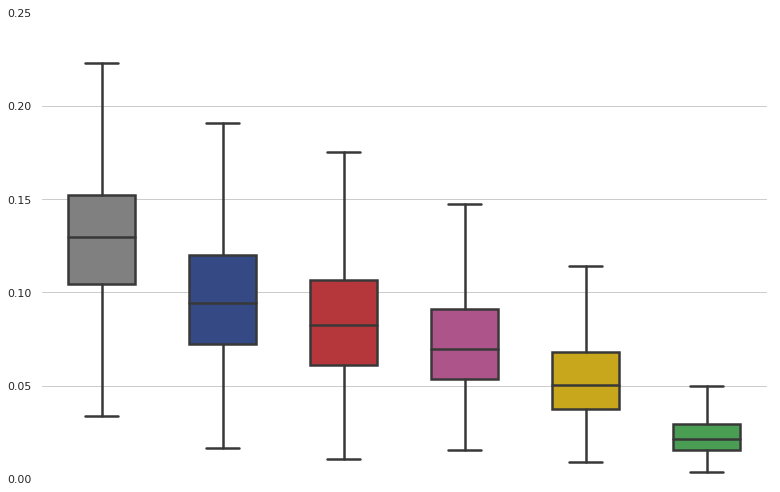

In [88]:
#@title S. cerevisiae Wildtype loss function distribution
plot_sc_wt_loss_distr = True #@param ["False", "True"] {type:"raw"}
save_sc_wt_loss_distr = False #@param ["False", "True"] {type:"raw"}
# plot
if plot_sc_wt_loss_distr:
  # loss plot details
  _sc_wt_loss = {
    "x": "p_vs_q",
    "y": "jsd",
    "data": sc_wt_loss_df_long,
    "palette": {
      "DS_shuffled_NS_shuffled": "#808080",
      "DS_none_NS_native": "#284292",
      "DS_native_NS_none": "#CA2128",
      "DS_native_NS_native": "#BB478D",
      "rep1_rep2": "#3BAC49",
      "rep1_CM": "#e6b800"
    }
  }
  _sc_wt_loss_box = {
    "fliersize": 0,
    "linewidth": 2.5,
    "width": 0.55
  }
  # plot
  F, A = plt.subplots(1, 1, figsize=(11, 7))
  sns.boxplot(**{**_sc_wt_loss, **_sc_wt_loss_box}, ax=A)
  A.set_xticks([])
  A.set_ylim([0, 0.25])
  A.set_xlabel(None)
  A.set_ylabel(None)
  [A.spines[s].set_color(None) for s in ["left", "right", "bottom", "top"]]
  A.ticklabel_format(axis="y", style="sci", useOffset=True)
  plt.grid(axis="y")
  plt.tight_layout()
  if save_sc_wt_loss_distr:
    plt.savefig(_dirs["figs_stats"] + "sc_wt_loss_distr.pdf", format="pdf")
    print("sc_wt_loss_distr.pdf - saved")
  plt.show();

In [93]:
# Summary Statistics of Loss Against Rep. 2
sc_wt_loss_df_wide.describe()

,DS_shuffled_NS_shuffled,DS_none_NS_native,DS_native_NS_none,DS_native_NS_native,rep1_CM,rep1_rep2
count,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000
mean,0.128570,0.098284,0.086507,0.075173,0.057119,0.023683
std,0.036938,0.036739,0.035442,0.031238,0.035818,0.011645
min,0.024231,0.016476,0.010437,0.015295,0.009065,0.003721
25%,0.104591,0.072086,0.061230,0.053676,0.037499,0.015464
50%,0.129725,0.094294,0.082258,0.069826,0.050125,0.021247
75%,0.152261,0.119854,0.106875,0.091153,0.068224,0.029172
max,0.337465,0.360157,0.385954,0.366121,0.623038,0.108203


In [0]:
#@title S. cerevisiae Wildtype binary statistical significance
plot_sc_wt_stat_sig = True #@param ["False", "True"] {type:"raw"}
# plot
if plot_sc_wt_stat_sig:
  F, A = plt.subplots(1, 1, figsize=(9, 7))
  # heatmap details
  _sc_wt_stat_sig = {
    "lbls": [
      "\n".join([x.split("_")[1], x.split("_")[3]])
        for x in sc_wt_loss_df_wide.columns.values[:-1]
    ] + ["rep1_rep2"]
  }
  # heatmaps
  sns.heatmap(
    data=sc_wt_stat_sig > 0.05,
    cbar=False,
    linewidths=2,
    xticklabels=_sc_wt_stat_sig["lbls"],
    yticklabels=_sc_wt_stat_sig["lbls"],
    ax=A
  )
  # show
  plt.tight_layout()
  plt.show();

In [0]:
# all vs all loss fcn statistical significance
sc_wt_stat_sig

,DS_none_NS_shuffled,DS_shuffled_NS_none,DS_shuffled_NS_shuffled,DS_shuffled_NS_native,DS_none_NS_native,DS_native_NS_shuffled,DS_native_NS_none,DS_native_NS_native,rep1_rep2
0,1.000000e+00,1.059138e-04,1.163819e-08,1.147068e-153,5.327293e-160,3.226959e-261,1.550045e-282,0.000000e+00,0.0
1,1.059138e-04,1.000000e+00,6.877991e-02,4.681505e-122,2.946301e-130,1.028414e-225,8.455609e-244,0.000000e+00,0.0
2,1.163819e-08,6.877991e-02,1.000000e+00,1.282357e-107,1.007345e-114,6.697400e-206,2.718032e-225,0.000000e+00,0.0
3,1.147068e-153,4.681505e-122,1.282357e-107,1.000000e+00,6.447014e-01,5.470536e-31,4.831207e-38,2.172096e-91,0.0
4,5.327293e-160,2.946301e-130,1.007345e-114,6.447014e-01,1.000000e+00,1.148758e-24,4.815127e-33,5.499599e-82,0.0
5,3.226959e-261,1.028414e-225,6.697400e-206,5.470536e-31,1.148758e-24,1.000000e+00,1.648819e-01,1.924725e-19,0.0
6,1.550045e-282,8.455609e-244,2.718032e-225,4.831207e-38,4.815127e-33,1.648819e-01,1.000000e+00,7.503773e-15,0.0
7,0.000000e+00,0.000000e+00,0.000000e+00,2.172096e-91,5.499599e-82,1.924725e-19,7.503773e-15,1.000000e+00,0.0
8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0


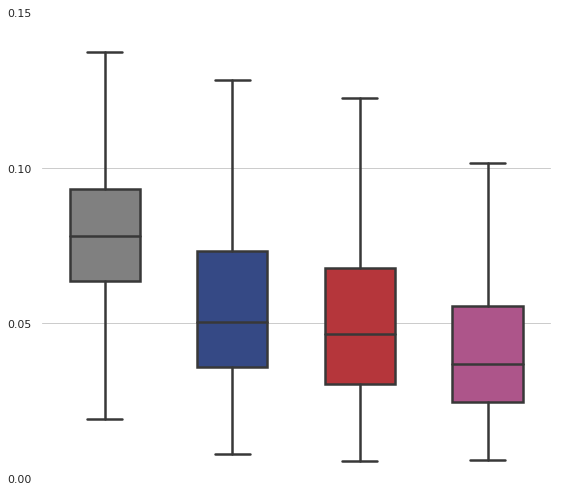

In [95]:
#@title K. lactis loss function distribution
plot_kl_loss_distr = True #@param ["False", "True"] {type:"raw"}
save_kl_loss_distr = False #@param ["False", "True"] {type:"raw"}
# plot
if plot_kl_loss_distr:
  # loss plot details
  _kl_loss = {
    "x": "p_vs_q",
    "y": "jsd",
    "data": kl_loss_df_long,
    "palette": {
      "DS_none_NS_shuffled": "#FFFFFF",
      "DS_shuffled_NS_none": "#FFFFFF",
      "DS_shuffled_NS_shuffled": "#808080",
      "DS_shuffled_NS_native": "#FFFFFF",
      "DS_none_NS_native": "#284292",
      "DS_native_NS_shuffled": "#FFFFFF",
      "DS_native_NS_none": "#CA2128",
      "DS_native_NS_native": "#BB478D"
    },
    "fliersize": 0,
    "linewidth": 2.5,
    "width": 0.55   
  }
  # plot
  F, A = plt.subplots(1, 1, figsize=(8, 7))
  sns.boxplot(**_kl_loss, ax=A)
  A.set_xticks([])
  A.set_ylim([0, 0.15])
  A.set_yticks([0, 0.05, 0.10, 0.15])
  A.set_xlabel(None)
  A.set_ylabel(None)
  [A.spines[s].set_color(None) for s in ["left", "right", "bottom", "top"]]
  A.ticklabel_format(axis="y", style="sci", useOffset=True)
  plt.grid(axis="y")
  plt.tight_layout()
  if save_kl_loss_distr:
    plt.savefig(_dirs["figs_stats"] + "kl_loss_distr.pdf", format="pdf")
    print("kl_loss_distr.pdf - saved")
  plt.show();

In [92]:
kl_loss_df_wide.describe()

,DS_shuffled_NS_shuffled,DS_none_NS_native,DS_native_NS_none,DS_native_NS_native
count,2396.000000,2396.000000,2396.000000,2396.000000
mean,0.082291,0.059946,0.055733,0.046566
std,0.040990,0.044049,0.044400,0.041964
min,0.016218,0.007988,0.005826,0.006100
25%,0.063519,0.036066,0.030415,0.024812
50%,0.078094,0.050425,0.046699,0.036953
75%,0.093428,0.073203,0.067772,0.055666
max,0.501200,0.515683,0.503402,0.492679


In [0]:
#@title K. lactis binary statistical significance
plot_kl_stat_sig = True #@param ["False", "True"] {type:"raw"}
# plot
if plot_kl_stat_sig:
  F, A = plt.subplots(1, 1, figsize=(9, 7))
  # heatmap details
  _kl_stat_sig = {
    "lbls": [
      "\n".join([x.split("_")[1], x.split("_")[3]])
        for x in kl_loss_df_wide.columns.values[:-1]
    ]
  }
  # heatmaps
  sns.heatmap(
    data=kl_stat_sig > 0.05,
    cbar=False,
    linewidths=2,
    xticklabels=_kl_stat_sig["lbls"],
    yticklabels=_kl_stat_sig["lbls"],
    ax=A
  )
  # show
  plt.tight_layout()
  plt.show();

In [0]:
# all vs all loss fcn statistical significance
kl_stat_sig

,DS_none_NS_shuffled,DS_shuffled_NS_none,DS_shuffled_NS_shuffled,DS_shuffled_NS_native,DS_none_NS_native,DS_native_NS_shuffled,DS_native_NS_none,DS_native_NS_native
0,1.000000e+00,4.962720e-14,5.726929e-18,3.213469e-166,2.416753e-179,8.509690e-245,2.923326e-275,0.000000e+00
1,4.962720e-14,1.000000e+00,2.544669e-01,1.008573e-118,8.587785e-142,1.058189e-206,2.457811e-239,0.000000e+00
2,5.726929e-18,2.544669e-01,1.000000e+00,1.983496e-118,2.489699e-137,2.643736e-201,1.593044e-233,0.000000e+00
3,3.213469e-166,1.008573e-118,1.983496e-118,1.000000e+00,2.042310e-03,1.417283e-36,3.621804e-50,2.014402e-106
4,2.416753e-179,8.587785e-142,2.489699e-137,2.042310e-03,1.000000e+00,1.561089e-22,6.190093e-33,1.664322e-78
5,8.509690e-245,1.058189e-206,2.643736e-201,1.417283e-36,1.561089e-22,1.000000e+00,1.777836e-02,7.035387e-25
6,2.923326e-275,2.457811e-239,1.593044e-233,3.621804e-50,6.190093e-33,1.777836e-02,1.000000e+00,7.702926e-15
7,0.000000e+00,0.000000e+00,0.000000e+00,2.014402e-106,1.664322e-78,7.035387e-25,7.702926e-15,1.000000e+00


### MNase-seq

#### canonical meta

In [0]:
#@title K. lactis
plot_kl_ms_meta = True #@param ["False", "True"] {type:"raw"}
show_kl_neg_ctrls = False #@param ["False", "True"] {type:"raw"}
save_kl_ms_meta = False #@param ["False", "True"] {type:"raw"}
# meta plot details
_kl_ms_meta = {
  "kl_MS_1": {
    "color": "#47A677",
    "label": "rep. 1",
    "linestyle": "-",
    "linewidth": 1.8,
    "alpha": 0.65
  },
  "kl_DS_shuffled_NS_native": {
    "color": "#B49FFA",
    "label": "shuffled native",
    "linestyle": (0, (5, 1.5)),
    "linewidth": 1.6,
    "alpha": 0.8
  },
  "kl_DS_none_NS_native": {
    "color": "#6060FD",
    "label": "absent native",
    "linestyle": "-",
    "linewidth": 1.6,
    "alpha": 0.8
  },
  "kl_DS_native_NS_none": {
    "color": "#F5271C",
    "label": "native absent",
    "linestyle": "-",
    "linewidth": 1.6,
    "alpha": 0.8
  },
  "kl_DS_native_NS_shuffled": {
    "color": "#ec1358",
    "label": "native shuffled",
    "linestyle": (0, (5, 1.5)),
    "linewidth": 1.6,
    "alpha": 0.8
  },
  "kl_DS_native_NS_native": {
    "color": "#8D05B7",
    "label": "native native",
    "linestyle": "-",
    "linewidth": 3.0,
    "alpha": 0.65
  }
}
# plot negative controls
if show_kl_neg_ctrls:
  for neg_ctrl in [
    "kl_DS_shuffled_NS_shuffled",
    "kl_DS_shuffled_NS_none",
    "kl_DS_none_NS_shuffled"
  ]: _kl_ms_meta.update({
    neg_ctrl: {
      "color": "k",
      "label": " ".join([neg_ctrl.split("_")[2], neg_ctrl.split("_")[4]]),
      "linestyle": "-",
      "linewidth": 0.8,
      "alpha": 0.5
    }
  })
# plot
if plot_kl_ms_meta:
  F, A = plt.subplots(1, 1, figsize=(11, 7))
  # measured and predicted
  for i, details in _kl_ms_meta.items():
    A.plot(agg_ms_meta[i].values, **details)
  # ancillary
  A.set_yticks([])
  A.set_ylabel(None)
  A.set_xticks(np.linspace(0, 1024, 9))
  A.set_xlim([0, 1024])
  A.set_xticklabels([""] * 9)
  [A.spines[s].set_color(None) for s in ["left", "top", "right"]]
  plt.grid(axis="x")
  plt.legend(loc=2)
  plt.tight_layout()
  if save_kl_ms_meta:
    plt.savefig(_dirs["figs_stats"] + "kl_ms_meta.pdf", format="pdf")
    print("kl_ms_meta.pdf - saved")
  plt.show();

In [0]:
#@title S. cerevisiae wt
plot_sc_wt_ms_meta = True #@param ["False", "True"] {type:"raw"}
show_sc_wt_neg_ctrls = False #@param ["False", "True"] {type:"raw"}
save_sc_wt_ms_meta = False #@param ["False", "True"] {type:"raw"}
# meta plot details
_sc_wt_ms_meta = {
  "sc_MS_wt_1": {
    "color": "#47A677",
    "label": "rep. 1",
    "linestyle": "-",
    "linewidth": 1.8,
    "alpha": 0.65
  },
  "sc_MS_wt_2": {
    "color": "#10A105",
    "label": "rep. 2",
    "linestyle": "-",
    "linewidth": 1.8,
    "alpha": 0.65
  },
  "sc_MS_wt_4": {
    "color": "#e6b800",
    "label": "chemical mapping",
    "linestyle": "-",
    "linewidth": 1.8,
    "alpha": 0.65
  },
#   "sc_N_wt_DS_shuffled_NS_native": {
#     "color": "#B49FFA",
#     "label": "shuffled native",
#     "linestyle": (0, (5, 1.5)),
#     "linewidth": 1.6,
#     "alpha": 0.8
#   },
  "sc_N_wt_DS_none_NS_native": {
    "color": "#6060FD",
    "label": "absent native",
    "linestyle": "-",
    "linewidth": 1.6,
    "alpha": 0.8
  },
  "sc_N_wt_DS_native_NS_none": {
    "color": "#F5271C",
    "label": "native absent",
    "linestyle": "-",
    "linewidth": 1.6,
    "alpha": 0.8
  },
#   "sc_N_wt_DS_native_NS_shuffled": {
#     "color": "#ec1358",
#     "label": "native shuffled",
#     "linestyle": (0, (5, 1.5)),
#     "linewidth": 1.6,
#     "alpha": 0.8
#   },
  "sc_N_wt_DS_native_NS_native": {
    "color": "#8D05B7",
    "label": "native native",
    "linestyle": "-",
    "linewidth": 3.0,
    "alpha": 0.65
  }
}
# plot negative controls
if show_sc_wt_neg_ctrls:
  for neg_ctrl in [
    "sc_N_wt_DS_shuffled_NS_shuffled",
    "sc_N_wt_DS_shuffled_NS_none",
    "sc_N_wt_DS_none_NS_shuffled"
  ]: _sc_wt_ms_meta.update({
    neg_ctrl: {
      "color": "k",
      "label": " ".join([neg_ctrl.split("_")[4], neg_ctrl.split("_")[6]]),
      "linestyle": "-",
      "linewidth": 0.8,
      "alpha": 0.5
    }
  })
# plot
if plot_sc_wt_ms_meta:
  F, A = plt.subplots(1, 1, figsize=(11, 7))
  # measured and predicted
  for i, details in _sc_wt_ms_meta.items():
    A.plot(agg_ms_meta[i].values, **details)
  # ancillary
  A.set_yticks([])
  A.set_ylabel(None)
  A.set_xticks(np.linspace(0, 1024, 9))
  A.set_xlim([0, 1024])
  A.set_xticklabels([""] * 9)
  [A.spines[s].set_color(None) for s in ["left", "top", "right"]]
  plt.grid(axis="x")
  plt.legend(loc=2)
  plt.tight_layout()
  if save_sc_wt_ms_meta:
    plt.savefig(_dirs["figs_stats"] + "sc_wt_ms_meta.pdf", format="pdf")
    print("sc_wt_ms_meta.pdf - saved")
  plt.show();

#### ridge-line meta

In [0]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

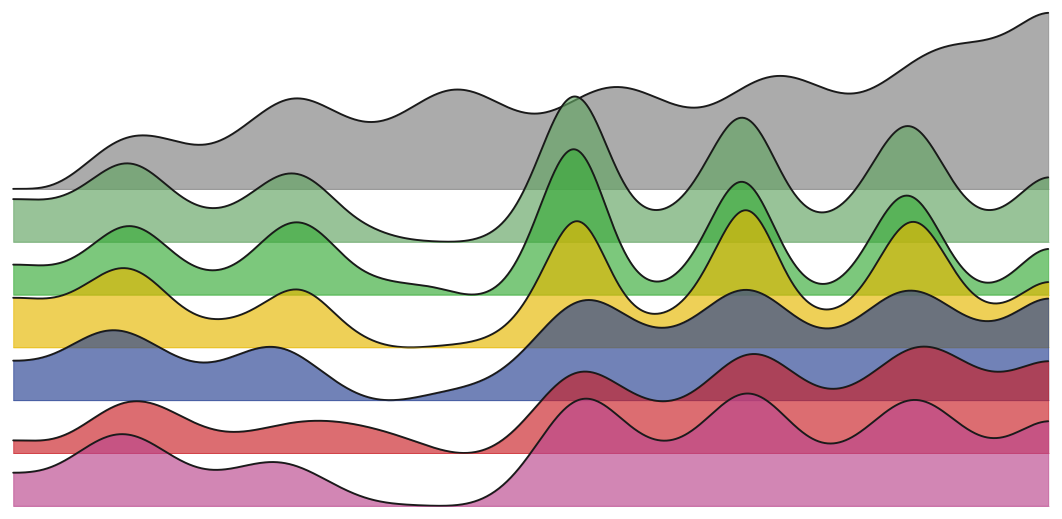

In [128]:
#@title S. cerevisiae wt
plot_sc_wt_ms_ridge_meta = True #@param ["False", "True"] {type:"raw"}
save_sc_wt_ms_ridge_meta = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_wt_ms_meta_ridge_column_palettes = {
  "sc_N_wt_DS_shuffled_NS_shuffled": "#808080",
  "sc_MS_wt_1": "#63a463",
  "sc_MS_wt_2": "#39ac39",
  "sc_MS_wt_4": "#e6b800",
  "sc_N_wt_DS_none_NS_native": "#284292",
  "sc_N_wt_DS_native_NS_none": "#CA2128",
  "sc_N_wt_DS_native_NS_native": "#BB478D"
}
sc_wt_ms_meta_ridge_long = pd.concat([
  pd.DataFrame({
    "col": np.repeat(col, 1024),
    "x": np.arange(1024),
    "val": agg_ms_meta[col].values,
  }) for col in sc_wt_ms_meta_ridge_column_palettes.keys()
], 0)
# plot
if plot_sc_wt_ms_ridge_meta:
  # initialize
  g = sns.FacetGrid(
    data=sc_wt_ms_meta_ridge_long,
    row="col",
    hue="col",
    aspect=14,
    sharex=True,
    sharey=True,
    xlim=(0, 1024),
    ylim=(0, np.max(sc_wt_ms_meta_ridge_long["val"].values)),
    height=1.1,
    palette=sc_wt_ms_meta_ridge_column_palettes.values()
  )
  # map to facet grid
  g.map(plt.fill_between, "x", "val", alpha=0.66, clip_on=False)
  g.map(plt.plot, "val", linewidth=1.9, color="k", clip_on=False)
  g.map(plt.axhline, y=0, linewidth=0.5, alpha=0.66, clip_on=False)
  # ancillary
  g.fig.subplots_adjust(hspace=-.7)
  g.set_titles("")
  g.set(xticks=[])
  g.set(yticks=[])
  g.despine(bottom=True, left=True);
  if save_sc_wt_ms_ridge_meta:
    plt.savefig(_dirs["figs_stats"] + "sc_wt_ms_ridge_meta.pdf", format="pdf")
    print("sc_wt_ms_ridge_meta.pdf - saved")

In [0]:
#@title S. cerevisiae wt nuc maxima
plot_sc_wt_nuc_maxima = True #@param ["False", "True"] {type:"raw"}
save_sc_wt_nuc_maxima = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_wt_nuc_maxima = {
  "DS_shuffled_NS_shuffled": {
    "val": nuc_data["sc_N_wt_DS_shuffled_NS_shuffled"],
    "clr": "#808080"
  },
  "MS_1": {
    "val": nuc_data["sc_MS_1"],
    "clr": "#63a463"
  },
  "MS_2": {
    "val": nuc_data["sc_MS_2"],
    "clr": "#39ac39"
  },
  "DS_none_NS_native": {
    "val": nuc_data["sc_N_wt_DS_none_NS_native"],
    "clr": "#284292"
  },
  "DS_native_NS_none": {
    "val": nuc_data["sc_N_wt_DS_native_NS_none"],
    "clr": "#CA2128"
  },
  "DS_native_NS_native": {
    "val": nuc_data["sc_N_wt_DS_native_NS_native"],
    "clr": "#BB478D"
  }
}
# plot
if plot_sc_wt_nuc_maxima:
  F, A = plt.subplots(1, 1, figsize=(12 * 1.2, 7))
  for i, x in enumerate(sc_wt_nuc_maxima):
    plt.scatter(
      x=sc_wt_nuc_maxima[x]["val"],
      y=(1 - 0.1 * i) * np.ones(5),
      c=sc_wt_nuc_maxima[x]["clr"],
      s=300,
      marker="|"
    ) 
  # ancillary
  A.set_xlim([0, 1024])
  A.set_ylabel(None)
  A.set_xticklabels([""] * 9)
  A.set_yticklabels([""] * 9)
  [A.spines[s].set_color(None) for s in ["left", "top", "right", "bottom"]]
  plt.grid(axis="y")
  plt.tight_layout()
  if save_sc_wt_nuc_maxima:
    plt.savefig(_dirs["figs_stats"] + "sc_wt_nuc_maxima.pdf", format="pdf")
    print("sc_wt_nuc_maxima.pdf - saved")
  plt.show();

In [0]:
#@title S. cerevisiae Δ ISW1
plot_sc_ko_isw1_ms_ridge_meta = True #@param ["False", "True"] {type:"raw"}
save_sc_ko_isw1_ms_ridge_meta = False #@param ["False", "True"] {type:"raw"}
sys.exit(1)
# meta plot details
sc_ko_isw1_ms_meta_ridge_column_palettes = {
  "sc_N_ko_isw1_DS_shuffled_NS_shuffled": "#808080",
  "sc_N_ko_isw1_DS_none_NS_native": "#284292",
  "sc_N_ko_isw1_DS_native_NS_none": "#CA2128",
  "sc_N_ko_isw1_DS_native_NS_native": "#BB478D"
}
sc_ko_isw1_ms_meta_ridge_long = pd.concat([
  pd.DataFrame({
    "col": np.repeat(col, 1024),
    "x": np.arange(1024),
    "val": agg_ms_meta[col].values
  }) for col in sc_ko_isw1_ms_meta_ridge_column_palettes.keys()
], 0)
# plot
if plot_sc_ko_isw1_ms_ridge_meta:
  # initialize
  g = sns.FacetGrid(
    data=sc_ko_isw1_ms_meta_ridge_long,
    row="col",
    hue="col",
    aspect=12,
    sharex=True,
    sharey=True,
    xlim=(0, 1024),
    ylim=(0, np.max(sc_ko_isw1_ms_meta_ridge_long["val"].values)),
    height=1.2,
    palette=sc_ko_isw1_ms_meta_ridge_column_palettes.values()
  )
  # map to facet grid
  g.map(plt.fill_between, "x", "val", alpha=0.66, clip_on=False)
  g.map(plt.plot, "val", linewidth=2.1, color="k", clip_on=False)
  g.map(plt.axhline, y=0, linewidth=0.5, alpha=0.66, clip_on=False)
  # ancillary
  g.fig.subplots_adjust(hspace=-.8)
  g.set_titles("")
  g.set(xticks=[])
  g.set(yticks=[])
  g.despine(bottom=True, left=True);
  if save_sc_ko_isw1_ms_ridge_meta:
    plt.savefig(
      fname=_dirs["figs_stats"] + "sc_ko_isw1_ms_ridge_meta.pdf",
      format="pdf"
    )
    print("sc_ko_isw1_ms_ridge_meta.pdf - saved")

In [0]:
#@title S. cerevisiae Δ ISW1 nuc maxima
plot_sc_ko_isw1_nuc_maxima = False #@param ["False", "True"] {type:"raw"}
save_sc_ko_isw1_nuc_maxima = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_ko_isw1_nuc_maxima = {
  "DS_shuffled_NS_shuffled": {
    "val": nuc_data["sc_N_ko_isw1_DS_shuffled_NS_shuffled"],
    "clr": "#808080"
  },
  "DS_none_NS_native": {
    "val": nuc_data["sc_N_ko_isw1_DS_none_NS_native"],
    "clr": "#284292"
  },
  "DS_native_NS_none": {
    "val": nuc_data["sc_N_ko_isw1_DS_native_NS_none"],
    "clr": "#CA2128"
  },
  "DS_native_NS_native": {
    "val": nuc_data["sc_N_ko_isw1_DS_native_NS_native"],
    "clr": "#BB478D"
  }
}
# plot
if plot_sc_ko_isw1_nuc_maxima:
  F, A = plt.subplots(1, 1, figsize=(12 * 1.2, 7))
  for i, x in enumerate(sc_ko_isw1_nuc_maxima):
    plt.scatter(
      x=sc_ko_isw1_nuc_maxima[x]["val"],
      y=(1 - 0.1 * i) * np.ones(5),
      c=sc_ko_isw1_nuc_maxima[x]["clr"],
      s=300,
      marker="|"
    ) 
  # ancillary
  A.set_xlim([0, 1024])
  A.set_ylabel(None)
  A.set_xticklabels([""] * 9)
  A.set_yticklabels([""] * 9)
  [A.spines[s].set_color(None) for s in ["left", "top", "right", "bottom"]]
  plt.grid(axis="y")
  plt.tight_layout()
  if save_sc_ko_isw1_nuc_maxima:
    plt.savefig(_dirs["figs_stats"] + "sc_ko_isw1_nuc_maxima.pdf", format="pdf")
    print("sc_ko_isw1_nuc_maxima.pdf - saved")
  plt.show();

In [0]:
#@title S. cerevisiae Δ CHD1
plot_sc_ko_chd1_ms_ridge_meta = False #@param ["False", "True"] {type:"raw"}
save_sc_ko_chd1_ms_ridge_meta = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_ko_chd1_ms_meta_ridge_column_palettes = {
  "sc_N_ko_chd1_DS_shuffled_NS_shuffled": "#808080",
  "sc_N_ko_chd1_DS_none_NS_native": "#284292",
  "sc_N_ko_chd1_DS_native_NS_none": "#CA2128",
  "sc_N_ko_chd1_DS_native_NS_native": "#BB478D"
}
sc_ko_chd1_ms_meta_ridge_long = pd.concat([
  pd.DataFrame({
    "col": np.repeat(col, 1024),
    "x": np.arange(1024),
    "val": agg_ms_meta[col].values
  }) for col in sc_ko_chd1_ms_meta_ridge_column_palettes.keys()
], 0)
# plot
if plot_sc_ko_chd1_ms_ridge_meta:
  # initialize
  g = sns.FacetGrid(
    data=sc_ko_chd1_ms_meta_ridge_long,
    row="col",
    hue="col",
    aspect=12,
    sharex=True,
    sharey=True,
    xlim=(0, 1024),
    ylim=(0, np.max(sc_ko_chd1_ms_meta_ridge_long["val"].values)),
    height=1.2,
    palette=sc_ko_chd1_ms_meta_ridge_column_palettes.values()
  )
  # map to facet grid
  g.map(plt.fill_between, "x", "val", alpha=0.66, clip_on=False)
  g.map(plt.plot, "val", linewidth=2.1, color="k", clip_on=False)
  g.map(plt.axhline, y=0, linewidth=0.5, alpha=0.66, clip_on=False)
  # ancillary
  g.fig.subplots_adjust(hspace=-.8)
  g.set_titles("")
  g.set(xticks=[])
  g.set(yticks=[])
  g.despine(bottom=True, left=True);
  if save_sc_ko_chd1_ms_ridge_meta:
    plt.savefig(
      fname=_dirs["figs_stats"] + "sc_ko_chd1_ms_ridge_meta.pdf",
      format="pdf"
    )
    print("sc_ko_chd1_ms_ridge_meta.pdf - saved")

In [0]:
#@title S. cerevisiae Δ CHD1 nuc maxima
plot_sc_ko_chd1_nuc_maxima = True #@param ["False", "True"] {type:"raw"}
save_sc_ko_chd1_nuc_maxima = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_ko_chd1_nuc_maxima = {
  "DS_shuffled_NS_shuffled": {
    "val": nuc_data["sc_N_ko_chd1_DS_shuffled_NS_shuffled"],
    "clr": "#808080"
  },
  "DS_none_NS_native": {
    "val": nuc_data["sc_N_ko_chd1_DS_none_NS_native"],
    "clr": "#284292"
  },
  "DS_native_NS_none": {
    "val": nuc_data["sc_N_ko_chd1_DS_native_NS_none"],
    "clr": "#CA2128"
  },
  "DS_native_NS_native": {
    "val": nuc_data["sc_N_ko_chd1_DS_native_NS_native"],
    "clr": "#BB478D"
  }
}
# plot
if plot_sc_ko_chd1_nuc_maxima:
  F, A = plt.subplots(1, 1, figsize=(12 * 1.2, 7))
  for i, x in enumerate(sc_ko_chd1_nuc_maxima):
    plt.scatter(
      x=sc_ko_chd1_nuc_maxima[x]["val"],
      y=(1 - 0.1 * i) * np.ones(5),
      c=sc_ko_chd1_nuc_maxima[x]["clr"],
      s=300,
      marker="|"
    ) 
  # ancillary
  A.set_xlim([0, 1024])
  A.set_ylabel(None)
  A.set_xticklabels([""] * 9)
  A.set_yticklabels([""] * 9)
  [A.spines[s].set_color(None) for s in ["left", "top", "right", "bottom"]]
  plt.grid(axis="y")
  plt.tight_layout()
  if save_sc_ko_chd1_nuc_maxima:
    plt.savefig(_dirs["figs_stats"] + "sc_ko_chd1_nuc_maxima.pdf", format="pdf")
    print("sc_ko_chd1_nuc_maxima.pdf - saved")
  plt.show();

In [0]:
#@title S. cerevisiae Δ INO80
plot_sc_ko_ino80_ms_ridge_meta = True #@param ["False", "True"] {type:"raw"}
save_sc_ko_ino80_ms_ridge_meta = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_ko_ino80_ms_meta_ridge_column_palettes = {
  "sc_N_ko_ino80_DS_shuffled_NS_shuffled": "#808080",
  "sc_N_ko_ino80_DS_none_NS_native": "#284292",
  "sc_N_ko_ino80_DS_native_NS_none": "#CA2128",
  "sc_N_ko_ino80_DS_native_NS_native": "#BB478D"
}
sc_ko_ino80_ms_meta_ridge_long = pd.concat([
  pd.DataFrame({
    "col": np.repeat(col, 1024),
    "x": np.arange(1024),
    "val": agg_ms_meta[col].values
  }) for col in sc_ko_ino80_ms_meta_ridge_column_palettes.keys()
], 0)
# plot
if plot_sc_ko_ino80_ms_ridge_meta:
  # initialize
  g = sns.FacetGrid(
    data=sc_ko_ino80_ms_meta_ridge_long,
    row="col",
    hue="col",
    aspect=12,
    sharex=True,
    sharey=True,
    xlim=(0, 1024),
    ylim=(0, np.max(sc_ko_ino80_ms_meta_ridge_long["val"].values)),
    height=1.2,
    palette=sc_ko_ino80_ms_meta_ridge_column_palettes.values()
  )
  # map to facet grid
  g.map(plt.fill_between, "x", "val", alpha=0.66, clip_on=False)
  g.map(plt.plot, "val", linewidth=2.1, color="k", clip_on=False)
  g.map(plt.axhline, y=0, linewidth=0.5, alpha=0.66, clip_on=False)
  # ancillary
  g.fig.subplots_adjust(hspace=-.8)
  g.set_titles("")
  g.set(xticks=[])
  g.set(yticks=[])
  g.despine(bottom=True, left=True);
  if save_sc_ko_ino80_ms_ridge_meta:
    plt.savefig(
      fname=_dirs["figs_stats"] + "sc_ko_ino80_ms_ridge_meta.pdf",
      format="pdf"
    )
    print("sc_ko_ino80_ms_ridge_meta.pdf - saved")

In [0]:
#@title S. cerevisiae Δ INO80 nuc maxima
plot_sc_ko_ino80_nuc_maxima = True #@param ["False", "True"] {type:"raw"}
save_sc_ko_ino80_nuc_maxima = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_ko_ino80_nuc_maxima = {
  "DS_shuffled_NS_shuffled": {
    "val": nuc_data["sc_N_ko_ino80_DS_shuffled_NS_shuffled"],
    "clr": "#808080"
  },
  "DS_none_NS_native": {
    "val": nuc_data["sc_N_ko_ino80_DS_none_NS_native"],
    "clr": "#284292"
  },
  "DS_native_NS_none": {
    "val": nuc_data["sc_N_ko_ino80_DS_native_NS_none"],
    "clr": "#CA2128"
  },
  "DS_native_NS_native": {
    "val": nuc_data["sc_N_ko_ino80_DS_native_NS_native"],
    "clr": "#BB478D"
  }
}
# plot
if plot_sc_ko_ino80_nuc_maxima:
  F, A = plt.subplots(1, 1, figsize=(12 * 1.2, 7))
  for i, x in enumerate(sc_ko_ino80_nuc_maxima):
    plt.scatter(
      x=sc_ko_ino80_nuc_maxima[x]["val"],
      y=(1 - 0.1 * i) * np.ones(5),
      c=sc_ko_ino80_nuc_maxima[x]["clr"],
      s=300,
      marker="|"
    ) 
  # ancillary
  A.set_xlim([0, 1024])
  A.set_ylabel(None)
  A.set_xticklabels([""] * 9)
  A.set_yticklabels([""] * 9)
  [A.spines[s].set_color(None) for s in ["left", "top", "right", "bottom"]]
  plt.grid(axis="y")
  plt.tight_layout()
  if save_sc_ko_ino80_nuc_maxima:
    plt.savefig(_dirs["figs_stats"] + "sc_ko_ino80_nuc_maxima.pdf", format="pdf")
    print("sc_ko_ino80_nuc_maxima.pdf - saved")
  plt.show();

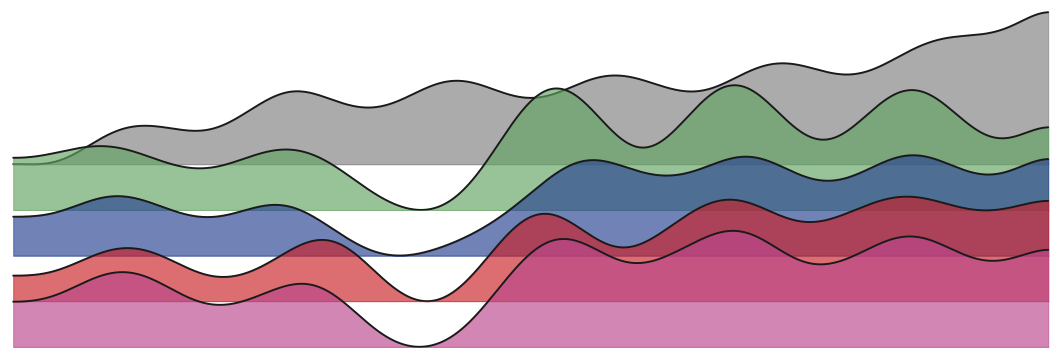

In [129]:
#@title K. lactis
plot_kl_ms_ridge_meta = True #@param ["False", "True"] {type:"raw"}
save_kl_ms_ridge_meta = False #@param ["False", "True"] {type:"raw"}
# meta plot details
kl_ms_meta_ridge_column_palettes = {
  "kl_DS_shuffled_NS_shuffled": "#808080",
  "kl_MS_1": "#63a463",
  "kl_DS_none_NS_native": "#284292",
  "kl_DS_native_NS_none": "#CA2128",
  "kl_DS_native_NS_native": "#BB478D"
}
kl_ms_meta_ridge_long = pd.concat([
  pd.DataFrame({
    "col": np.repeat(col, 1024),
    "x": np.arange(1024),
    "val": agg_ms_meta[col].values,
  }) for col in kl_ms_meta_ridge_column_palettes.keys()
], 0)
# plot
if plot_kl_ms_ridge_meta:
  # initialize
  g = sns.FacetGrid(
    data=kl_ms_meta_ridge_long,
    row="col",
    hue="col",
    aspect=14,
    sharex=True,
    sharey=True,
    xlim=(0, 1024),
    ylim=(0, np.max(kl_ms_meta_ridge_long["val"].values)),
    height=1.1,
    palette=kl_ms_meta_ridge_column_palettes.values()
  )
  # map to facet grid
  g.map(plt.fill_between, "x", "val", alpha=0.66, clip_on=False)
  g.map(plt.plot, "val", linewidth=1.9, color="k", clip_on=False)
  g.map(plt.axhline, y=0, linewidth=0.5, alpha=0.66, clip_on=False)
  # ancillary
  g.fig.subplots_adjust(hspace=-.7)
  g.set_titles("")
  g.set(xticks=[])
  g.set(yticks=[])
  g.despine(bottom=True, left=True);
  if save_kl_ms_ridge_meta:
    plt.savefig(_dirs["figs_stats"] + "kl_ms_ridge_meta.pdf", format="pdf")
    print("kl_ms_ridge_meta.pdf - saved")

In [0]:
#@title K. lactis nuc maxima
plot_kl_nuc_maxima = True #@param ["False", "True"] {type:"raw"}
save_kl_nuc_maxima = False #@param ["False", "True"] {type:"raw"}
# meta plot details
kl_nuc_maxima = {
  "DS_shuffled_NS_shuffled": {
    "val": nuc_data["kl_DS_shuffled_NS_shuffled"],
    "clr": "#808080"
  },
  "MS_1": {
    "val": nuc_data["kl_MS_1"],
    "clr": "#63a463"
  },
  "DS_none_NS_native": {
    "val": nuc_data["kl_DS_none_NS_native"],
    "clr": "#284292"
  },
  "DS_native_NS_none": {
    "val": nuc_data["kl_DS_native_NS_none"],
    "clr": "#CA2128"
  },
  "DS_native_NS_native": {
    "val": nuc_data["kl_DS_native_NS_native"],
    "clr": "#BB478D"
  }
}
# plot
if plot_kl_nuc_maxima:
  F, A = plt.subplots(1, 1, figsize=(12 * 1.2, 7))
  for i, x in enumerate(kl_nuc_maxima):
    plt.scatter(
      x=kl_nuc_maxima[x]["val"],
      y=(1 - 0.1 * i) * np.ones(5),
      c=kl_nuc_maxima[x]["clr"],
      s=300,
      marker="|"
    ) 
  # ancillary
  A.set_xlim([0, 1024])
  A.set_ylabel(None)
  A.set_xticklabels([""] * 9)
  A.set_yticklabels([""] * 9)
  [A.spines[s].set_color(None) for s in ["left", "top", "right", "bottom"]]
  plt.grid(axis="y")
  plt.tight_layout()
  if save_kl_nuc_maxima:
    plt.savefig(_dirs["figs_stats"] + "kl_nuc_maxima.pdf", format="pdf")
    print("kl_nuc_maxima.pdf - saved")
  plt.show();

#### heatmap meta

In [0]:
#@title Sc wt
plot_sc_wt_ms_heatmap = True #@param ["False", "True"] {type:"raw"}
save_sc_wt_ms_heatmap = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_wt_ms_heatmap_sort_idx = np.argsort(
  np.sum(agg_ns_data["sc_wt"][:, 0, :], 1)
)[::-1]
sc_wt_ms_heatmap_data = {
  "wt_DS_shuffled_NS_shuffled": np.array([x
    for x in agg_ms_data["sc"]["pred"]["N_wt"]["DS_shuffled_NS_shuffled"]["avg"]
  ])[sc_wt_ms_heatmap_sort_idx, :],
  "wt_DS_none_NS_native": np.array([x
    for x in agg_ms_data["sc"]["pred"]["N_wt"]["DS_none_NS_native"]["avg"]
  ])[sc_wt_ms_heatmap_sort_idx, :],
  "wt_DS_native_NS_none": np.array([x
    for x in agg_ms_data["sc"]["pred"]["N_wt"]["DS_native_NS_none"]["avg"]
  ])[sc_wt_ms_heatmap_sort_idx, :],
  "wt_DS_native_NS_native": np.array([x
    for x in agg_ms_data["sc"]["pred"]["N_wt"]["DS_native_NS_native"]["avg"]
  ])[sc_wt_ms_heatmap_sort_idx, :],
  "wt_1": np.array([_np_ms_transform(x)
    for x in agg_ms_data["sc"]["meas"]["MS_1"]
  ])[sc_wt_ms_heatmap_sort_idx, :],
  "wt_2": np.array([_np_ms_transform(x)
    for x in agg_ms_data["sc"]["meas"]["MS_2"]
  ])[sc_wt_ms_heatmap_sort_idx, :]
}
sc_wt_ms_heatmap_extrema = {
  "min": np.min(np.concatenate([
    x for x in sc_wt_ms_heatmap_data.values()
  ])),
  "max": np.max(np.concatenate([
    x for x in sc_wt_ms_heatmap_data.values()
  ]))
}
if plot_sc_wt_ms_heatmap:
  F, A = plt.subplots(1, len(sc_wt_ms_heatmap_data), figsize=(12, 10))
  for i, (m, m_data) in enumerate(sc_wt_ms_heatmap_data.items()):
    print(i, m)
    sns.heatmap(
      data=m_data,
      cbar=False,
      vmin=sc_wt_ms_heatmap_extrema["min"],
      vmax=sc_wt_ms_heatmap_extrema["max"],
      cmap="ocean_r",
      ax=A[i]
    )
    A[i].set_xticks([]); A[i].set_yticks([])
    A[i].set_title(m, fontdict={"fontsize": 8})
  plt.tight_layout(w_pad=-0.3)
  if save_sc_wt_ms_heatmap:
    plt.savefig(
      fname=_dirs["figs_stats"] + "sc_wt_ms_meta_heatmap.png",
      format="png",
      dpi=1024
    )
    print("sc_wt_ms_meta_heatmap.png - saved")
  plt.show();

In [0]:
#@title Sc ko
ko = "chd1" #@param ["isw1", "ino80", "chd1"]
plot_sc_ko_ms_heatmap = True #@param ["False", "True"] {type:"raw"}
save_sc_ko_ms_heatmap = False #@param ["False", "True"] {type:"raw"}
# meta plot details
sc_ko_ms_heatmap_sort_idx = np.argsort(
  np.sum(agg_ns_data["sc_ko_" + ko][:, 0, :], 1)
)[::-1]
sc_ko_ms_heatmap_data = {
  "ko_DS_shuffled_NS_shuffled": np.array([x
    for x in agg_ms_data[
      "sc"]["pred"]["N_ko_" + ko]["DS_shuffled_NS_shuffled"]["avg"]
  ])[sc_ko_ms_heatmap_sort_idx, :],
  "ko_DS_none_NS_native": np.array([x
    for x in agg_ms_data[
      "sc"]["pred"]["N_ko_" + ko]["DS_none_NS_native"]["avg"]
  ])[sc_ko_ms_heatmap_sort_idx, :],
  "ko_DS_native_NS_none": np.array([x
    for x in agg_ms_data[
      "sc"]["pred"]["N_ko_" + ko]["DS_native_NS_none"]["avg"]
  ])[sc_ko_ms_heatmap_sort_idx, :],
  "ko_DS_native_NS_native": np.array([x
    for x in agg_ms_data[
      "sc"]["pred"]["N_ko_" + ko]["DS_native_NS_native"]["avg"]
  ])[sc_ko_ms_heatmap_sort_idx, :]
}
sc_ko_ms_heatmap_extrema = {
  "min": np.min(np.concatenate([
    x for x in sc_ko_ms_heatmap_data.values()
  ])),
  "max": np.max(np.concatenate([
    x for x in sc_ko_ms_heatmap_data.values()
  ]))
}
if plot_sc_ko_ms_heatmap:
  F, A = plt.subplots(1, len(sc_ko_ms_heatmap_data), figsize=(8, 10))
  for i, (m, m_data) in enumerate(sc_ko_ms_heatmap_data.items()):
    print(i, m)
    sns.heatmap(
      data=m_data,
      cbar=False,
      vmin=sc_ko_ms_heatmap_extrema["min"],
      vmax=sc_ko_ms_heatmap_extrema["max"],
      cmap="ocean_r",
      ax=A[i]
    )
    A[i].set_xticks([]); A[i].set_yticks([])
    A[i].set_title(m, fontdict={"fontsize": 8})
  plt.tight_layout(w_pad=-0.3)
  if save_sc_ko_ms_heatmap:
    plt.savefig(
      fname=_dirs["figs_stats"] + "sc_ko_" + ko + "_ms_meta_heatmap.png",
      format="png",
      dpi=1024
    )
    print("sc_ko_" + ko + "_ms_meta_heatmap.png - saved")
  plt.show();

In [0]:
#@title K. lactis
plot_kl_ms_heatmap = True #@param ["False", "True"] {type:"raw"}
save_kl_ms_heatmap = False #@param ["False", "True"] {type:"raw"}
# meta plot details
kl_ms_heatmap_sort_idx = np.argsort(
  np.sum(agg_ns_data["kl"][:, 0, :], 1)
)[::-1]
kl_ms_heatmap_data = {
  "kl_DS_shuffled_NS_shuffled": np.array([x
    for x in agg_ms_data["kl"]["pred"]["DS_shuffled_NS_shuffled"]["avg"]
  ])[kl_ms_heatmap_sort_idx, :],
  "kl_DS_none_NS_native": np.array([x
    for x in agg_ms_data["kl"]["pred"]["DS_none_NS_native"]["avg"]
  ])[kl_ms_heatmap_sort_idx, :],
  "kl_DS_native_NS_none": np.array([x
    for x in agg_ms_data["kl"]["pred"]["DS_native_NS_none"]["avg"]
  ])[kl_ms_heatmap_sort_idx, :],
  "kl_DS_native_NS_native": np.array([x
    for x in agg_ms_data["kl"]["pred"]["DS_native_NS_native"]["avg"]
  ])[kl_ms_heatmap_sort_idx, :],
  "kl_wt_1": np.array([_np_ms_transform(x)
    for x in agg_ms_data["kl"]["meas"]["MS_1"]
  ])[kl_ms_heatmap_sort_idx, :]
}   
kl_ms_heatmap_vmax = np.max(np.concatenate([
  x for x in kl_ms_heatmap_data.values()
]))
# plot
if plot_kl_ms_heatmap:
  F, A = plt.subplots(1, len(kl_ms_heatmap_data), figsize=(10, 10))
  for i, (m, m_data) in enumerate(kl_ms_heatmap_data.items()):
    print(i, m)
    sns.heatmap(
      data=m_data,
      cbar=False,
      vmin=0,
      vmax=kl_ms_heatmap_vmax,
      cmap="ocean_r",
      ax=A[i]
    )
    A[i].set_xticks([]); A[i].set_yticks([])
    A[i].set_title(m, fontdict={"fontsize": 4})
  plt.tight_layout(w_pad=-0.3)
  if save_kl_ms_heatmap:
    plt.savefig(
      fname=_dirs["figs_stats"] + "kl_ms_meta_heatmap.png",
      format="png", dpi=1024
    )
    print("kl_ms_meta_heatmap.png - saved")
  plt.show();

#### nucleosome positioning

In [0]:
#@title nucleosome location and distances
nuc_dist_all = {
  x: {
    "N": nuc_data[x],
    "D": np.array([
      nuc_data[x][i] - nuc_data[x][i - 1]
        for i in range(1, len(nuc_data[x]))
    ])
  } for x in nuc_data.keys()
}
# absolute differences
  # Sc wt wrt Sc meas 2
sc_wt_wrt_MS_2 = {
  x: {
    "N": nuc_dist_all[x]["N"] - nuc_dist_all["sc_MS_2"]["N"],
    "D": nuc_dist_all[x]["D"] - nuc_dist_all["sc_MS_2"]["D"]
  } for x in [
    "sc_MS_1",
    "sc_N_wt_DS_shuffled_NS_shuffled",
    "sc_N_wt_DS_none_NS_native",
    "sc_N_wt_DS_native_NS_none",
    "sc_N_wt_DS_native_NS_native"
  ]
}
  # Kl wrt Kl meas 1
kl_wrt_kl_MS_1 = {
  x: {
    "N": nuc_dist_all[x]["N"] - nuc_dist_all["kl_MS_1"]["N"],
    "D": nuc_dist_all[x]["D"] - nuc_dist_all["kl_MS_1"]["D"]
  } for x in [
    "kl_DS_shuffled_NS_shuffled",
    "kl_DS_none_NS_native",
    "kl_DS_native_NS_none",
    "kl_DS_native_NS_native"
  ]
}
# relative differences
  # Kl wrt Sc
kl_wrt_sc = {
  (x, y): {
    "N": nuc_dist_all[x]["N"] - nuc_dist_all[y]["N"],
    "D": nuc_dist_all[x]["D"] - nuc_dist_all[y]["D"]
  } for x, y in {
    "kl_MS_1": "sc_MS_1",
    "kl_DS_shuffled_NS_shuffled": "sc_N_wt_DS_shuffled_NS_shuffled",
    "kl_DS_none_NS_native": "sc_N_wt_DS_none_NS_native",
    "kl_DS_native_NS_none": "sc_N_wt_DS_native_NS_none",
    "kl_DS_native_NS_native": "sc_N_wt_DS_native_NS_native"
  }.items()
}
  # Sc ko wrt Sc wt
sc_ko_wrt_sc_wt = {
  ko: {
    (x, y): {
      "N": nuc_dist_all[x]["N"] - nuc_dist_all[y]["N"],
      "D": nuc_dist_all[x]["D"] - nuc_dist_all[y]["D"]
    } for x, y in ko_val.items()
  } for ko, ko_val in {
    ko: dict(zip(
      ["sc_N_ko_" + ko + "_DS_shuffled_NS_shuffled",
       "sc_N_ko_" + ko + "_DS_none_NS_native",
       "sc_N_ko_" + ko + "_DS_native_NS_none",
       "sc_N_ko_" + ko + "_DS_native_NS_native"],
      ["sc_N_wt_DS_shuffled_NS_shuffled",
       "sc_N_wt_DS_none_NS_native",
       "sc_N_wt_DS_native_NS_none",
       "sc_N_wt_DS_native_NS_native"]
    )) for ko in ["isw1", "chd1", "ino80"]
  }.items()
}

In [0]:
#@title absolute / relative differences
  # absolute
    # Sc
print("K. lactis - predictions minus measured")
for x, y in sc_wt_wrt_MS_2.items():
  sum_N = np.sum(np.abs(y["N"]))
  sum_D = np.sum(np.abs(y["D"]))
  print("  ", x, "...", sum_N + sum_D)
  print("\tnucs:", y["N"], "...", sum_N)
  print("\tdist:", y["D"], "...", sum_D)
    # Kl
print("\nK. lactis - predictions minus measured")
for x, y in kl_wrt_kl_MS_1.items():
  sum_N = np.sum(np.abs(y["N"]))
  sum_D = np.sum(np.abs(y["D"]))
  print("  ", x, "...", sum_N + sum_D)
  print("\tnucs:", y["N"], "...", sum_N)
  print("\tdist:", y["D"], "...", sum_D)
  # relative
    # Kl vs Sc
print("\nK. lactis (pred / meas) minus S. cerevisiae (pred / meas)")
for (x, y), ND in kl_wrt_sc.items():
  print("  ", x, "...", y)
  print("\tdist:", ND["D"], "...", np.around(np.sum(ND["D"],), 2))
    # Sc - ko vs wt
print("\nS. cerevisiae - knockout minus wildtype")
for ko, ko_val in sc_ko_wrt_sc_wt.items():
  print("   ko:", ko)
  for (x, y), ND in ko_val.items():
    sum_N = np.sum(np.abs(ND["N"]))
    sum_D = np.sum(np.abs(ND["D"]))
    print("     ", (x, y), "...", sum_N + sum_D)
    print("\tnucs:", ND["N"], "...", sum_N)
    print("\tdist:", ND["D"], "...", sum_D)

K. lactis - predictions minus measured
   sc_MS_1 ... 20
	nucs: [-3 -5  1  0  1] ... 10
	dist: [-2  6 -1  1] ... 10
   sc_N_wt_DS_shuffled_NS_shuffled ... 515
	nucs: [  13    1 -115 -123 -125] ... 377
	dist: [ -12 -116   -8   -2] ... 138
   sc_N_wt_DS_none_NS_native ... 172
	nucs: [-10 -27  27  10   9] ... 83
	dist: [-17  54 -17  -1] ... 89
   sc_N_wt_DS_native_NS_none ... 97
	nucs: [10 19 14 14 20] ... 77
	dist: [ 9 -5  0  6] ... 20
   sc_N_wt_DS_native_NS_native ... 134
	nucs: [ -2 -21  19  10  12] ... 64
	dist: [-19  40  -9   2] ... 70

K. lactis - predictions minus measured
   kl_DS_shuffled_NS_shuffled ... 571
	nucs: [  44   12  -99 -118 -127] ... 400
	dist: [ -32 -111  -19   -9] ... 171
   kl_DS_none_NS_native ... 311
	nucs: [41 -1 66 28 22] ... 158
	dist: [-42  67 -38  -6] ... 153
   kl_DS_native_NS_none ... 142
	nucs: [ 27  35 -11  -4  -3] ... 80
	dist: [  8 -46   7   1] ... 62
   kl_DS_native_NS_native ... 191
	nucs: [ 36  24   6 -21  13] ... 100
	dist: [-12 -18 -27  34] ... 9

### DNA sequence

In [0]:
#@title A/T content
plot_ds_meta = True #@param ["False", "True"] {type:"raw"}
save_ds_meta = False #@param ["False", "True"] {type:"raw"}
# meta plot details
_ds_meta = {
  "cmap": "RdGy", #"plasma_r",
  "vmin": np.min(np.concatenate([
    agg_ds_meta[species].values.flatten()
      for species in agg_ds_meta.keys()
  ])),
  "vmax": np.max(np.concatenate([
    agg_ds_meta[species].values.flatten()
      for species in agg_ds_meta.keys()
  ])),
  "cbar_kws": {
    "pad": 0.01,
    "shrink": 0.9,
    "aspect": 8,
    "ticks": [44, 82]
  }
}
# plot
if plot_ds_meta:
  F, A = plt.subplots(agg_ds_meta.shape[1], 1, figsize=(11, 3))
  for i, species in enumerate(agg_ds_meta.keys()):
    sns.heatmap(
      np.expand_dims(agg_ds_meta[species], 0),
      **_ds_meta, ax=A[i]
    )
    A[i].set_xticks([])
    A[i].set_xlim([0, 1024])
    A[i].set_yticks([])
  # ancillary
  plt.tight_layout(pad=0.001)
  if save_ds_meta:
    plt.savefig(_dirs["figs_stats"] + "ds_meta.pdf", format="pdf")
    print("ds_meta.pdf - saved")
  plt.show();

In [0]:
# Summary Statistics of A/T content
agg_ds_meta.describe()

,kl,sc
count,1024.000000,1024.000000
mean,61.799329,62.405171
std,2.991408,2.477013
min,44.031720,50.339213
25%,59.724541,60.741746
50%,61.477462,61.827227
75%,63.397329,63.952962
max,72.078464,82.044324


In [0]:
#@title Kl vs Sc seq. id comparison
plot_kl_sc_ds_id = True #@param ["False", "True"] {type:"raw"}
save_kl_sc_ds_id = False #@param ["False", "True"] {type:"raw"}
# meta plot details
_kl_sc_ds_id = {
  "data": kl_sc_seq_identity.flatten(),
  "bins": 64,
  "hist": False,
  "kde": True,
  "kde_kws": {
    "shade": True
  }
}
# plot
if plot_kl_sc_ds_id:
  F, A = plt.subplots(1, 1, figsize=(11, 7))
  sns.distplot(
    a=_kl_sc_ds_id["data"],
    bins=_kl_sc_ds_id["bins"],
    hist=_kl_sc_ds_id["hist"],
    kde=_kl_sc_ds_id["kde"],
    kde_kws=_kl_sc_ds_id["kde_kws"],
    ax=A
  )
  A.set_xticks(list(np.arange(20, 60, 5)))
  A.set_xlim([
    np.floor(np.min(_kl_sc_ds_id["data"])),
    np.ceil(np.max(_kl_sc_ds_id["data"]))
  ])
  A.tick_params(width=1.5, length=8)
  # ancillary
  plt.tight_layout(pad=0.01)
  if save_kl_sc_ds_id:
    plt.savefig(
      fname=_dirs["figs_stats"] + "kl_sc_seq_identity.pdf",
      transparent=True,
      format="pdf"
    )
    print("kl_sc_seq_identity.pdf - saved")
  plt.show();

In [0]:
#@title describe seq. identity
for compare, mtx in {
  "kl_kl": kl_kl_seq_identity,
  "sc_sc": sc_sc_seq_identity,
  "kl_sc": kl_sc_seq_identity,
}.items():
  print(compare, mtx.shape); mtx = mtx.flatten()
    # min, max
  print("min, max:", np.floor(np.min(mtx)), np.ceil(np.max(mtx)))
    # median, IQR
  print(
    "25th, 50th, 75th %:",
    np.around(np.percentile(mtx, [25, 50, 75]), 1)
  )
    # mean, std dev.
  print(
    "avg:", np.around(np.average(mtx), 1),
    "std:", np.around(np.std(mtx), 1), "\n"
  )

kl_kl (2396, 2396)
min, max: 19.0 100.0
25th, 50th, 75th %: [25.6 26.6 27.5]
avg: 26.6 std: 2.1 

sc_sc (2211, 2211)
min, max: 19.0 100.0
25th, 50th, 75th %: [25.7 26.8 27.7]
avg: 26.8 std: 2.2 

kl_sc (2396, 2211)
min, max: 18.0 56.0
25th, 50th, 75th %: [25.6 26.6 27.5]
avg: 26.6 std: 1.5 



### NET-seq

#### canonical meta

In [0]:
#@title K. lactis
plot_kl_ns_meta = True #@param ["False", "True"] {type:"raw"}
save_kl_ns_meta = False #@param ["False", "True"] {type:"raw"}
_kl_ns_meta = {
  "color": "#2c3b96",
  "linewidth": 2.5,
  "ylim": [
    -np.ceil(np.max(np.sum(ns_meta["kl"]["antisense"], 0))),
    np.ceil(np.max(np.sum(ns_meta["kl"]["sense"], 0)))
  ],
  "yticks": [
    -np.ceil(np.max(np.sum(ns_meta["kl"]["antisense"], 0))),
    0,
    np.ceil(np.max(np.sum(ns_meta["kl"]["sense"], 0)))
  ],
  "sense": np.sum(ns_meta["kl"]["sense"], 0),
  "antisense": np.sum(ns_meta["kl"]["antisense"], 0)
}
# plot
if plot_kl_ns_meta:
  F, A = plt.subplots(1, 1, figsize=(11, 7))
  # sense signal
  A.plot(
    y=_kl_ns_meta["sense"],
    color=_kl_ns_meta["color"],
    linewidth=_kl_ns_meta["linewidth"]
  )
  A.fill_between(
    x=np.arange(1024),
    y1=_kl_ns_meta["sense"],
    color=_kl_ns_meta["color"],
    linewidth=_kl_ns_meta["linewidth"],
    alpha=0.6
  )
  # antisense signal
  A.plot(
    y=-_kl_ns_meta["antisense"],
    color=_kl_ns_meta["color"],
    linewidth=_kl_ns_meta["linewidth"],
    alpha=0.8
  )
  A.fill_between(
    x=np.arange(1024),
    y1=-_kl_ns_meta["antisense"],
    y2=np.zeros(1024),
    color=_kl_ns_meta["color"],
    linewidth=_kl_ns_meta["linewidth"],
    alpha=0.3
  )
  # ancillary
  A.set_xlim([0, 1024])
  A.set_xticks([])
  A.set_ylim(_kl_ns_meta["ylim"])
  A.set_yticks(_kl_ns_meta["yticks"])
  [A.spines[s].set_color(None) for s in ["left", "top", "right"]]
  plt.tight_layout()
  # save
  if save_kl_ns_meta:
    plt.savefig(_dirs["figs_stats"] + "kl_ns_meta.pdf", format="pdf")
    print("kl_ns_meta.pdf - saved")
  plt.show();

In [0]:
#@title S. cerevisiae wt
plot_sc_wt_ns_meta = True #@param ["False", "True"] {type:"raw"}
save_sc_wt_ns_meta = False #@param ["False", "True"] {type:"raw"}
_sc_wt_ns_meta = {
  "color": "#2c3b96",
  "linewidth": 2.5,
  "ylim": [
    -np.ceil(np.max(np.sum(ns_meta["sc_wt"]["antisense"], 0))),
    np.ceil(np.max(np.sum(ns_meta["sc_wt"]["sense"], 0)))
  ],
  "yticks": [
    -np.ceil(np.max(np.sum(ns_meta["sc_wt"]["antisense"], 0))),
    0,
    np.ceil(np.max(np.sum(ns_meta["sc_wt"]["sense"], 0)))
  ],
  "sense": np.sum(ns_meta["sc_wt"]["sense"], 0),
  "antisense": np.sum(ns_meta["sc_wt"]["antisense"], 0)
}
# plot
if plot_sc_wt_ns_meta:
  F, A = plt.subplots(1, 1, figsize=(11, 7))
  # sense signal
  A.plot(
    y=_sc_wt_ns_meta["sense"],
    color=_sc_wt_ns_meta["color"],
    linewidth=_sc_wt_ns_meta["linewidth"]
  )
  A.fill_between(
    x=np.arange(1024),
    y1=_sc_wt_ns_meta["sense"],
    color=_sc_wt_ns_meta["color"],
    linewidth=_sc_wt_ns_meta["linewidth"],
    alpha=0.6
  )
  # antisense signal
  A.plot(
    y=-_sc_wt_ns_meta["antisense"],
    color=_sc_wt_ns_meta["color"],
    linewidth=_sc_wt_ns_meta["linewidth"],
    alpha=0.8
  )
  A.fill_between(
    x=np.arange(1024),
    y1=-_sc_wt_ns_meta["antisense"],
    y2=np.zeros(1024),
    color=_sc_wt_ns_meta["color"],
    linewidth=_sc_wt_ns_meta["linewidth"],
    alpha=0.3
  )
  # ancillary
  A.set_xlim([0, 1024])
  A.set_xticks([])
  A.set_ylim(_sc_wt_ns_meta["ylim"])
  A.set_yticks(_sc_wt_ns_meta["yticks"])
  [A.spines[s].set_color(None) for s in ["left", "top", "right"]]
  plt.tight_layout()
  # save
  if save_sc_wt_ns_meta:
    plt.savefig(_dirs["figs_stats"] + "sc_wt_ns_meta.pdf", format="pdf")
    print("sc_wt_ns_meta.pdf - saved")
  plt.show();

In [0]:
#@title S. cerevisiae KO
ko = "spt6-YW" #@param ["chd1", "ino80", "isw1", "isw2", "rsc", "spt6-1004", "spt6-YW"]
plot_sc_ko_ns_meta = True #@param ["False", "True"] {type:"raw"}
save_sc_ko_ns_meta = False #@param ["False", "True"] {type:"raw"}
_ko = "sc_ko_" + ko
_sc_ko_ns_meta = {
  "color": "#2c3b96",
  "linewidth": 2.5,
  "ylim": [
    -np.ceil(np.max(np.sum(ns_meta[_ko]["antisense"], 0))),
    np.ceil(np.max(np.sum(ns_meta[_ko]["sense"], 0)))
  ],
  "yticks": [
    -np.ceil(np.max(np.sum(ns_meta[_ko]["antisense"], 0))),
    0,
    np.ceil(np.max(np.sum(ns_meta[_ko]["sense"], 0)))
  ],
  "sense": np.sum(ns_meta[_ko]["sense"], 0),
  "antisense": np.sum(ns_meta[_ko]["antisense"], 0)
}
# plot
if plot_sc_ko_ns_meta:
  F, A = plt.subplots(1, 1, figsize=(11, 7))
  # sense signal
  A.plot(
    y=_sc_ko_ns_meta["sense"],
    color=_sc_ko_ns_meta["color"],
    linewidth=_sc_ko_ns_meta["linewidth"]
  )
  A.fill_between(
    x=np.arange(1024),
    y1=_sc_ko_ns_meta["sense"],
    color=_sc_ko_ns_meta["color"],
    linewidth=_sc_ko_ns_meta["linewidth"],
    alpha=0.6
  )
  # antisense signal
  A.plot(
    y=-_sc_ko_ns_meta["antisense"],
    color=_sc_ko_ns_meta["color"],
    linewidth=_sc_ko_ns_meta["linewidth"],
    alpha=0.8
  )
  A.fill_between(
    x=np.arange(1024),
    y1=-_sc_ko_ns_meta["antisense"],
    y2=np.zeros(1024),
    color=_sc_ko_ns_meta["color"],
    linewidth=_sc_ko_ns_meta["linewidth"],
    alpha=0.3
  )
  # ancillary
  A.set_xlim([0, 1024])
  A.set_xticks([])
  A.set_ylim(_sc_ko_ns_meta["ylim"])
  A.set_yticks(_sc_ko_ns_meta["yticks"])
  [A.spines[s].set_color(None) for s in ["left", "top", "right"]]
  plt.tight_layout()
  # save
  if save_sc_ko_ns_meta:
    plt.savefig(_dirs["figs_stats"] + _ko + "_ns_meta.pdf", format="pdf")
    print(_ko + "_ns_meta.pdf - saved")
  plt.show();

#### heatmap meta

0 kl 
   arcsinh max: 7.1 
   normal max: 600.1
1 sc_wt 
   arcsinh max: 7.3 
   normal max: 766.7
2 sc_ko_chd1 
   arcsinh max: 6.7 
   normal max: 390.8
3 sc_ko_ino80 
   arcsinh max: 6.8 
   normal max: 448.2
4 sc_ko_isw1 
   arcsinh max: 6.4 
   normal max: 286.4
5 sc_ko_isw2 
   arcsinh max: 6.4 
   normal max: 294.2
6 sc_ko_rsc 
   arcsinh max: 7.0 
   normal max: 566.0
7 sc_ko_spt6-1004 
   arcsinh max: 6.5 
   normal max: 330.7
8 sc_ko_spt6-YW 
   arcsinh max: 5.9 
   normal max: 182.3
ns_heatmap.png - saved


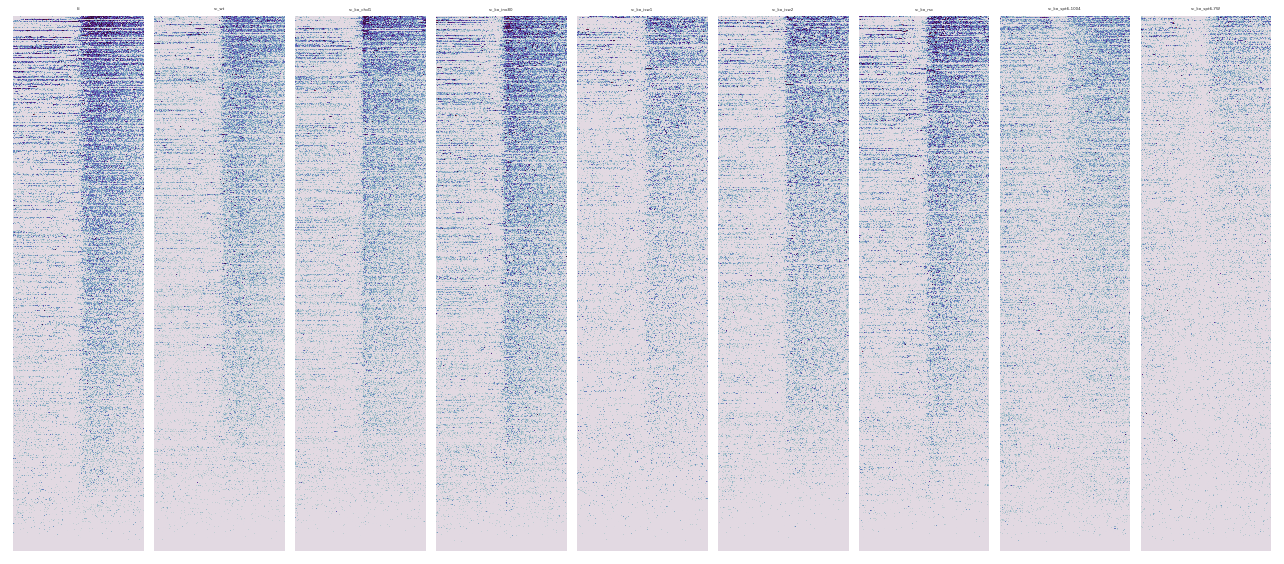

In [0]:
#@title all species / cell states
plot_ns_heatmap = True #@param ["False", "True"] {type:"raw"}
save_ns_heatmap = False #@param ["False", "True"] {type:"raw"}
# details
_ns_heatmap = {
  species_state: np.arcsinh(ns_meta[species_state]["sense"])[
    np.argsort(np.sum(ns_meta[species_state]["sense"], 1))[::-1]]
      for species_state in ns_meta.keys()
}
if plot_ns_heatmap:
  F, A = plt.subplots(1, len(_ns_heatmap), figsize=(len(_ns_heatmap) * 2, 8))
  for i, (n, n_data) in enumerate(_ns_heatmap.items()):
    print(i, n,
      "\n   arcsinh max:", np.around(np.max(n_data), 1),
      "\n   normal max:", np.around(np.max(ns_meta[n]["sense"]), 1)
    )
    sns.heatmap(n_data, 0, np.max(n_data), "twilight", cbar=False, ax=A[i])
    A[i].set_xticks([]); A[i].set_yticks([])
    A[i].set_title(n, fontdict={"fontsize": 4})
  plt.tight_layout(w_pad=-0.15)
  if save_ns_heatmap:
    plt.savefig(_dirs["figs_stats"] + "ns_heatmap.png", format="png", dpi=1024)
    print("ns_heatmap.png - saved")
  plt.show();

In [0]:
#@title all species / cell states - cbar
if plot_ns_heatmap:
  F, A = plt.subplots(1, 1)
  sns.heatmap(np.expand_dims(n_data[0], 1), 0, np.max(n_data), "twilight", ax=A)
  if save_ns_heatmap:
    plt.savefig(_dirs["figs_stats"] + "ns_heatmap_cbar.pdf", format="pdf")
    print("ns_heatmap_cbar.pdf - saved")
  plt.show();

## plot individual considerations

In [0]:
# plotting style
sns.set_style("ticks")

In [0]:
#@title extract index to gene ID
# index : gene ID
  # S. cerevisiae Wildtype
sc_wt_ex_idx_ID = dict(zip(
  np.arange(len(np.unique(meas_dfs["sc"]["ID"]))),
  np.unique(meas_dfs["sc"]["ID"])
))
  # S. cerevisiae Δ CHD1
sc_ko_chd1_ex_idx_ID = dict(zip(
  np.arange(len(np.unique(meas_dfs["sc"]["ID"]))),
  np.unique(meas_dfs["sc"]["ID"])
))
  # K. lactis
kl_ex_idx_ID = dict(zip(
  np.arange(len(np.unique(meas_dfs["kl"]["ID"]))),
  np.unique(meas_dfs["kl"]["ID"])
))

In [0]:
idx = 0

In [0]:
#@title Sc WT
idx += 1
sc_wt_ex_ID = sc_wt_ex_idx_ID[idx]
# get data
  # raw dataframes
sc_wt_ex_dfs = {
  "meas": meas_dfs["sc"][
    meas_dfs["sc"]["ID"] == sc_wt_ex_ID
  ],
  "pred": {
    x: pred_dfs[y][pred_dfs[y]["ID"] == sc_wt_ex_ID]
      for x, y in {
        "ctrl_ctrl": "sc_DS_shuffled_NS_shuffled_output_df",
        "NET": "sc_DS_none_NS_native_output_df",
        "DNA": "sc_DS_native_NS_none_output_df",
        "integrated": "sc_DS_native_NS_native_output_df"
      }.items()
  }
}
  # raw MNase-seq data
sc_wt_ex_raw = {
  "meas": {
    "MS_wt_1": sc_wt_ex_dfs["meas"]["MS_wt_1"].values,
    "MS_wt_2": sc_wt_ex_dfs["meas"]["MS_wt_2"].values
  },
  "pred": {
    x: {
      "avg": np.sum(sc_wt_ex_dfs["pred"][x][[
        col for col in sc_wt_ex_dfs["pred"][x].columns
          if ("N_wt_DS_" in col) and ("pred_mean" in col)
      ]].values, 1),
      "var": np.sum(sc_wt_ex_dfs["pred"][x][[
        col for col in sc_wt_ex_dfs["pred"][x].columns
          if ("N_wt_DS_" in col) and ("pred_variance" in col)
      ]].values, 1)
    } for x in sc_wt_ex_dfs["pred"].keys()
  }
}
  # smoothed MNase-seq data
sc_wt_ex_smooth = {
  "meas": {
    "MS_wt_1": _np_ms_transform(sc_wt_ex_raw["meas"]["MS_wt_1"]),
    "MS_wt_2": _np_ms_transform(sc_wt_ex_raw["meas"]["MS_wt_2"])
  },
  "pred": {
    x: {
      "avg": _np_ms_transform(sc_wt_ex_raw["pred"][x]["avg"]),
      "var": _np_ms_transform(sc_wt_ex_raw["pred"][x]["var"])
    } for x in sc_wt_ex_raw["pred"].keys()
  }
}
# plot details
_ex_details = {
  "clr_pred": {
    "ctrl_ctrl": "#e5e6e6",
    "NET": "#c3cfef",
    "DNA": "#f4bdbf",
    "integrated": "#bb478d"
  },
  "clr_meas": {
    "MS_wt_1": "#3cac49",
    "MS_wt_2": "#b3ffb3"
  },
  "lw_min": 1.0,
  "lw_max": 2.3,
  "a_min": 0.5,
  "a_max": 0.9,
  "_fname_suff": "sc_wt_" + sc_wt_ex_ID
}
# plot
print("plotting " + sc_wt_ex_ID)
  # set-up
F, A = plt.subplots(4, 1, sharex=True, figsize=(11, 10))
# measured data
for ii, (x, clr) in enumerate(_ex_details["clr_meas"].items()):
    # raw
  A[ii].plot(
    sc_wt_ex_raw["meas"][x],
    alpha=_ex_details["a_max"],
    lw=_ex_details["lw_min"],
    color=_ex_details["clr_meas"][x]
  )
  A[ii].fill_between(
    x=np.arange(1024),
    y1=sc_wt_ex_raw["meas"][x],
    alpha=_ex_details["a_min"],
    lw=_ex_details["lw_min"],
    color=_ex_details["clr_meas"][x]
  )
    # smoothed
  A[3].plot(
    sc_wt_ex_smooth["meas"][x],
    alpha=_ex_details["a_max"],
    lw=_ex_details["lw_max"],
    color=_ex_details["clr_meas"][x]
  )
# predicted data
for x, clr in _ex_details["clr_pred"].items():
    # raw
  A[2].plot(
    sc_wt_ex_raw["pred"][x]["avg"],
    alpha=_ex_details["a_max"],
    lw=_ex_details["lw_min"],
    color=clr
  )
    # smoothed
  A[3].plot(
    sc_wt_ex_smooth["pred"][x]["avg"],
    alpha=_ex_details["a_max"],
    lw=_ex_details["lw_max"],
    color=clr
  )
# plot ancillaries
A[0].set_ylim([0, np.max(sc_wt_ex_raw["meas"]["MS_wt_1"])])
A[0].set_yticks([0, np.max(sc_wt_ex_raw["meas"]["MS_wt_1"])])
A[1].set_ylim([0, np.max(sc_wt_ex_raw["meas"]["MS_wt_2"])])
A[1].set_yticks([0, np.max(sc_wt_ex_raw["meas"]["MS_wt_2"])])
A[2].set_yticks([])
A[3].set_yticks([])
for i in range(4):
  A[i].set_xlim([-2, 1026])
  A[i].set_xticks([])
  for s in ["bottom", "left", "top", "right"]:
    A[i].spines[s].set_linewidth(1)
    A[i].spines[s].set_color("k")
plt.tight_layout(pad=0.2, h_pad=-0.2)
plt.show();

In [0]:
#@title Sc WT
%%capture
for idx, sc_wt_ex_ID in sc_wt_ex_idx_ID.items():
  # get data
    # raw dataframes
  sc_wt_ex_dfs = {
    "meas": meas_dfs["sc"][
      meas_dfs["sc"]["ID"] == sc_wt_ex_ID
    ],
    "pred": {
      x: pred_dfs[y][pred_dfs[y]["ID"] == sc_wt_ex_ID]
        for x, y in {
          "ctrl_ctrl": "sc_DS_shuffled_NS_shuffled_output_df",
          "NET": "sc_DS_none_NS_native_output_df",
          "DNA": "sc_DS_native_NS_none_output_df",
          "integrated": "sc_DS_native_NS_native_output_df"
        }.items()
    }
  }
    # raw MNase-seq data
  sc_wt_ex_raw = {
    "meas": {
      "MS_1": sc_wt_ex_dfs["meas"]["MS_1"].values,
      "MS_2": sc_wt_ex_dfs["meas"]["MS_2"].values
    },
    "pred": {
      x: {
        "avg": np.sum(sc_wt_ex_dfs["pred"][x][[
          col for col in sc_wt_ex_dfs["pred"][x].columns
            if ("N_wt_DS_" in col) and ("pred_mean" in col)
        ]].values, 1),
        "var": np.sum(sc_wt_ex_dfs["pred"][x][[
          col for col in sc_wt_ex_dfs["pred"][x].columns
            if ("N_wt_DS_" in col) and ("pred_variance" in col)
        ]].values, 1)
      } for x in sc_wt_ex_dfs["pred"].keys()
    }
  }
    # smoothed MNase-seq data
  sc_wt_ex_smooth = {
    "meas": {
      "MS_1": _np_ms_transform(sc_wt_ex_raw["meas"]["MS_1"]),
      "MS_2": _np_ms_transform(sc_wt_ex_raw["meas"]["MS_2"])
    },
    "pred": {
      x: {
        "avg": _np_ms_transform(sc_wt_ex_raw["pred"][x]["avg"]),
        "var": _np_ms_transform(sc_wt_ex_raw["pred"][x]["var"])
      } for x in sc_wt_ex_raw["pred"].keys()
    }
  }
  # plot details
  _ex_details = {
    "clr_pred": {
      "ctrl_ctrl": "#d1d3d4",
      "NET": "#284492",
      "DNA": "#cb2128",
      "integrated": "#bb478d"
    },
    "clr_meas": {
      "MS_1": "#3cac49",
      "MS_2": "#00b300"
    },
    "lw_min": 1.4,
    "lw_max": 2.6,
    "a_min": 0.4,
    "a_max": 0.7,
    "_fname_suff": "sc_wt_" + sc_wt_ex_ID
  }
  # plot
  print("plotting " + sc_wt_ex_ID)
    # set-up
  F, A = plt.subplots(4, 1, sharex=True, figsize=(11, 14))
  # measured data
  for ii, (x, clr) in enumerate(_ex_details["clr_meas"].items()):
      # raw
    A[ii].plot(
      sc_wt_ex_raw["meas"][x],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_min"],
      color=_ex_details["clr_meas"][x]
    )
    A[ii].fill_between(
      x=np.arange(1024),
      y1=sc_wt_ex_raw["meas"][x],
      alpha=_ex_details["a_min"],
      lw=_ex_details["lw_min"],
      color=_ex_details["clr_meas"][x]
    )
      # smoothed
    A[3].plot(
      sc_wt_ex_smooth["meas"][x],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_max"],
      color=_ex_details["clr_meas"][x]
    )
  # predicted data
  for x, clr in _ex_details["clr_pred"].items():
      # raw
    A[2].plot(
      sc_wt_ex_raw["pred"][x]["avg"],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_max"],
      color=clr
    )
      # smoothed
    A[3].plot(
      sc_wt_ex_smooth["pred"][x]["avg"],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_max"],
      color=clr
    )
  # plot ancillaries
  A[0].set_ylim([0, np.max(sc_wt_ex_raw["meas"]["MS_1"])])
  A[0].set_yticks([0, np.max(sc_wt_ex_raw["meas"]["MS_1"])])
  A[1].set_ylim([0, np.max(sc_wt_ex_raw["meas"]["MS_2"])])
  A[1].set_yticks([0, np.max(sc_wt_ex_raw["meas"]["MS_2"])])
  A[2].set_yticks([])
  A[3].set_yticks([])
  for i in range(4):
    A[i].set_xlim([-2, 1026])
    A[i].set_xticks([])
    for s in ["bottom", "left", "top", "right"]:
      A[i].spines[s].set_linewidth(1)
      A[i].spines[s].set_color("k")
  plt.tight_layout(pad=0.2, h_pad=-0.2)
  # save
  plt.savefig(
    fname="/".join([
      _dirs["figs_stats"], "example_loci", _ex_details["_fname_suff"] + ".pdf"
    ]),
    bbox_inches="tight",
    format="pdf"
  )
  print(_ex_details["_fname_suff"] + ".pdf - saved")
  plt.show();

In [0]:
#@title Sc ΔCHD1
%%capture
for idx, sc_ko_chd1_ex_ID in sc_ko_chd1_ex_idx_ID.items():
  # get data
    # raw dataframes
  sc_ko_chd1_ex_dfs = {
    "meas": meas_dfs["sc"][
      meas_dfs["sc"]["ID"] == sc_ko_chd1_ex_ID
    ],
    "pred": {
      x: pred_dfs[y][pred_dfs[y]["ID"] == sc_ko_chd1_ex_ID]
        for x, y in {
          "ctrl_ctrl": "sc_DS_shuffled_NS_shuffled_output_df",
          "NET": "sc_DS_none_NS_native_output_df",
          "DNA": "sc_DS_native_NS_none_output_df",
          "integrated": "sc_DS_native_NS_native_output_df"
        }.items()
    }
  }
    # raw MNase-seq data
  sc_ko_chd1_ex_raw = {
    "meas": {
      "MS_1": sc_ko_chd1_ex_dfs["meas"]["MS_1"].values,
      "MS_2": sc_ko_chd1_ex_dfs["meas"]["MS_2"].values
    },
    "pred": {
      x: {
        "avg": np.sum(sc_ko_chd1_ex_dfs["pred"][x][[
          col for col in sc_ko_chd1_ex_dfs["pred"][x].columns
            if ("N_ko_chd1_DS_" in col) and ("pred_mean" in col)
        ]].values, 1),
        "var": np.sum(sc_ko_chd1_ex_dfs["pred"][x][[
          col for col in sc_ko_chd1_ex_dfs["pred"][x].columns
            if ("N_ko_chd1_DS_" in col) and ("pred_variance" in col)
        ]].values, 1)
      } for x in sc_ko_chd1_ex_dfs["pred"].keys()
    }
  }
    # smoothed MNase-seq data
  sc_ko_chd1_ex_smooth = {
    "meas": {
      "MS_1": _np_ms_transform(sc_ko_chd1_ex_raw["meas"]["MS_1"]),
      "MS_2": _np_ms_transform(sc_ko_chd1_ex_raw["meas"]["MS_2"])
    },
    "pred": {
      x: {
        "avg": _np_ms_transform(sc_ko_chd1_ex_raw["pred"][x]["avg"]),
        "var": _np_ms_transform(sc_ko_chd1_ex_raw["pred"][x]["var"])
      } for x in sc_ko_chd1_ex_raw["pred"].keys()
    }
  }
  # plot details
  _ex_details = {
    "clr_pred": {
      "ctrl_ctrl": "#d1d3d4",
      "NET": "#284492",
      "DNA": "#cb2128",
      "integrated": "#bb478d"
    },
    "clr_meas": {
      "MS_1": "#3cac49",
      "MS_2": "#00b300"
    },
    "lw_min": 1.4,
    "lw_max": 2.6,
    "a_min": 0.4,
    "a_max": 0.7,
    "_fname_suff": "sc_ko_chd1_" + sc_ko_chd1_ex_ID
  }
  # plot
  print("plotting " + sc_ko_chd1_ex_ID)
    # set-up
  F, A = plt.subplots(4, 1, sharex=True, figsize=(11, 14))
  # measured data
  for ii, (x, clr) in enumerate(_ex_details["clr_meas"].items()):
      # raw
    A[ii].plot(
      sc_ko_chd1_ex_raw["meas"][x],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_min"],
      color=_ex_details["clr_meas"][x]
    )
    A[ii].fill_between(
      x=np.arange(1024),
      y1=sc_ko_chd1_ex_raw["meas"][x],
      alpha=_ex_details["a_min"],
      lw=_ex_details["lw_min"],
      color=_ex_details["clr_meas"][x]
    )
      # smoothed
    A[3].plot(
      sc_ko_chd1_ex_smooth["meas"][x],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_max"],
      color=_ex_details["clr_meas"][x]
    )
  # predicted data
  for x, clr in _ex_details["clr_pred"].items():
      # raw
    A[2].plot(
      sc_ko_chd1_ex_raw["pred"][x]["avg"],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_max"],
      color=clr
    )
      # smoothed
    A[3].plot(
      sc_ko_chd1_ex_smooth["pred"][x]["avg"],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_max"],
      color=clr
    )
  # plot ancillaries
  A[0].set_ylim([0, np.max(sc_ko_chd1_ex_raw["meas"]["MS_1"])])
  A[0].set_yticks([0, np.max(sc_ko_chd1_ex_raw["meas"]["MS_1"])])
  A[1].set_ylim([0, np.max(sc_ko_chd1_ex_raw["meas"]["MS_2"])])
  A[1].set_yticks([0, np.max(sc_ko_chd1_ex_raw["meas"]["MS_2"])])
  A[2].set_yticks([])
  A[3].set_yticks([])
  for i in range(4):
    A[i].set_xlim([-2, 1026])
    A[i].set_xticks([])
    for s in ["bottom", "left", "top", "right"]:
      A[i].spines[s].set_linewidth(1)
      A[i].spines[s].set_color("k")
  plt.tight_layout(pad=0.2, h_pad=-0.2)
  # save
  plt.savefig(
    fname="/".join([
      _dirs["figs_stats"], "example_loci", _ex_details["_fname_suff"] + ".pdf"
    ]),
    bbox_inches="tight",
    format="pdf"
  )
  print(_ex_details["_fname_suff"] + ".pdf - saved")
  plt.show();

In [0]:
#@title Kl
%%capture
for idx, kl_ex_ID in kl_ex_idx_ID.items():
  # get data
    # raw dataframes
  kl_ex_dfs = {
    "meas": meas_dfs["kl"][
      meas_dfs["kl"]["ID"] == kl_ex_ID
    ],
    "pred": {
      x: pred_dfs[y][pred_dfs[y]["ID"] == kl_ex_ID]
        for x, y in {
          "ctrl_ctrl": "kl_DS_shuffled_NS_shuffled_output_df",
          "NET": "kl_DS_none_NS_native_output_df",
          "DNA": "kl_DS_native_NS_none_output_df",
          "integrated": "kl_DS_native_NS_native_output_df"
        }.items()
    }
  }
    # raw MNase-seq data
  kl_ex_raw = {
    "meas": kl_ex_dfs["meas"]["MS_1"].values,
    "pred": {
      x: {
        "avg": np.sum(kl_ex_dfs["pred"][x][[
          col for col in kl_ex_dfs["pred"][x].columns
            if "pred_mean" in col
        ]].values, 1),
        "var": np.sum(kl_ex_dfs["pred"][x][[
          col for col in kl_ex_dfs["pred"][x].columns
            if "pred_variance" in col
        ]].values, 1)
      } for x in kl_ex_dfs["pred"].keys()
    }
  }
    # smoothed MNase-seq data
  kl_ex_smooth = {
    "meas": _np_ms_transform(kl_ex_raw["meas"]),
    "pred": {
      x: {
        "avg": _np_ms_transform(kl_ex_raw["pred"][x]["avg"]),
        "var": _np_ms_transform(kl_ex_raw["pred"][x]["var"])
      } for x in kl_ex_raw["pred"].keys()
    }
  }
  # plot details
  _ex_details = {
    "clr_pred": {
      "ctrl_ctrl": "#d1d3d4",
      "NET": "#284492",
      "DNA": "#cb2128",
      "integrated": "#bb478d"
    },
    "clr_meas": "#3cac49",
    "lw_min": 1.4,
    "lw_max": 2.6,
    "a_min": 0.4,
    "a_max": 0.7,
    "_fname_suff": "kl_" + str(kl_ex_ID)
  }
  # plot
  print("plotting " + str(kl_ex_ID))
  # set-up
  F, A = plt.subplots(3, 1, sharex=True, figsize=(11, 11))
  # measured data
    # raw
  A[0].plot(
    kl_ex_raw["meas"],
    alpha=_ex_details["a_max"],
    lw=_ex_details["lw_min"],
    color=_ex_details["clr_meas"]
  )
  A[0].fill_between(
    x=np.arange(1024),
    y1=kl_ex_raw["meas"],
    alpha=_ex_details["a_min"],
    lw=_ex_details["lw_min"],
    color=_ex_details["clr_meas"]
  )
    # smoothed
  A[2].plot(
    kl_ex_smooth["meas"],
    alpha=_ex_details["a_max"],
    lw=_ex_details["lw_max"],
    color=_ex_details["clr_meas"]
  )
  # predicted data
  for x, clr in _ex_details["clr_pred"].items():
      # raw
    A[1].plot(
      kl_ex_raw["pred"][x]["avg"],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_max"],
      color=clr
    )
      # smoothed
    A[2].plot(
      kl_ex_smooth["pred"][x]["avg"],
      alpha=_ex_details["a_max"],
      lw=_ex_details["lw_max"],
      color=clr
    )
  # plot ancillaries
  A[0].set_ylim([0, np.max(kl_ex_raw["meas"])])
  A[1].set_yticks([])
  A[2].set_yticks([])
  for i in range(3):
    A[i].set_xlim([-2, 1026])
    A[i].set_xticks([])
    for s in ["bottom", "left", "top", "right"]:
      A[i].spines[s].set_linewidth(1)
      A[i].spines[s].set_color("k")
  plt.tight_layout(pad=0.2, h_pad=-0.2)
  # save
  plt.savefig(
    fname="/".join([
      _dirs["figs_stats"], "example_loci", _ex_details["_fname_suff"] + ".pdf"
    ]),
    bbox_inches="tight",
    format="pdf"
  )
  print(_ex_details["_fname_suff"] + ".pdf - saved")
  plt.show();

# scratch

In [0]:
# load measured data
meas_dfs = {
  "kl": pd.read_csv(os.path.join(_dirs["collated"], "kl_test_df.csv")),
  "sc": pd.read_csv(os.path.join(_dirs["collated"], "sc_valid_test_df.csv"))
}
# load collated predictions
pred_dfs = {
  "_".join([species, "DS_native_NS_native", "output_df"]): pd.read_csv(
    _dirs["collated"] + "_".join([species, "DS_native_NS_native", "output_df.csv"])
  ) for species in ["kl", "sc"]
}
  # tidy up dataframes
for df in meas_dfs.keys():
  meas_dfs[df] = meas_dfs[df][[
    col for col in meas_dfs[df].columns.values
      if "Unnamed" not in col
  ]]
for df in pred_dfs.keys():
  pred_dfs[df] = pred_dfs[df][[
    col for col in pred_dfs[df].columns.values
      if "Unnamed" not in col
  ]]

In [0]:
runs = np.unique(
  np.array([
    x.split("_run_")[1].split("_")[0]
      for x in pred_dfs["sc_DS_native_NS_native_output_df"].columns.values
        if "run" in x
  ]),
  return_counts=True
)
runs = np.unique(
  np.array([
    x.split("_run_")[1].split("_")[0]
      for x in pred_dfs["sc_DS_native_NS_native_output_df"].columns.values
        if "run" in x
  ]),
  return_counts=True
)

In [0]:
# input mode / run mode - collation parameters
collated_dir = _dirs["collated"]
outputs_dir = _dirs["model_outputs"]
inp_mode = "DS_native_NS_native"
run_mode = "_run_15"

In [0]:
sc_N_states=[
  "N_wt", "N_ko_chd1", "N_ko_isw1", "N_ko_isw2",
  "N_ko_rsc", "N_ko_spt6-1004", "N_ko_spt6-YW"
]

In [0]:
# input mode specific dataframes
output_dfs = {
  x.split(".")[0]: pd.read_csv(collated_dir + x)
    for x in os.listdir(collated_dir)
      if (inp_mode in x) and ("output" in x)
}

In [0]:
# load predictions according to input mode and run mode
preds = {
  x.split(".")[0]: np.load(outputs_dir + x)
    for x in os.listdir(outputs_dir)
      if (inp_mode in x) and (run_mode in x)
}

In [0]:
# combine K. lactis
raw_outputs = {
  "_".join(["kl", inp_mode, run_mode]): np.concatenate([
    np.expand_dims(preds[y].item().get("kl").flatten(), 1)
      for y in preds.keys()
  ], axis=1)
}

In [0]:
# combine S. cerevisiae predictions
raw_outputs.update({
  "_".join(["sc", state, inp_mode, run_mode]): np.concatenate(
    list({
      seqid: np.concatenate([np.expand_dims(
        preds[x].item().get("sc").get(state).flatten(), 1)
          for x in preds.keys() if x.split("_")[7] == seqid
      ], 1) for seqid in np.arange(1, 17).astype("str")
    }.values()), 0) for state in sc_N_states
})

In [0]:
states = [
  "N_wt",
  "N_ko_chd1",
  "N_ko_isw1",
  "N_ko_isw2",
  "N_ko_rsc",
  "N_ko_spt6-1004",
  "N_ko_spt6-YW"
]

In [0]:
def _np_ms_meta_repr(vectors, context=None, eps=_heuristics["epsilon"]):
  """return smoothed, normalized, z-score transformed avg MNase-seq profile
    context := meas (measured) or pred (predicted)
    vectors := matrix ( # regions, 1024 )"""
  # sum gaussian smoothed
  smooth = np.sum([
    _np_smooth_gaussian(i / (np.sum(i) + eps))
      for i in vectors
  ], 0)
  return smooth
#   if context == "meas": return smooth
#   else:
#     # z-score normalize 
#     z_norm = (smooth - np.average(smooth)) / np.std(smooth)
#     # normalize by magnitude
#     z_norm_s_norm = z_norm / (np.sum(np.abs(z_norm)) + eps)
#     # translate to positive domain
#     return z_norm_s_norm + np.abs(np.min(z_norm_s_norm))

In [0]:
#@title local (dict) and meta (df) MNase-seq
  # local - ( # regions, 1024 )
agg_ms_data = {
  "kl": {
    "meas": {
      "MS_1": _np_get_seq_data(["MS_1"], meas_dfs["kl"]).squeeze()
    },
    "pred": {
      "_".join(x.split("_")[1:5]): _np_avg_var_df(pred_dfs[x])
        for x in pred_dfs.keys() if "kl_" in x
    }
  },
  "sc": {
    "meas": {
      "MS_wt_1": _np_get_seq_data(["MS_wt_1"], meas_dfs["sc"]).squeeze(),
      "MS_wt_2": np.sum(np.concatenate([
        _np_get_seq_data(["MS_wt_2"], meas_dfs["sc"]),
        _np_get_seq_data(["MS_wt_3"], meas_dfs["sc"])
      ], 1), 1),
      "MS_wt_4": _np_get_seq_data(["MS_wt_4"], meas_dfs["sc"]).squeeze(),
      "MS_ko_spt6-1004": _np_get_seq_data(["MS_ko_spt6-1004"], meas_dfs["sc"]).squeeze(),
      "MS_ko_spt6-YW": _np_get_seq_data(["MS_ko_spt6-YW"], meas_dfs["sc"]).squeeze()
    },
    "pred": {
      state: {
        "_".join(x.split("_")[1:5]): _np_avg_var_df(pred_dfs[x], [state])
          for x in pred_dfs.keys() if "sc_" in x
      } for state in blah
    }
  }
}
  # global / meta - ( 1024 )
agg_ms_meta = pd.concat([
  pd.DataFrame({
    "kl_MS_1": _np_ms_meta_repr(agg_ms_data["kl"]["meas"]["MS_1"], "meas"),
    "sc_MS_wt_1": _np_ms_meta_repr(agg_ms_data["sc"]["meas"]["MS_wt_1"], "meas"),
    "sc_MS_wt_2": _np_ms_meta_repr(agg_ms_data["sc"]["meas"]["MS_wt_2"], "meas"),
    "sc_MS_wt_4": _np_ms_meta_repr(agg_ms_data["sc"]["meas"]["MS_wt_4"], "meas"),
    "MS_ko_spt6-1004": _np_ms_meta_repr(agg_ms_data["sc"]["meas"]["MS_ko_spt6-1004"], "meas"),
    "MS_ko_spt6-YW": _np_ms_meta_repr(agg_ms_data["sc"]["meas"]["MS_ko_spt6-YW"], "meas")
  }),
  pd.DataFrame({
    "_".join(["kl", "DS_native_NS_native"]): _np_ms_meta_repr(
        agg_ms_data["kl"]["pred"]["DS_native_NS_native"]["avg"]
    )
  }),
  pd.DataFrame({
    "_".join(["sc", state, "DS_native_NS_native"]): _np_ms_meta_repr(
        agg_ms_data["sc"]["pred"][state]["DS_native_NS_native"]["avg"]
    ) for state in blah
  })
], 1)

In [0]:
#@title meta plot details
  # s. cerevisiae
_sc_meas_ms_meta = {
  "sc_MS_wt_1": {
    "color": "#26734d",
    "label": "rep. 1",
    "linestyle": "-"
  },
  "sc_MS_wt_2": {
    "color": "#669900",
    "label": "rep. 2",
    "linestyle": "-",
  },
  "sc_MS_wt_4": {
    "color": "#b300b3",
    "label": "rep. 4",
    "linestyle": "-",
  },
  "MS_ko_spt6-1004": {
    "color": "#ff8000",
    "label": "spt6-1004",
    "linestyle": (0, (5, 1.5))
  },
  "MS_ko_spt6-YW": {
    "color": "#e6005c",
    "label": "spt6-YW",
    "linestyle": (0, (5, 1.5))
  }
}
_sc_pred_ms_meta = {
  "sc_N_wt_DS_native_NS_native": {
    "color": "#26734d",
    "label": "wt",
    "linestyle": "-"
  },
  "sc_N_ko_spt6-1004_DS_native_NS_native": {
    "color": "#ff8000",
    "label": "spt6-1004",
    "linestyle": (0, (5, 1.5))
  },
  "sc_N_ko_spt6-YW_DS_native_NS_native": {
    "color": "#e6005c",
    "label": "spt6-YW",
    "linestyle": (0, (5, 1.5))
  }
}
  # k. lactis
_kl_ms_meta = {
  "kl_MS_1": {
    "color": "#669900",
    "label": "meas",
    "linestyle": "-"
  },
  "kl_DS_native_NS_native": {
    "color": "#b82e8a",
    "label": "pred",
    "linestyle": "-",
  }
}

In [0]:
#@title Sc. KO
_sc_ko = {
  "sc_N_wt_DS_native_NS_native": {
    "color": "#26734d",
    "label": "wt",
    "linestyle": "-",
    "lw": 2.5
  },
  "sc_N_ko_chd1_DS_native_NS_native": {
    "color": "#009999",
    "label": "chd1",
    "linestyle": "-",
    "alpha": 0.5
  },
  "sc_N_ko_isw1_DS_native_NS_native": {
    "color": "#008ae6",
    "label": "isw1",
    "linestyle": "-",
    "alpha": 0.5
  },
  "sc_N_ko_isw2_DS_native_NS_native": {
    "color": "#5c00e6",
    "label": "isw2",
    "linestyle": "-",
    "alpha": 0.5
  },
  "sc_N_ko_rsc_DS_native_NS_native": {
    "color": "#b30086",
    "label": "rsc",
    "linestyle": "-",
    "alpha": 0.5
  },
  "sc_N_ko_spt6-1004_DS_native_NS_native": {
    "color": "#e60000",
    "label": "spt6-1004",
    "linestyle": "-",
    "alpha": 0.5
  },
  "sc_N_ko_spt6-YW_DS_native_NS_native": {
    "color": "#e68a00",
    "label": "spt6-YW",
    "linestyle": "-",
    "alpha": 0.5
  }
}

F, A = plt.subplots(1, 1, figsize=(14, 9))
for i, details in _sc_ko.items():
  A.plot(agg_ms_meta[i].values, **details)
  nucs = _np_ms_meta_extrema((agg_ms_meta[i].values))
  print(i, "\n  locations: ", nucs, end=" ")
  print("\n  distances: ", [nucs[i] - nucs[i - 1] for i in range(1, len(nucs))], "\n")
        
A.set_yticks([])
A.set_ylabel(None)
A.set_xticks(np.linspace(0, 1024, 9))
A.set_xlim([0, 1024])
A.set_xticklabels([""] * 9)
[A.spines[s].set_color(None) for s in ["left", "top", "right"]]
plt.grid(axis="x")
plt.legend(loc=2, prop={'size': 12})
plt.tight_layout()
plt.show();

In [0]:
#@title measured meta

F, A = plt.subplots(1, 1, figsize=(11, 7))
for i, details in _sc_meas_ms_meta.items():
  A.plot(agg_ms_meta[i].values, lw=2.5, alpha=0.75, **details)
  nucs = _np_ms_meta_extrema((agg_ms_meta[i].values))
  print(i, "\n  locations: ", nucs, end=" ")
  print("\n  distances: ", [nucs[i] - nucs[i - 1] for i in range(1, len(nucs))], "\n")
        
A.set_yticks([])
A.set_ylabel(None)
A.set_xticks(np.linspace(0, 1024, 9))
A.set_xlim([0, 1024])
A.set_xticklabels([""] * 9)
[A.spines[s].set_color(None) for s in ["left", "top", "right"]]
plt.grid(axis="x")
plt.legend(loc=2)
plt.tight_layout()
plt.show();

In [0]:
#@title measured meta

F, A = plt.subplots(1, 1, figsize=(11, 7))
for i, details in _sc_pred_ms_meta.items():
  A.plot(agg_ms_meta[i].values, lw=2.5, alpha=0.75, **details)
  nucs = _np_ms_meta_extrema((agg_ms_meta[i].values))
  print(i, "\n  locations: ", nucs, end=" ")
  print("\n  distances: ", [nucs[i] - nucs[i - 1] for i in range(1, len(nucs))], "\n")
        
A.set_yticks([])
A.set_ylabel(None)
A.set_xticks(np.linspace(0, 1024, 9))
A.set_xlim([0, 1024])
A.set_xticklabels([""] * 9)
[A.spines[s].set_color(None) for s in ["left", "top", "right"]]
plt.grid(axis="x")
plt.legend(loc=2)
plt.tight_layout()
plt.show();

In [0]:
#@title K. lactis

F, A = plt.subplots(1, 1, figsize=(11, 7))
for i, details in _kl_ms_meta.items():
  A.plot(agg_ms_meta[i].values, lw=2.5, alpha=0.75, **details)
  nucs = _np_ms_meta_extrema((agg_ms_meta[i].values))
  print(i, "\n  locations: ", nucs, end=" ")
  print("\n  distances: ", [nucs[i] - nucs[i - 1] for i in range(1, len(nucs))], "\n")
        
A.set_yticks([])
A.set_ylabel(None)
A.set_xticks(np.linspace(0, 1024, 9))
A.set_xlim([0, 1024])
A.set_xticklabels([""] * 9)
[A.spines[s].set_color(None) for s in ["left", "top", "right"]]
plt.grid(axis="x")
plt.legend(loc=2)
plt.tight_layout()
plt.show();

In [0]:
nucs = {
  "kl_meas": _np_ms_meta_extrema(
    (agg_ms_meta["kl_MS_1"].values)
  ),
  "kl_pred": _np_ms_meta_extrema(
    (agg_ms_meta["kl_DS_native_NS_native"].values)
  ),
  "sc_meas_1": _np_ms_meta_extrema(
    (agg_ms_meta["sc_MS_wt_1"].values)
  ),
  "sc_meas_2": _np_ms_meta_extrema(
    (agg_ms_meta["sc_MS_wt_2"].values)
  ),
  "sc_pred": _np_ms_meta_extrema(
    (agg_ms_meta["sc_N_wt_DS_native_NS_native"].values)
  )
}
dist = {
  x: np.array([
    nucs[x][i] - nucs[x][i - 1] for i in range(1, 5)
  ]) for x in nucs
}

In [0]:
rel_sc_sc_nucs = {
  "meas": nucs["sc_meas_2"] - nucs["sc_meas_1"],
  "pred": nucs["sc_pred"] - nucs["sc_meas_1"]
}
rel_kl_sc_nucs = {
  "meas": nucs["kl_meas"] - nucs["sc_meas_1"],
  "pred": nucs["kl_pred"] - nucs["sc_pred"]
}
rel_kl_kl_nucs = nucs["kl_meas"] - nucs["kl_pred"]
rel_sc_sc_dist = {
  "meas": dist["sc_meas_2"] - dist["sc_meas_1"],
  "pred": dist["sc_pred"] - dist["sc_meas_1"]
}
rel_kl_sc_dist = {
  "meas": dist["kl_meas"] - dist["sc_meas_1"],
  "pred": dist["kl_pred"] - dist["sc_pred"]
}
rel_kl_kl_dist = dist["kl_meas"] - dist["kl_pred"]

In [0]:
# meta plot details
hm_sort_idx = np.argsort(
  np.sum(_np_get_seq_data(
    columns=["NS_wt_antisense", "NS_wt_sense"],
    data=meas_dfs["sc"]
  ).squeeze()[:, 0, :], 1)
)[::-1]
hm_data = {
  x: agg_ms_data["sc"]["meas"][x][hm_sort_idx, :]
    for x in agg_ms_data["sc"]["meas"].keys()
}
hm_data.update({
  x: agg_ms_data["sc"]["pred"][x]["DS_native_NS_native"]["avg"][hm_sort_idx, :]
    for x in agg_ms_data["sc"]["pred"].keys()
})

0 MS_wt_1
1 MS_wt_2
2 MS_wt_4
3 MS_ko_spt6-1004
4 MS_ko_spt6-YW
5 N_wt
6 N_ko_chd1
7 N_ko_isw1
8 N_ko_isw2
9 N_ko_rsc
10 N_ko_spt6-1004
11 N_ko_spt6-YW


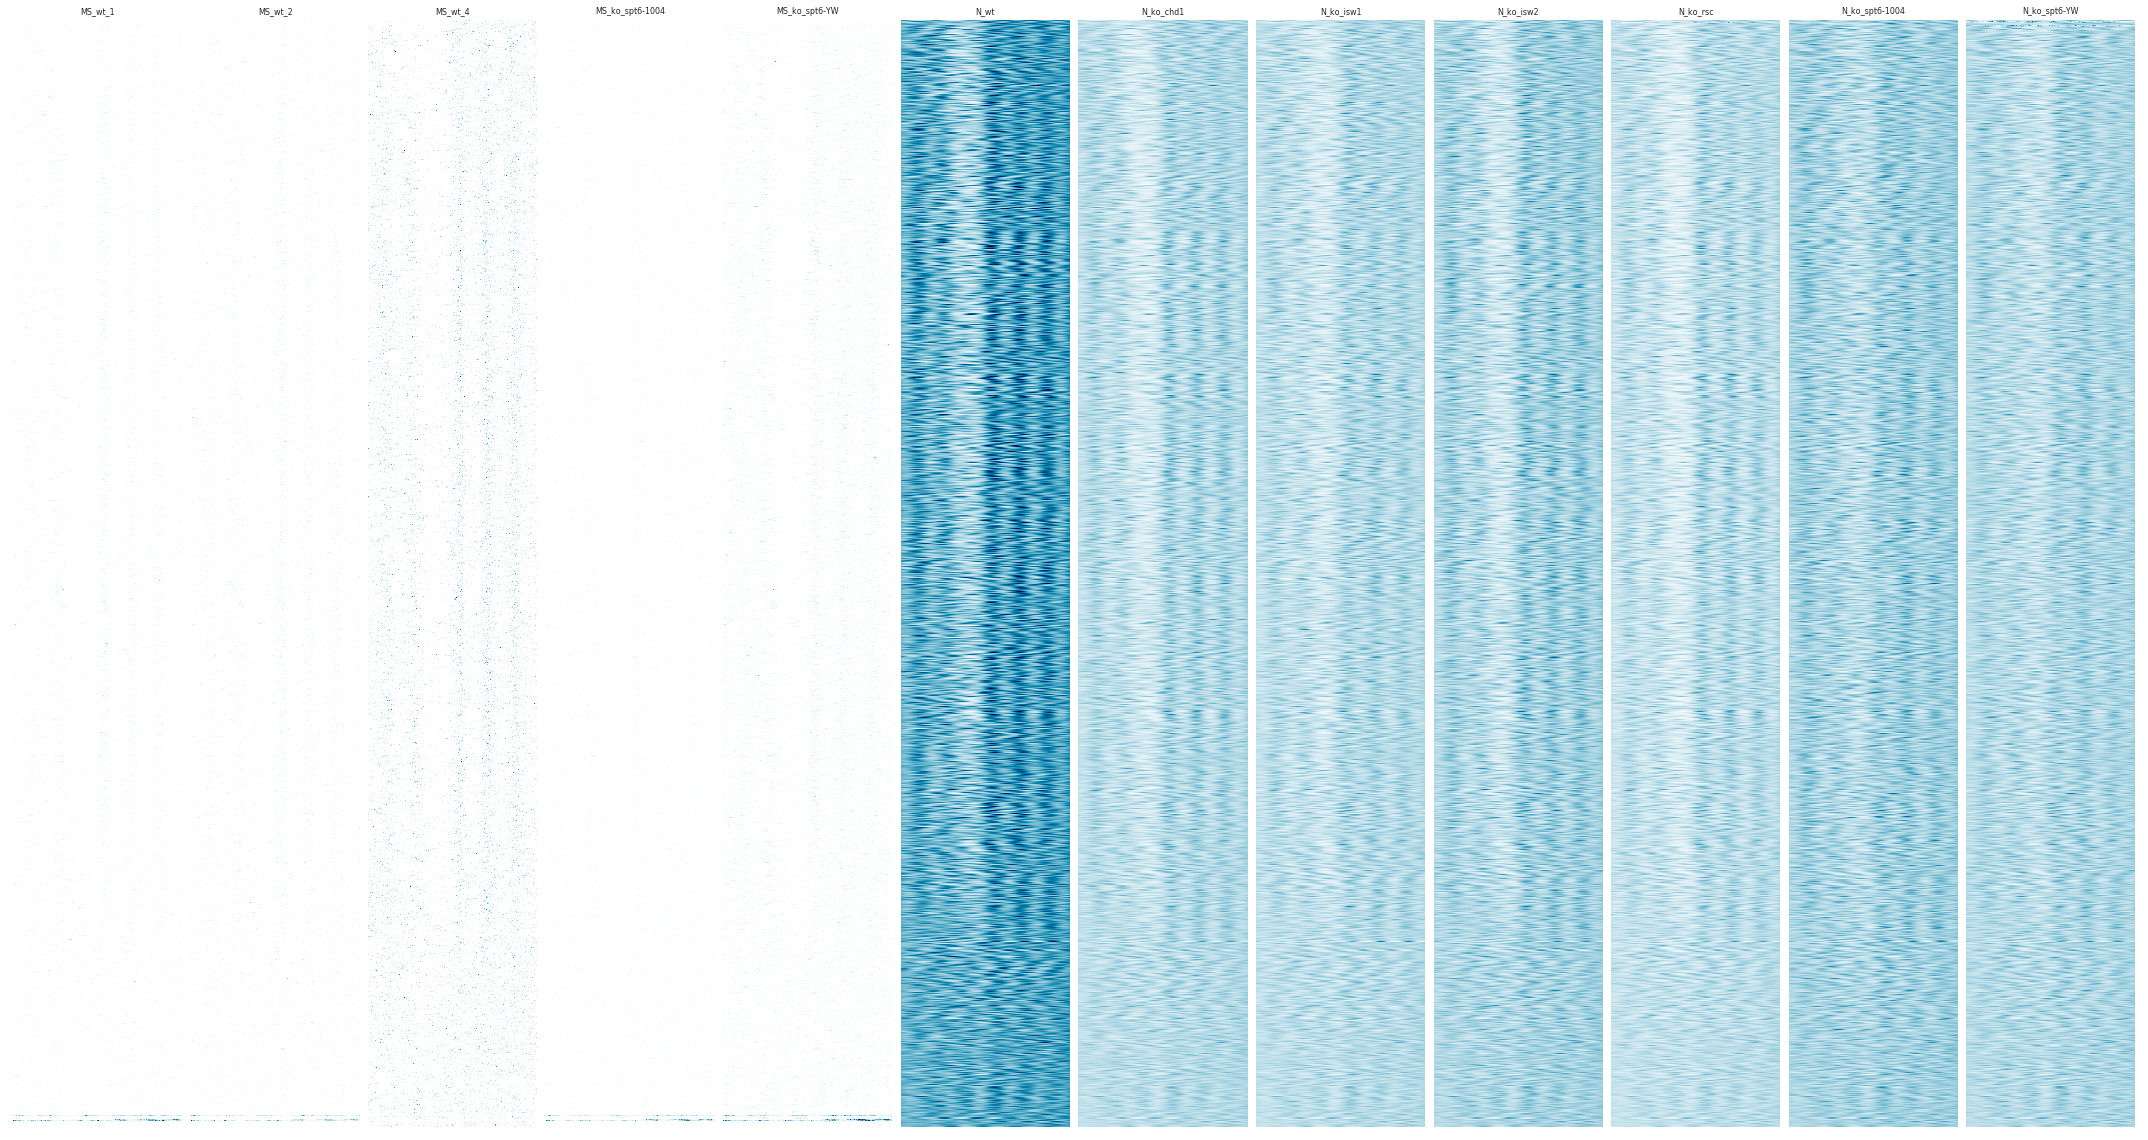

In [0]:
# plot
F, A = plt.subplots(1, len(hm_data), figsize=(2.5 * len(hm_data), 16))
for i, (m, m_data) in enumerate(hm_data.items()):
  print(i, m)
  sns.heatmap(
    data=m_data,
    cbar=False,
    vmin=np.min(m_data),
    vmax=np.max(m_data),
    cmap="ocean_r",
    ax=A[i]
  )
  A[i].set_xticks([]); A[i].set_yticks([])
  A[i].set_title(m, fontdict={"fontsize": 8})
plt.tight_layout(w_pad=-0.3)
plt.show();

# backend

In [0]:
%reset -f

In [0]:
%whos

In [0]:
!cat /proc/meminfo

In [0]:
!pip freeze